# scgpt + molgpt pipeline....

## installs

In [36]:
!pip install anndata

In [37]:
!pip install scanpy

In [38]:
!pip install rdkit

In [39]:
!pip install deeplife-mlinfra


ERROR: Could not find a version that satisfies the requirement deeplife-mlinfra (from versions: none)
ERROR: No matching distribution found for deeplife-mlinfra


## scripts

In [40]:
%%writefile scgpt_smiles_model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import anndata
import scanpy as sc
import os
import numpy as np
from typing import Dict, List, Optional, Tuple, Union
import math
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from molgpt_loader import load_mol_gpt_model


# Model Components
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class DoublePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Use the full embedding dimension divided into two halves
        self.d_model = d_model
        half_dim = d_model // 2

        # Create position encodings for both input and output positions
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, half_dim, 2) * (-math.log(10000.0) / half_dim))

        # Input position encodings
        pe_input = torch.zeros(max_len, half_dim)
        pe_input[:, 0::2] = torch.sin(position * div_term)
        pe_input[:, 1::2] = torch.cos(position * div_term)

        # Output position encodings
        pe_output = torch.zeros(max_len, half_dim)
        pe_output[:, 0::2] = torch.sin(position * div_term)
        pe_output[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe_input', pe_input)
        self.register_buffer('pe_output', pe_output)

    def forward(self, x, input_positions, output_positions):
        batch_size, seq_length, _ = x.shape

        # Create a tensor of zeros with the same shape as the input
        pos_encoding = torch.zeros_like(x)

        # For each item in the batch
        for b in range(batch_size):
            for t in range(seq_length):
                # Get the input and output positions for this token
                input_pos = input_positions[b, t] if input_positions is not None else t
                output_pos = output_positions[b, t] if output_positions is not None else t

                if input_pos < self.pe_input.size(0) and output_pos < self.pe_output.size(0):
                    # Fill the first half with input position encoding
                    pos_encoding[b, t, :self.d_model//2] = self.pe_input[input_pos]
                    # Fill the second half with output position encoding
                    pos_encoding[b, t, self.d_model//2:] = self.pe_output[output_pos]

        return x + pos_encoding

class PerceiverAttention(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm_media = nn.LayerNorm(dim)
        self.norm_latents = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(self, x, latents):
        """
        x: [batch_size, seq_len_x, dim]
        latents: [batch_size, seq_len_l, dim]
        """
        batch_size = x.shape[0]

        x = self.norm_media(x)
        latents = self.norm_latents(latents)

        # Ensure latents has correct batch size
        if latents.size(0) != batch_size:
            latents = latents.expand(batch_size, -1, -1)

        q = self.to_q(latents)
        # Handle rearrange function
        q = q.view(batch_size, -1, self.heads, q.size(-1) // self.heads).transpose(1, 2)
        q = q * self.scale

        # Ensure proper concatenation
        kv_input = torch.cat((x, latents), dim=1)  # concatenate along sequence dimension
        k, v = self.to_kv(kv_input).chunk(2, dim=-1)
        # Handle rearrange function
        k = k.view(batch_size, -1, self.heads, k.size(-1) // self.heads).transpose(1, 2)
        v = v.view(batch_size, -1, self.heads, v.size(-1) // self.heads).transpose(1, 2)

        sim = torch.einsum('b h i d, b h j d -> b h i j', q, k)
        attn = sim.softmax(dim=-1)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        # Handle rearrange function
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.heads * out.size(-1))

        return self.to_out(out)

class GatedCrossAttentionBlock(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, ff_mult=4):
        super().__init__()
        self.attn = PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads)
        self.attn_gate = nn.Parameter(torch.tensor([0.]))
        self.ff = FeedForward(dim, mult=ff_mult)
        self.ff_gate = nn.Parameter(torch.tensor([0.]))

    def forward(self, x, media):
        """
        x: [batch_size, seq_len_x, dim]
        media: [batch_size, seq_len_m, dim]
        """
        batch_size = x.shape[0]
        target_batch_size = media.size(0)

        # Handle batch size mismatch
        if batch_size > target_batch_size:
            media = media.expand(batch_size, -1, -1)
        elif batch_size < target_batch_size:
            x = x.expand(target_batch_size, -1, -1)

        gate = self.attn_gate.tanh()
        x = self.attn(media, x) * gate + x
        x = self.ff(x) * self.ff_gate.tanh() + x
        return x

class PerceiverResampler(nn.Module):
    def __init__(self, dim, depth, dim_head=64, heads=8, num_latents=64):
        super().__init__()
        # Initialize latents without batch dimension
        self.latents = nn.Parameter(torch.randn(num_latents, dim))
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads),
                FeedForward(dim=dim)
            ]))

    def forward(self, x):
        batch_size = x.shape[0]
        if len(x.shape) == 2:
          x = x.unsqueeze(1)  # [batch_size, embedding_dim] -> [batch_size, 1, embedding_dim]

        # Expand latents to batch size (handle repeat function)
        latents = self.latents.unsqueeze(0).expand(batch_size, -1, -1)

        for attn, ff in self.layers:
            latents = attn(x, latents) + latents
            latents = ff(latents) + latents

        return latents

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * mult, bias=False),
            nn.GELU(),
            nn.Linear(dim * mult, dim, bias=False)
        )

    def forward(self, x):
        return self.net(x)


from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski, QED
from rdkit.Chem import DataStructs
import numpy as np
from scipy.spatial.distance import cosine

class MoleculeMetrics:
    @staticmethod
    def is_valid_smiles(smiles):
        """Check if a SMILES string represents a valid molecule."""
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    @staticmethod
    def tanimoto_similarity(smiles1, smiles2):
        """Calculate Tanimoto similarity between two SMILES strings."""
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)

        if mol1 is None or mol2 is None:
            return 0.0

        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=2048)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=2048)

        return DataStructs.TanimotoSimilarity(fp1, fp2)

    @staticmethod
    def compute_fingerprint(smiles):
        """Compute Morgan fingerprint for a molecule."""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

    @staticmethod
    def fingerprint_to_numpy(fingerprint):
        """Convert RDKit fingerprint to numpy array."""
        if fingerprint is None:
            return None
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fingerprint, arr)
        return arr

    @staticmethod
    def calc_cosine_distance(fp1, fp2):
        """Calculate cosine distance between two fingerprints."""
        if fp1 is None or fp2 is None:
            return 1.0  # Maximum distance
        return cosine(fp1, fp2)

    @staticmethod
    def calculate_druglikeness_metrics(smiles):
        """Calculate druglikeness using Lipinski's Rule of 5 and QED."""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {
                'valid': 0,
                'mw': None,
                'logp': None,
                'hba': None,
                'hbd': None,
                'rotatable_bonds': None,
                'qed': None,
                'lipinski_violations': None,
                'rule_of_5': 0
            }

        # Calculate druglikeness properties
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hba = Descriptors.NumHAcceptors(mol)
        hbd = Descriptors.NumHDonors(mol)
        rotatable_bonds = Descriptors.NumRotatableBonds(mol)
        qed = QED.qed(mol)

        # Count Lipinski violations
        lipinski_violations = 0
        if mw > 500: lipinski_violations += 1
        if logp > 5: lipinski_violations += 1
        if hba > 10: lipinski_violations += 1
        if hbd > 5: lipinski_violations += 1

        # Rule of 5 pass (0 or 1 violations is considered a pass)
        rule_of_5 = 1 if lipinski_violations <= 1 else 0

        return {
            'valid': 1,
            'mw': mw,
            'logp': logp,
            'hba': hba,
            'hbd': hbd,
            'rotatable_bonds': rotatable_bonds,
            'qed': qed,
            'lipinski_violations': lipinski_violations,
            'rule_of_5': rule_of_5
        }

    @staticmethod
    def evaluate_molecule_pair(ground_truth, generated):
        """Evaluate a pair of ground truth and generated SMILES strings."""
        # Validate molecules
        gt_valid = MoleculeMetrics.is_valid_smiles(ground_truth)
        gen_valid = MoleculeMetrics.is_valid_smiles(generated)

        # Calculate similarity if both are valid
        similarity = 0.0
        if gt_valid and gen_valid:
            similarity = MoleculeMetrics.tanimoto_similarity(ground_truth, generated)

        # Get druglikeness metrics for generated molecule
        gen_metrics = MoleculeMetrics.calculate_druglikeness_metrics(generated)

        # Create result dictionary
        result = {
            'ground_truth': ground_truth,
            'generated': generated,
            'gt_valid': 1 if gt_valid else 0,
            'gen_valid': 1 if gen_valid else 0,
            'tanimoto_similarity': similarity,
            **gen_metrics
        }

        return result

    @staticmethod
    def aggregate_metrics(results):
        """Aggregate metrics across multiple molecule pairs."""
        metrics = {
            'total_pairs': len(results),
            'gt_valid_ratio': np.mean([r['gt_valid'] for r in results]),
            'gen_valid_ratio': np.mean([r['gen_valid'] for r in results]),
            'avg_tanimoto': np.mean([r['tanimoto_similarity'] for r in results]),
            'avg_qed': np.mean([r['qed'] for r in results if r['qed'] is not None]),
            'rule_of_5_pass_ratio': np.mean([r['rule_of_5'] for r in results if r['rule_of_5'] is not None]),
            'avg_lipinski_violations': np.mean([r['lipinski_violations'] for r in results if r['lipinski_violations'] is not None])
        }

        # Calculate additional statistics
        valid_indices = [i for i, r in enumerate(results) if r['gen_valid'] == 1]
        if valid_indices:
            valid_results = [results[i] for i in valid_indices]
            metrics.update({
                'valid_molecules': len(valid_results),
                'avg_mw': np.mean([r['mw'] for r in valid_results]),
                'avg_logp': np.mean([r['logp'] for r in valid_results]),
                'avg_hba': np.mean([r['hba'] for r in valid_results]),
                'avg_hbd': np.mean([r['hbd'] for r in valid_results]),
                'avg_rotatable_bonds': np.mean([r['rotatable_bonds'] for r in valid_results])
            })

        return metrics


class SCGPTSmilesGPT(nn.Module):
    def __init__(self, max_len,
                 cross_attn_every=3, dim_head=64, heads=8,
                 perceiver_depth=2, perceiver_num_latents=64,
                 working_dir="./scgpt_smiles_workdir",
                 embedding_dim=512):
        super().__init__()

        # Load molGPT model
        self.smilesgpt_model, self.smilesgpt_tokenizer = load_mol_gpt_model()
        self.max_len = max_len
        self.working_dir = working_dir

        if self.smilesgpt_tokenizer.pad_token is None:
            self.smilesgpt_tokenizer.pad_token = self.smilesgpt_tokenizer.eos_token
            self.smilesgpt_model.config.pad_token_id = self.smilesgpt_model.config.eos_token_id

        self.cross_attn_every = cross_attn_every

        # Add projection layer to adapt scGPT embedding dimension to molGPT dimension if needed
        self.projection = nn.Linear(embedding_dim, self.smilesgpt_model.config.n_embd)

        self.positional_encoding = DoublePositionalEncoding(
            self.smilesgpt_model.config.n_embd,
            max_len=max_len
        )

        self.cell_perceiver = PerceiverResampler(
            dim=self.smilesgpt_model.config.n_embd,
            depth=perceiver_depth,
            dim_head=dim_head,
            heads=heads,
            num_latents=perceiver_num_latents
        )

        num_gpt_layers = len(self.smilesgpt_model.transformer.h)
        self.cross_attn = nn.ModuleList([
            GatedCrossAttentionBlock(
                dim=self.smilesgpt_model.config.n_embd,
                dim_head=dim_head,
                heads=heads
            )
            for _ in range(num_gpt_layers)
        ])

        # # Modified initialization with specific layer targeting
        # self.layers = nn.ModuleList()
        # num_layers = len(self.smilesgpt_model.transformer.h)
        # targeted_layers = [num_layers-2, num_layers-1]  # 11th and 12th layer (0-indexed)

        # for i, block in enumerate(self.smilesgpt_model.transformer.h):
        #     self.layers.append(block)
        #     if i in targeted_layers:
        #         print(f"Adding cross-attention after transformer layer {i+1}/{num_layers}")
        #         self.layers.append(
        #             GatedCrossAttentionBlock(
        #                 dim=self.smilesgpt_model.config.n_embd,
        #                 dim_head=dim_head,
        #                 heads=heads
        #             )
        #         )

        # # Add an additional cross-attention before LM head
        # print(f"Adding cross-attention before LM head")
        # self.final_cross_attn = GatedCrossAttentionBlock(
        #     dim=self.smilesgpt_model.config.n_embd,
        #     dim_head=dim_head,
        #     heads=heads
        # )

        # Replace this entire section in __init__
        self.layers = nn.ModuleList()
        for i, block in enumerate(self.smilesgpt_model.transformer.h):
            self.layers.append(block)
            # Don't add any cross-attention blocks here

        # Now add cross-attention blocks only after the specified layers
        num_layers = len(self.smilesgpt_model.transformer.h)
        layer_indices_for_cross_attn = [num_layers-2, num_layers-1]  # Last two layers

        for i in layer_indices_for_cross_attn:
            # Get the correct index in our layers list
            idx = i
            # Insert cross-attention after this layer
            print(f"Adding cross-attention after transformer layer {i+1}/{num_layers}")
            self.layers.insert(idx+1, GatedCrossAttentionBlock(
                dim=self.smilesgpt_model.config.n_embd,
                dim_head=dim_head,
                heads=heads
            ))

        # Add final cross-attention before LM head
        print(f"Adding cross-attention before LM head")
        self.final_cross_attn = GatedCrossAttentionBlock(
            dim=self.smilesgpt_model.config.n_embd,
            dim_head=dim_head,
            heads=heads
        )

    def forward(self, cell_embeddings, targets=None, optimize=False, order=None, use_masking=False):
        device = next(self.parameters()).device

        cell_embeddings = self.projection(cell_embeddings)
        processed_cells = self.cell_perceiver(cell_embeddings)

        batch_size = cell_embeddings.size(0)

        if use_masking and targets is not None:
            masked_inputs, mask = apply_masking(targets, self.smilesgpt_tokenizer)
            hidden_states = self.smilesgpt_model.transformer.wte(masked_inputs)
            seq_length = masked_inputs.size(1)

            attention_mask = torch.ones((batch_size, seq_length), device=device)
            pad_mask = (masked_inputs == self.smilesgpt_tokenizer.pad_token_id)
            attention_mask[pad_mask] = 0
        else:
            gpt_input = self.smilesgpt_tokenizer.encode_plus(
                "",
                return_tensors="pt",
                padding='max_length',
                max_length=self.max_len,
                truncation=True
            ).to(device)

            input_ids = gpt_input.input_ids.long()
            seq_length = input_ids.size(1)
            hidden_states = self.smilesgpt_model.transformer.wte(input_ids)
            attention_mask = gpt_input.attention_mask

            if not optimize and not use_masking:
                if order is None:
                    order = torch.arange(seq_length, device=device).unsqueeze(0).repeat(batch_size, 1)

                if order.size(1) > seq_length:
                    order = order[:, :seq_length]
                elif order.size(1) < seq_length:
                    padding = torch.arange(order.size(1), seq_length, device=device).unsqueeze(0).repeat(batch_size, 1)
                    order = torch.cat([order, padding], dim=1)

                reordered_input_ids = torch.zeros_like(input_ids)
                for b in range(batch_size):
                    reordered_input_ids[b] = input_ids[b, order[b]]

                hidden_states = self.smilesgpt_model.transformer.wte(reordered_input_ids)

        if order is None:
            order = torch.arange(seq_length, device=device).unsqueeze(0).repeat(batch_size, 1)

        input_positions = order
        output_positions = torch.roll(order, -1, dims=1)
        output_positions[:, -1] = order[:, 0]

        hidden_states = self.positional_encoding(hidden_states, input_positions, output_positions)

        num_heads = self.smilesgpt_model.config.n_head

        attention_mask = attention_mask.view(batch_size, 1, 1, seq_length)
        attention_mask = attention_mask.expand(batch_size, num_heads, seq_length, seq_length)
        attention_mask = attention_mask.to(dtype=hidden_states.dtype)

        seq_indices = torch.arange(seq_length, device=device)
        expanded_seq_indices_i = seq_indices.unsqueeze(1).expand(seq_length, seq_length)
        expanded_seq_indices_j = seq_indices.unsqueeze(0).expand(seq_length, seq_length)

        causal_mask = torch.zeros((batch_size, seq_length, seq_length), device=device)
        for b in range(batch_size):
            order_b = order[b]
            order_i = order_b[expanded_seq_indices_i]
            order_j = order_b[expanded_seq_indices_j]
            causal_mask[b] = (order_j <= order_i).float()

        if use_masking:
            combined_mask = attention_mask
        else:
            causal_mask = causal_mask.unsqueeze(1)
            combined_mask = attention_mask * causal_mask

        for i, layer in enumerate(self.layers):
            if isinstance(layer, GatedCrossAttentionBlock):
                hidden_states = layer(hidden_states, processed_cells)
            else:
                hidden_states = layer(hidden_states, attention_mask=combined_mask)[0]

        # Apply final cross-attention before LM head
        hidden_states = self.final_cross_attn(hidden_states, processed_cells)

        logits = self.smilesgpt_model.lm_head(hidden_states)

        if targets is None:
            if optimize:
                return logits[:, [-1], :], None
            return logits, None

        if targets is not None:
            if use_masking:
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    targets.view(-1),
                    ignore_index=self.smilesgpt_tokenizer.pad_token_id
                )
            else:
                shuffled_targets = torch.zeros_like(targets)
                for b in range(batch_size):
                    shuffled_targets[b] = targets[b, order[b]]

                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    shuffled_targets.view(-1),
                    ignore_index=self.smilesgpt_tokenizer.pad_token_id
                )
        else:
            loss = None

        return logits, loss

    def generate_smiles(self, cell_embedding, max_length=200, top_p=0.95):
        device = next(self.parameters()).device

        if cell_embedding.dim() == 1:
            cell_embedding = cell_embedding.unsqueeze(0)


        print(f"Cell embeddings shape: {cell_embedding.shape}")

        # Project cell embeddings to match GPT embedding dimension if necessary
        cell_embedding = self.projection(cell_embedding)
        processed_cells = self.cell_perceiver(cell_embedding)

        # Start with BOS token
        input_ids = torch.tensor([[self.smilesgpt_tokenizer.bos_token_id]]).to(device)

        for _ in range(max_length):
            inputs_embeds = self.smilesgpt_model.transformer.wte(input_ids)
            inputs_embeds = self.positional_encoding(inputs_embeds, None, None)

            hidden_states = inputs_embeds

            for i, layer in enumerate(self.layers):
                if isinstance(layer, GatedCrossAttentionBlock):
                    hidden_states = layer(hidden_states, processed_cells)
                else:
                    hidden_states = layer(hidden_states, attention_mask=None)[0]

            next_token_logits = self.smilesgpt_model.lm_head(hidden_states[:, -1, :])

            filtered_logits = top_p_filtering(next_token_logits, top_p=top_p)
            probs = F.softmax(filtered_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            input_ids = torch.cat([input_ids, next_token], dim=-1)

            if next_token.item() == self.smilesgpt_tokenizer.eos_token_id:
                break

        return self.smilesgpt_tokenizer.decode(input_ids[0], skip_special_tokens=True)

    def state_dict(self):
        state_dict = super().state_dict()
        state_dict['cell_perceiver'] = self.cell_perceiver.state_dict()
        state_dict['cross_attn'] = self.cross_attn.state_dict()
        return state_dict

    def load_state_dict(self, state_dict):
        cell_perceiver_state = state_dict.pop('cell_perceiver')
        cross_attn_state = state_dict.pop('cross_attn')

        super().load_state_dict(state_dict)

        self.cell_perceiver.load_state_dict(cell_perceiver_state)
        self.cross_attn.load_state_dict(cross_attn_state)


def prepare_all_drugs_dataset(adata_dir, smiles_path, tokenizer, max_length,
                           working_dir, batch_size=25):
    import scanpy as sc
    import pandas as pd

    # Load SMILES data
    smiles_df = pd.read_csv(smiles_path)

    all_pairs = []

    # Get all h5ad files in the directory
    drug_files = [f for f in os.listdir(adata_dir) if f.endswith('.h5ad')]
    print(f"Found {len(drug_files)} drug files in {adata_dir}")

    for drug_file in drug_files:
        drug_path = os.path.join(adata_dir, drug_file)
        try:
            # Extract drug name from filename
            import re
            # Regular expression to extract the drug name
            match = re.search(r'([A-Za-z0-9-]+)_block', drug_file)

            if match:
                drug_name = match.group(1)
            else:
                drug_name = None  # Or handle the case when no match is found
            print(f"Processing {drug_name} from {drug_file}")

            # Skip if drug not in SMILES data
            if not any(smiles_df['drug'] == drug_name):
                print(f"No SMILES data for {drug_name}, skipping")
                continue

            # Load the h5ad file with pre-computed embeddings
            drug_adata = sc.read_h5ad(drug_path)

            # Get the precomputed differential embedding
            diff_embedding = torch.tensor(drug_adata.obsm["X_scGPT"].mean(axis=0))

            # Get SMILES for this drug
            drug_smiles_df = smiles_df[smiles_df['drug'] == drug_name]

            for _, row in drug_smiles_df.iterrows():
                all_pairs.append(
                    SCGPTSmilesPair(
                        cell_embedding=diff_embedding,
                        smiles_string=row['SMILES']
                    )
                )

            print(f"Added {len(drug_smiles_df)} pairs for {drug_name}")

        except Exception as e:
            print(f"Error processing {drug_file}: {e}")
            continue

    print(f"Created a total of {len(all_pairs)} cell-SMILES pairs")
    return all_pairs


def top_p_filtering(logits, top_p=0.9, filter_value=-float('Inf')):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0

    indices_to_remove = sorted_indices[sorted_indices_to_remove]
    logits[indices_to_remove] = filter_value

    return logits


class SCGPTSmilesPair:
    def __init__(self, cell_embedding, smiles_string):
        self.cell_embedding = cell_embedding
        self.smiles_string = smiles_string


class CellSmilesDataset(torch.utils.data.Dataset):
    def __init__(self, pairs, tokenizer, max_length):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        smiles_encoding = self.tokenizer(
            pair.smiles_string,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "cell_embedding": pair.cell_embedding,
            "smiles_tokens": smiles_encoding.input_ids.squeeze(0),
            "attention_mask": smiles_encoding.attention_mask.squeeze(0)
        }


def collate_batch(batch):
    cell_embeddings = torch.stack([item["cell_embedding"] for item in batch])
    smiles_tokens = torch.stack([item["smiles_tokens"] for item in batch])
    attention_masks = torch.stack([item["attention_mask"] for item in batch])

    return {
        "cell_embeddings": cell_embeddings,
        "smiles_tokens": smiles_tokens,
        "attention_masks": attention_masks
    }


def apply_masking(input_ids, tokenizer, mask_probability=0.15):
    """
    Apply masked language modeling to the input tokens.
    Uses 'M' as a mask token if no mask token is defined.

    Args:
        input_ids (torch.Tensor): Input token IDs of shape [batch_size, seq_len]
        tokenizer: The tokenizer
        mask_probability (float): Probability of masking a token

    Returns:
        torch.Tensor: Masked input IDs
        torch.Tensor: Mask indicating which positions were masked
    """
    # Make a copy of the input_ids
    masked_input_ids = input_ids.clone()
    batch_size, seq_len = input_ids.shape
    device = input_ids.device

    # Create a mask for tokens that can be masked (exclude padding and special tokens)
    pad_token_id = tokenizer.pad_token_id
    eos_token_id = tokenizer.eos_token_id
    bos_token_id = tokenizer.bos_token_id

    # Get mask token ID or create one using 'M'
    if hasattr(tokenizer, 'mask_token_id') and tokenizer.mask_token_id is not None:
        mask_token_id = tokenizer.mask_token_id
    else:
        # Try to get ID for 'M' token or use a fallback token
        try:
            # Get token ID for 'M' (assuming this is unused in SMILES)
            mask_token_id = tokenizer.convert_tokens_to_ids('M')
            # If the tokenizer returns a special "unknown" value, use a different approach
            if mask_token_id == tokenizer.unk_token_id:
                # Try to get a token ID by encoding
                mask_encoded = tokenizer.encode('M', add_special_tokens=False)
                if mask_encoded:
                    mask_token_id = mask_encoded[0]
                else:
                    # Last resort: use a random token ID that's not a special token
                    # This is just for training purposes, it doesn't have to be meaningful
                    mask_token_id = 10  # Arbitrary token ID
                    print('WARNING: USING ARBITRARY 10 TOKEN')
        except:
            # If all else fails, use a fallback token ID
            mask_token_id = 10  # Arbitrary token ID
            print('WARNING: USING ARBITRARY 10 TOKEN')

    special_tokens = torch.tensor([pad_token_id, eos_token_id, bos_token_id], device=device)
    mask_candidates = ~torch.isin(input_ids, special_tokens)

    # Randomly select tokens to mask based on mask_probability
    rand = torch.rand(input_ids.shape, device=device)
    mask = (rand < mask_probability) & mask_candidates

    # Apply mask token to selected positions
    masked_input_ids[mask] = mask_token_id

    return masked_input_ids, mask

Overwriting scgpt_smiles_model.py


In [41]:
%%writefile improved_training.py


import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import anndata
import scanpy as sc
import os
import numpy as np
from typing import Dict, List, Optional, Tuple, Union
import math
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from molgpt_loader import load_mol_gpt_model

from model_freezing import (
    freeze_model_layers, print_trainable_parameters,
    gradual_unfreezing_schedule
)

from scgpt_smiles_model import (
    GatedCrossAttentionBlock
)



def train_scgpt_smiles_gpt_improved(model, train_loader, val_loader, num_epochs, device,
                           l2_reg=1e-5, learning_rate=1e-4, checkpoints_dir="/content/drive/MyDrive/Colab Notebooks/esm cell state/",
                           use_mlm=True, use_gradual_unfreezing=True, mlm_probability=0.15):
    """
    Improved training function with support for MLM and gradual unfreezing

    Args:
        model: The SCGPTSmilesGPT model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        device: Device to train on (cuda/cpu)
        l2_reg: L2 regularization strength
        learning_rate: Learning rate
        checkpoints_dir: Directory to save checkpoints
        use_mlm: Whether to use masked language modeling
        use_gradual_unfreezing: Whether to gradually unfreeze layers
        mlm_probability: Probability for token masking in MLM
    """
    os.makedirs(checkpoints_dir, exist_ok=True)

    # Start with all layers frozen except the cross-attention, perceiver, and projection layers
    if use_gradual_unfreezing:
        freeze_model_layers(model, freeze_all=True,
                           unfreeze_layers=['projection', 'cell_perceiver', 'cross_attn', 'lm_head'])
        print("Initial trainable parameters:")
        print_trainable_parameters(model)

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr=learning_rate, weight_decay=l2_reg)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_val_loss = float('inf')
    training_log = []

    for epoch in range(num_epochs):
        # Update which layers are trainable based on current epoch
        if use_gradual_unfreezing:
            gradual_unfreezing_schedule(model, epoch, num_epochs)
            print(f"\nEpoch {epoch+1}/{num_epochs} - Trainable parameters:")
            print_model_structure_and_trainable_status(model)

            # Recreate optimizer with updated trainable parameters
            optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                        lr=learning_rate, weight_decay=l2_reg)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs - epoch)

        model.train()
        total_loss = 0
        total_correct = 0
        total_tokens = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            cell_embeddings = batch["cell_embeddings"].to(device)
            smiles_tokens = batch["smiles_tokens"].to(device)

            optimizer.zero_grad()

            # Alternate between MLM and autoregressive training if both are used
            use_masking_this_batch = False # use_mlm and (epoch % 2 == 0)

            outputs, loss = model(cell_embeddings, targets=smiles_tokens,
                                 use_masking=use_masking_this_batch)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

            predicted_token_ids = torch.argmax(outputs, dim=-1)
            mask = smiles_tokens != model.smilesgpt_tokenizer.pad_token_id
            correct = (predicted_token_ids[mask] == smiles_tokens[mask]).sum().item()

            total = mask.sum().item()
            total_correct += correct
            total_tokens += total

        avg_loss = total_loss / len(train_loader)
        token_accuracy = total_correct / total_tokens * 100
        perplexity = math.exp(avg_loss)

        print(f"\nEpoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")
        print(f"Token Accuracy: {token_accuracy:.2f}%")

        val_loss, val_perplexity, val_accuracy = validate_model(model, val_loader, device)
        print(f"Validation Loss: {val_loss:.4f}, Perplexity: {val_perplexity:.4f}, Accuracy: {val_accuracy:.2f}%")

        training_log.append({
            'epoch': epoch+1,
            'train_loss': avg_loss,
            'train_perplexity': perplexity,
            'train_accuracy': token_accuracy,
            'val_loss': val_loss,
            'val_perplexity': val_perplexity,
            'val_accuracy': val_accuracy
        })

        # # Every 5 epochs, generate some samples to check quality
        # if epoch % 5 == 0 or epoch == num_epochs - 1:
        #     print("\nGenerating sample SMILES strings:")
        #     # Get a few random samples from the validation set
        #     sample_indices = np.random.choice(len(val_loader.dataset),
        #                                      min(3, len(val_loader.dataset)),
        #                                      replace=False)
        #     for idx in sample_indices:
        #         sample = val_loader.dataset[idx]
        #         cell_embedding = sample["cell_embedding"].unsqueeze(0).to(device)
        #         ground_truth = model.smilesgpt_tokenizer.decode(sample["smiles_tokens"])

        #         generated = model.generate_smiles(cell_embedding)

        #         print(f"Ground truth: {ground_truth}")
        #         print(f"Generated: {generated}")
        #         print(f"Valid molecule: {MoleculeMetrics.is_valid_smiles(generated)}")
        #         print("-" * 40)

        checkpoint_path = os.path.join(checkpoints_dir, f"scgptsmilesgpt_epoch_{epoch+1}.pth")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path} (Validation loss improved)")

        scheduler.step()

    loss_df = pd.DataFrame(training_log)
    loss_df.to_csv(os.path.join(checkpoints_dir, "training_log.csv"), index=False)

    return loss_df



def generate_and_evaluate_improved(model, test_data, device=None):
    """
    Generate SMILES strings and evaluate them using comprehensive metrics

    Args:
        model: The trained model
        test_data: Test dataset
        device: Device to run inference on
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    results = []

    for pair in tqdm(test_data, desc="Generating SMILES"):
        cell_embedding = pair.cell_embedding.to(device)
        ground_truth = pair.smiles_string

        generated_smiles = model.generate_smiles(cell_embedding)

        # Evaluate using comprehensive metrics
        result = MoleculeMetrics.evaluate_molecule_pair(ground_truth, generated_smiles)
        results.append(result)

    # Aggregate metrics
    aggregate_metrics = MoleculeMetrics.aggregate_metrics(results)

    print("\nEvaluation Results:")
    for metric_name, value in aggregate_metrics.items():
        print(f"{metric_name}: {value:.4f}")

    return results, aggregate_metrics


def print_model_structure_and_trainable_status(model):
    print("\n=== MODEL STRUCTURE AND TRAINABLE STATUS ===")

    # DETAILED TRANSFORMER LAYERS ANALYSIS
    print("\n--- GPT Transformer Layers ---")
    # Directly access the transformer layers for accurate count
    num_layers = len(model.smilesgpt_model.transformer.h)
    print(f"Total GPT transformer layers: {num_layers}")

    for i, layer in enumerate(model.smilesgpt_model.transformer.h):
        trainable = all(param.requires_grad for param in layer.parameters())
        print(f"GPT Layer {i}: Trainable = {trainable}")

    # CROSS-ATTENTION ANALYSIS
    print("\n--- Cross-Attention Blocks ---")
    cross_attn_count = 0
    for name, module in model.named_modules():
        if isinstance(module, GatedCrossAttentionBlock):
            cross_attn_count += 1
            trainable = all(param.requires_grad for param in module.parameters())
            print(f"Cross-Attention Block {cross_attn_count}: Trainable = {trainable}")

            location = "Unknown location"
            if 'layers' in name:
                try:
                    index = int(name.split('.')[1])
                    location = f"After layer index {index}"
                except:
                    location = f"In layers (exact position unclear): {name}"
            elif 'final_cross_attn' in name:
                location = "Before LM head"

            print(f"  Location: {location}")
            print(f"  Full path: {name}")

    # LM HEAD ANALYSIS
    print("\n--- LM Head ---")
    lm_head_trainable = all(param.requires_grad for param in model.smilesgpt_model.lm_head.parameters())
    print(f"LM Head: Trainable = {lm_head_trainable}")

    # PARAMETER SUMMARY
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

    # Print details about what's happening in gradual_unfreezing_schedule
    print("\n--- Unfreezing Target Details ---")
    num_gpt_layers = len(model.smilesgpt_model.transformer.h)
    print(f"Total GPT layers found: {num_gpt_layers}")
    print(f"Layers targeted for unfreezing: {num_gpt_layers-2} and {num_gpt_layers-1}")


def validate_model(model, val_loader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in val_loader:
            cell_embeddings = batch["cell_embeddings"].to(device)
            smiles_tokens = batch["smiles_tokens"].to(device)

            outputs, loss = model(cell_embeddings, targets=smiles_tokens)

            total_loss += loss.item()

            predicted_token_ids = torch.argmax(outputs, dim=-1)
            mask = smiles_tokens != model.smilesgpt_tokenizer.pad_token_id
            correct = (predicted_token_ids[mask] == smiles_tokens[mask]).sum().item()

            total = mask.sum().item()
            total_correct += correct
            total_tokens += total

    avg_loss = total_loss / len(val_loader)
    token_accuracy = total_correct / total_tokens * 100
    perplexity = math.exp(avg_loss)

    return avg_loss, perplexity, token_accuracy




Overwriting improved_training.py


In [42]:
%%writefile evaluation_visualization.py

from scgpt_smiles_model import (
    GatedCrossAttentionBlock
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os


def visualize_training_metrics(log_df, save_path=None):
    """Visualize training and validation metrics over epochs."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(log_df['epoch'], log_df['train_loss'], label='Training')
    axes[0, 0].plot(log_df['epoch'], log_df['val_loss'], label='Validation')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss vs. Epoch')
    axes[0, 0].legend()

    # Plot perplexity
    axes[0, 1].plot(log_df['epoch'], log_df['train_perplexity'], label='Training')
    axes[0, 1].plot(log_df['epoch'], log_df['val_perplexity'], label='Validation')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Perplexity')
    axes[0, 1].set_title('Perplexity vs. Epoch')
    axes[0, 1].legend()

    # Plot accuracy
    axes[1, 0].plot(log_df['epoch'], log_df['train_accuracy'], label='Training')
    axes[1, 0].plot(log_df['epoch'], log_df['val_accuracy'], label='Validation')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Token Accuracy (%)')
    axes[1, 0].set_title('Token Accuracy vs. Epoch')
    axes[1, 0].legend()

    # Plot learning rate if available
    if 'learning_rate' in log_df.columns:
        axes[1, 1].plot(log_df['epoch'], log_df['learning_rate'])
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_title('Learning Rate Schedule')
    else:
        axes[1, 1].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


def visualize_molecular_properties(results_df, save_dir=None):
    """Visualize distributions of molecular properties."""
    # Filter to valid molecules only
    valid_df = results_df[results_df['gen_valid'] == 1].copy()

    if len(valid_df) == 0:
        print("No valid molecules to visualize properties")
        return

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot molecular weight distribution
    sns.histplot(valid_df['mw'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Molecular Weight Distribution')
    axes[0, 0].set_xlabel('Molecular Weight (Da)')
    axes[0, 0].axvline(500, color='red', linestyle='--')  # Lipinski threshold

    # Plot logP distribution
    sns.histplot(valid_df['logp'], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('LogP Distribution')
    axes[0, 1].set_xlabel('LogP')
    axes[0, 1].axvline(5, color='red', linestyle='--')  # Lipinski threshold

    # Plot QED distribution
    sns.histplot(valid_df['qed'], kde=True, ax=axes[0, 2])
    axes[0, 2].set_title('QED Distribution')
    axes[0, 2].set_xlabel('QED (Drug-likeness)')

    # Plot H-bond acceptors
    sns.histplot(valid_df['hba'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('H-Bond Acceptors')
    axes[1, 0].set_xlabel('Number of H-Bond Acceptors')
    axes[1, 0].axvline(10, color='red', linestyle='--')  # Lipinski threshold

    # Plot H-bond donors
    sns.histplot(valid_df['hbd'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('H-Bond Donors')
    axes[1, 1].set_xlabel('Number of H-Bond Donors')
    axes[1, 1].axvline(5, color='red', linestyle='--')  # Lipinski threshold

    # Plot Lipinski violations
    sns.countplot(x='lipinski_violations', data=valid_df, ax=axes[1, 2])
    axes[1, 2].set_title('Lipinski Rule Violations')
    axes[1, 2].set_xlabel('Number of Violations')

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'molecular_properties.png'))
        plt.close()
    else:
        plt.show()


def visualize_molecule_similarity(results_df, save_dir=None, num_examples=5):
    """Visualize ground truth and generated molecule pairs with similarity scores."""
    # Filter to valid molecules only
    valid_pairs = results_df[(results_df['gt_valid'] == 1) & (results_df['gen_valid'] == 1)].copy()

    if len(valid_pairs) == 0:
        print("No valid molecule pairs to visualize")
        return

    # Sort by similarity
    valid_pairs = valid_pairs.sort_values('tanimoto_similarity', ascending=False)

    # Get molecules for top matches
    top_pairs = valid_pairs.head(num_examples)

    # Create molecules
    gt_mols = [Chem.MolFromSmiles(smiles) for smiles in top_pairs['ground_truth']]
    gen_mols = [Chem.MolFromSmiles(smiles) for smiles in top_pairs['generated']]

    # Create figure to display pairs
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 4 * num_examples))

    for i in range(num_examples):
        if i < len(top_pairs):
            similarity = top_pairs.iloc[i]['tanimoto_similarity']

            if num_examples == 1:
                ax1, ax2 = axes
            else:
                ax1, ax2 = axes[i]

            # Draw molecules
            img1 = Draw.MolToImage(gt_mols[i], size=(300, 300))
            img2 = Draw.MolToImage(gen_mols[i], size=(300, 300))

            ax1.imshow(img1)
            ax1.set_title(f"Ground Truth")
            ax1.axis('off')

            ax2.imshow(img2)
            ax2.set_title(f"Generated (Similarity: {similarity:.2f})")
            ax2.axis('off')

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'molecule_similarity.png'))
        plt.close()
    else:
        plt.show()


def visualize_fingerprint_space(results_df, save_dir=None, max_molecules=100):
    """Visualize the distribution of ground truth and generated molecules in fingerprint space."""
    # Filter to valid molecules only
    valid_pairs = results_df[(results_df['gt_valid'] == 1) & (results_df['gen_valid'] == 1)].copy()

    if len(valid_pairs) == 0:
        print("No valid molecule pairs to visualize")
        return

    # Limit the number of molecules to avoid overcrowding
    if len(valid_pairs) > max_molecules:
        valid_pairs = valid_pairs.sample(max_molecules, random_state=42)

    # Generate fingerprints
    from rdkit import Chem
    from rdkit.Chem import AllChem

    gt_smiles = valid_pairs['ground_truth'].tolist()
    gen_smiles = valid_pairs['generated'].tolist()

    gt_fps = []
    gen_fps = []

    for gt, gen in zip(gt_smiles, gen_smiles):
        gt_mol = Chem.MolFromSmiles(gt)
        gen_mol = Chem.MolFromSmiles(gen)

        gt_fp = AllChem.GetMorganFingerprintAsBitVect(gt_mol, 2, nBits=2048)
        gen_fp = AllChem.GetMorganFingerprintAsBitVect(gen_mol, 2, nBits=2048)

        # Convert fingerprints to numpy arrays
        gt_array = np.zeros((1,))
        gen_array = np.zeros((1,))
        AllChem.DataStructs.ConvertToNumpyArray(gt_fp, gt_array)
        AllChem.DataStructs.ConvertToNumpyArray(gen_fp, gen_array)

        gt_fps.append(gt_array)
        gen_fps.append(gen_array)

    # Combine fingerprints for dimensionality reduction
    all_fps = np.vstack(gt_fps + gen_fps)

    # Use PCA for initial dimensionality reduction to avoid t-SNE on high-dim data
    pca = PCA(n_components=50)
    all_fps_pca = pca.fit_transform(all_fps)

    # Apply t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    all_fps_tsne = tsne.fit_transform(all_fps_pca)

    # Split back to ground truth and generated
    n = len(gt_fps)
    gt_tsne = all_fps_tsne[:n]
    gen_tsne = all_fps_tsne[n:]

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(gt_tsne[:, 0], gt_tsne[:, 1], label='Ground Truth', alpha=0.7)
    plt.scatter(gen_tsne[:, 0], gen_tsne[:, 1], label='Generated', alpha=0.7)

    # Connect corresponding molecules with lines
    for i in range(len(gt_tsne)):
        plt.plot([gt_tsne[i, 0], gen_tsne[i, 0]], [gt_tsne[i, 1], gen_tsne[i, 1]], 'k-', alpha=0.2)

    plt.legend()
    plt.title('t-SNE Visualization of Molecular Fingerprints')

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'fingerprint_space.png'))
        plt.close()
    else:
        plt.show()

Overwriting evaluation_visualization.py


In [43]:
%%writefile model_freezing.py


from scgpt_smiles_model import (
    GatedCrossAttentionBlock
)
def freeze_model_layers(model, freeze_all=True, unfreeze_layers=None):
    """
    Freeze or unfreeze specific layers of the model

    Args:
        model: The neural network model
        freeze_all: Whether to freeze all parameters initially
        unfreeze_layers: List of layer names to unfreeze
    """
    # First freeze or unfreeze all parameters
    for param in model.parameters():
        param.requires_grad = not freeze_all

    if unfreeze_layers:
        # Unfreeze specific layers
        for name, param in model.named_parameters():
            if any(layer_name in name for layer_name in unfreeze_layers):
                param.requires_grad = True

def print_trainable_parameters(model):
    """
    Print the number and percentage of trainable parameters
    """
    trainable_params = 0
    all_params = 0

    for name, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    print(f"Trainable parameters: {trainable_params:,} ({trainable_params / all_params:.1%})")
    return trainable_params, all_params

# def gradual_unfreezing_schedule(model, epoch, total_epochs):
#     """
#     Implements a gradual unfreezing schedule based on current epoch

#     Args:
#         model: The neural network model
#         epoch: Current epoch
#         total_epochs: Total number of epochs
#     """
#     # Start by freezing everything
#     for param in model.parameters():
#         param.requires_grad = False

#     # Calculate how many GPT layers should be unfrozen
#     num_gpt_layers = len(model.smilesgpt_model.transformer.h)

#     # ORIGINAL GRADUAL UNFREEZING CODE (commented out)
#     '''
#     # Determine how many layers to unfreeze based on current epoch
#     if epoch < total_epochs // 4:
#         # First quarter: Only unfreeze the last GPT layer
#         layers_to_unfreeze = 1
#     elif epoch < total_epochs // 2:
#         # Second quarter: Unfreeze the last 25% of GPT layers
#         layers_to_unfreeze = max(1, num_gpt_layers // 4)
#     elif epoch < 3 * total_epochs // 4:
#         # Third quarter: Unfreeze the last 50% of GPT layers
#         layers_to_unfreeze = max(1, num_gpt_layers // 2)
#     else:
#         # Last quarter: Unfreeze all layers
#         layers_to_unfreeze = num_gpt_layers

#     # Unfreeze the last N GPT layers
#     for i in range(num_gpt_layers - layers_to_unfreeze, num_gpt_layers):
#         for param in model.smilesgpt_model.transformer.h[i].parameters():
#             param.requires_grad = True
#     '''

#     # NEW CODE: ONLY UNFREEZE LAST TWO LAYERS
#     # Unfreeze only the last two transformer layers regardless of epoch
#     for i in range(num_gpt_layers - 2, num_gpt_layers):
#         for param in model.smilesgpt_model.transformer.h[i].parameters():
#             param.requires_grad = True

#     # Always unfreeze the projection, perceiver, and cross-attention blocks
#     for param in model.projection.parameters():
#         param.requires_grad = True

#     for param in model.cell_perceiver.parameters():
#         param.requires_grad = True

#     # Unfreeze all cross-attention blocks
#     for name, module in model.named_modules():
#         if isinstance(module, GatedCrossAttentionBlock):
#             for param in module.parameters():
#                 param.requires_grad = True

#     # Unfreeze LM head
#     for param in model.smilesgpt_model.lm_head.parameters():
#         param.requires_grad = True

#     # Unfreeze final cross-attention if it exists
#     if hasattr(model, 'final_cross_attn'):
#         for param in model.final_cross_attn.parameters():
#             param.requires_grad = True




def gradual_unfreezing_schedule(model, epoch, total_epochs):
    # Start by freezing everything
    for param in model.parameters():
        param.requires_grad = False

    # Get number of GPT layers
    num_gpt_layers = len(model.smilesgpt_model.transformer.h)

    # Unfreeze ONLY the last two transformer layers
    last_two_indices = [num_gpt_layers - 2, num_gpt_layers - 1]
    for i in last_two_indices:
        for param in model.smilesgpt_model.transformer.h[i].parameters():
            param.requires_grad = True

    # Unfreeze critical components
    for param in model.projection.parameters():
        param.requires_grad = True

    for param in model.cell_perceiver.parameters():
        param.requires_grad = True

    # Unfreeze all cross-attention blocks
    for name, module in model.named_modules():
        if isinstance(module, GatedCrossAttentionBlock):
            for param in module.parameters():
                param.requires_grad = True

    # Unfreeze LM head
    for param in model.smilesgpt_model.lm_head.parameters():
        param.requires_grad = True

Overwriting model_freezing.py


In [44]:
%%writefile scgpt_smiles_main.py

import torch
import torch.nn as nn
import argparse
import os
import pandas as pd
import scanpy as sc
from torch.utils.data import DataLoader
import sys
import numpy as np
import pickle

# Make sure the paths are available
sys.path.append(os.path.dirname(os.path.abspath(__file__)))

from scgpt_smiles_model import (
    SCGPTSmilesGPT, SCGPTSmilesPair, CellSmilesDataset,
    collate_batch, apply_masking, MoleculeMetrics
)

from model_freezing import (
    freeze_model_layers, print_trainable_parameters,
    gradual_unfreezing_schedule
)

from improved_training import (
    train_scgpt_smiles_gpt_improved,
    generate_and_evaluate_improved, validate_model, print_model_structure_and_trainable_status
)

from evaluation_visualization import (
    visualize_training_metrics, visualize_molecular_properties,
    visualize_molecule_similarity, visualize_fingerprint_space
)

from molgpt_loader import load_mol_gpt_model

from scgpt_smiles_model import (
    GatedCrossAttentionBlock
)


def main():
    parser = argparse.ArgumentParser(description="Train and evaluate scGPT to SMILES model with improvements")
    parser.add_argument("--processed_data_dir", type=str, default="/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir",
                        help="Directory with processed data files")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training")
    parser.add_argument("--max_length", type=int, default=512, help="Maximum sequence length")
    parser.add_argument("--num_epochs", type=int, default=20, help="Number of training epochs")
    parser.add_argument("--learning_rate", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--l2_reg", type=float, default=1e-5, help="L2 regularization")
    parser.add_argument("--cross_attn_every", type=int, default=3, help="Cross attention frequency")
    parser.add_argument("--perceiver_depth", type=int, default=2, help="Perceiver depth")
    parser.add_argument("--seed", type=int, default=42, help="Random seed")
    parser.add_argument("--checkpoints_dir", type=str, default="./checkpoints", help="Checkpoints directory")
    parser.add_argument("--eval_only", action="store_true", help="Run evaluation only")
    parser.add_argument("--checkpoint_path", type=str, help="Path to checkpoint for evaluation")
    parser.add_argument("--embedding_dim", type=int, default=512, help="Dimension of scGPT embeddings")

    # New arguments for improvements
    parser.add_argument("--use_mlm", action="store_true", help="Use Masked Language Modeling")
    parser.add_argument("--mlm_probability", type=float, default=0.15, help="Probability for MLM masking")
    parser.add_argument("--use_gradual_unfreezing", action="store_true", help="Use gradual unfreezing strategy")
    parser.add_argument("--vis_dir", type=str, default="./visualizations", help="Directory for visualizations")

    args = parser.parse_args()

    torch.manual_seed(args.seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load molGPT tokenizer
    _, tokenizer = load_mol_gpt_model()

    # Create the model
    model = SCGPTSmilesGPT(
        max_len=args.max_length,
        cross_attn_every=args.cross_attn_every,
        perceiver_depth=args.perceiver_depth,
        working_dir=args.processed_data_dir,
        embedding_dim=args.embedding_dim
    ).to(device)

    print("Initial model structure:")
    print_model_structure_and_trainable_status(model)

    # Create directories
    os.makedirs(args.checkpoints_dir, exist_ok=True)
    os.makedirs(args.vis_dir, exist_ok=True)

    # File paths for loading processed data
    train_pairs_file = os.path.join(args.processed_data_dir, "train_pairs.pkl")
    val_pairs_file = os.path.join(args.processed_data_dir, "val_pairs.pkl")
    test_pairs_file = os.path.join(args.processed_data_dir, "test_pairs.pkl")

    print("Loading pre-processed data...")
    with open(train_pairs_file, 'rb') as f:
        train_pairs = pickle.load(f)
    with open(val_pairs_file, 'rb') as f:
        val_pairs = pickle.load(f)
    with open(test_pairs_file, 'rb') as f:
        test_pairs = pickle.load(f)

    print(f"Loaded {len(train_pairs)} training, {len(val_pairs)} validation, and {len(test_pairs)} test pairs")

    # Create datasets and dataloaders
    train_dataset = CellSmilesDataset(train_pairs, tokenizer, args.max_length)
    val_dataset = CellSmilesDataset(val_pairs, tokenizer, args.max_length)
    test_dataset = CellSmilesDataset(test_pairs, tokenizer, args.max_length)

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=collate_batch,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=collate_batch,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=collate_batch,
        num_workers=2
    )

    # For evaluation only mode
    if args.eval_only and args.checkpoint_path:
        print(f"Loading checkpoint from {args.checkpoint_path}")
        model.load_state_dict(torch.load(args.checkpoint_path, map_location=device))

        print("Generating and evaluating SMILES...")
        results, aggregate_metrics = generate_and_evaluate_improved(model, test_pairs, device)

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        results_path = os.path.join(args.checkpoints_dir, "evaluation_results.csv")
        results_df.to_csv(results_path, index=False)
        print(f"Evaluation results saved to {results_path}")

        # Generate visualizations
        visualize_molecular_properties(results_df, save_dir=args.vis_dir)
        visualize_molecule_similarity(results_df, save_dir=args.vis_dir)
        visualize_fingerprint_space(results_df, save_dir=args.vis_dir)

        # Save metrics to a JSON file
        import json
        with open(os.path.join(args.checkpoints_dir, "metrics.json"), 'w') as f:
            json.dump(aggregate_metrics, f, indent=4)

    else:
        print(f"Training for {args.num_epochs} epochs")
        print(f"Using MLM: {args.use_mlm}, MLM Probability: {args.mlm_probability}")
        print(f"Using Gradual Unfreezing: {args.use_gradual_unfreezing}")

        log_df = train_scgpt_smiles_gpt_improved(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=args.num_epochs,
            device=device,
            l2_reg=args.l2_reg,
            learning_rate=args.learning_rate,
            checkpoints_dir=args.checkpoints_dir,
            use_mlm=args.use_mlm,
            use_gradual_unfreezing=args.use_gradual_unfreezing,
            mlm_probability=args.mlm_probability
        )

        # Visualize training progress
        visualize_training_metrics(log_df, save_path=os.path.join(args.vis_dir, "training_curves.png"))

        # Find the best checkpoint
        best_epoch = log_df.iloc[log_df['val_loss'].argmin()]['epoch']
        best_checkpoint = os.path.join(args.checkpoints_dir, f"scgptsmilesgpt_epoch_{int(best_epoch)}.pth")

        print(f"Loading best checkpoint from epoch {int(best_epoch)}")
        model.load_state_dict(torch.load(best_checkpoint, map_location=device))

        # # Final evaluation
        # print("Performing final evaluation...")
        # results, aggregate_metrics = generate_and_evaluate_improved(model, test_pairs, device)

        # # Convert results to DataFrame
        # results_df = pd.DataFrame(results)
        # results_path = os.path.join(args.checkpoints_dir, "evaluation_results.csv")
        # results_df.to_csv(results_path, index=False)

        # # Generate visualizations
        # visualize_molecular_properties(results_df, save_dir=args.vis_dir)
        # visualize_molecule_similarity(results_df, save_dir=args.vis_dir)
        # visualize_fingerprint_space(results_df, save_dir=args.vis_dir)

        # # Save metrics to a JSON file
        # import json
        # with open(os.path.join(args.checkpoints_dir, "metrics.json"), 'w') as f:
        #     json.dump(aggregate_metrics, f, indent=4)


if __name__ == "__main__":
    main()

Overwriting scgpt_smiles_main.py


## run lines

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import os
# os.chdir("/content/drive/MyDrive/Colab Notebooks/esm cell state/")
os.chdir("/content/")

In [ ]:
!ls "/content/"

drive  sample_data


In [ ]:
import pandas as pd
pd.read_csv("/content/drive/MyDrive/Colab Notebooks/esm cell state/smiles_df.csv")

,drug,SMILES
0,Dabrafenib,CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=...
1,Encorafenib,C[C@@H](CNC1=NC=CC(=N1)C2=CN(N=C2C3=C(C(=CC(=C...
2,Paclitaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
3,9-ING-41,CN1C=C(C2=CC3=C(C=C21)OCO3)C4=C(C(=O)NC4=O)C5=...
4,Sapanisertib,CC(C)N1C2=NC=NC(=C2C(=N1)C3=CC4=C(C=C3)OC(=N4)N)N
...,...,...
88,Torkinib,CC(C)N1C2=NC=NC(=C2C(=N1)C3=CC4=C(N3)C=CC(=C4)O)N
89,AZD2858,CN1CCN(CC1)S(=O)(=O)C2=CC=C(C=C2)C3=CN=C(C(=N3...
90,Bortezomib,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...
91,LY-2584702 (tosylate salt),CC1=CC=C(C=C1)S(=O)(=O)O.CN1C=C(N=C1C2CCN(CC2)...


In [ ]:
# !python scgpt_smiles_main.py --adata_dir "/content/drive/MyDrive/Colab Notebooks/esm cell state/difference counts/" \
# --smiles_path "/content/drive/MyDrive/Colab Notebooks/esm cell state/smiles_df.csv" \
# --working_dir "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir" \
# --batch_size 1 --max_length 256 --num_epochs 10 --learning_rate 1e-5 \
# --checkpoints_dir "/content/drive/MyDrive/Colab Notebooks/esm cell state/checkpoints"


!python scgpt_smiles_main.py \
  --processed_data_dir "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir_fixed_1" \
  --use_mlm \
  --use_gradual_unfreezing \
  --num_epochs 30 \
  --learning_rate 3e-5 \
  --batch_size 1





## note to self --> cross attn is every 3 but only last two is unfrozen, so like the flamingo for plastics, we should just add cross attn for the end 2

2025-03-19 01:15:31.986067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742346932.008114   32800 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742346932.014846   32800 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Adding cross-attention after transformer layer 11/12
Adding cross-attention after transformer layer 12/12
Adding cross-attention before LM head
Initial model structure:

=== MODEL STRUCTURE AND TRAINABLE STATUS ===

--- GPT Transformer Layers ---
Total GPT transformer layers: 12
GPT Layer 0: Trainable = True
GPT Layer 1: Trainable = True
GPT Layer 2: Trainable = True
GPT Layer 3: Trainable = True
GPT Layer 4: Train

In [ ]:
!ls  "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir"

processed_pairs.pkl  test_pairs.pkl  train_pairs.pkl  val_pairs.pkl


# arc dataset...

#### eda

In [ ]:
import pickle

file_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/processed_pairs.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

# Display the structure of the data
type(data), len(data) if hasattr(data, '__len__') else None

sample_size = 5 if len(data) > 5 else len(data)
sample_items = data[:sample_size]

data_types = {i: type(item) for i, item in enumerate(sample_items)}

unique_types = set(type(item) for item in data)

print(f"Total items: {len(data)}")
print(f"Sample items: {sample_items}")
print(f"Data types in sample: {data_types}")
print(f"Unique types: {unique_types}")

Total items: 27982
Sample items: [<scgpt_smiles_model.SCGPTSmilesPair object at 0x7dc333318690>, <scgpt_smiles_model.SCGPTSmilesPair object at 0x7dc33338be50>, <scgpt_smiles_model.SCGPTSmilesPair object at 0x7dc3333aa8d0>, <scgpt_smiles_model.SCGPTSmilesPair object at 0x7dc3333aae50>, <scgpt_smiles_model.SCGPTSmilesPair object at 0x7dc33331a350>]
Data types in sample: {0: <class 'scgpt_smiles_model.SCGPTSmilesPair'>, 1: <class 'scgpt_smiles_model.SCGPTSmilesPair'>, 2: <class 'scgpt_smiles_model.SCGPTSmilesPair'>, 3: <class 'scgpt_smiles_model.SCGPTSmilesPair'>, 4: <class 'scgpt_smiles_model.SCGPTSmilesPair'>}
Unique types: {<class 'scgpt_smiles_model.SCGPTSmilesPair'>}


In [ ]:
import pickle
from collections import Counter

file_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/processed_pairs.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

print(f"Data type: {type(data)}, Length: {len(data) if hasattr(data, '__len__') else None}")

# Function to identify SMILES strings
def is_likely_smiles(s):
    # This is a basic check. You might want to make it more sophisticated.
    return isinstance(s, str) and any(char in s for char in 'CNO[]()=#')

# Initialize counters and lists
m_upper_count = 0
m_lower_count = 0
m_containing_items = []
all_chars = Counter()
sample_smiles = []

# Process the data
for i, item in enumerate(data):
    if hasattr(item, '__dict__'):
        for key, value in item.__dict__.items():
            if is_likely_smiles(value):
                # Count 'M' and 'm'
                if 'M' in value:
                    m_upper_count += 1
                    if len(m_containing_items) < 10:
                        m_containing_items.append((i, 'M', value))
                if 'm' in value:
                    m_lower_count += 1
                    if len(m_containing_items) < 10:
                        m_containing_items.append((i, 'm', value))

                # Collect character statistics
                all_chars.update(value)

                # Collect sample SMILES
                if len(sample_smiles) < 5:
                    sample_smiles.append(value)

    if i < 10000 and (i % 1000 == 0):
        print(f"Processed {i} items...")

# Print results
print(f"\nTotal SMILES with uppercase 'M': {m_upper_count}")
print(f"Total SMILES with lowercase 'm': {m_lower_count}")
print(f"SMILES containing 'M' or 'm': {m_containing_items}")

print("\n=== SMILES Character Statistics ===")
print(f"Unique characters found: {''.join(sorted(all_chars.keys()))}")
print(f"Sample SMILES strings: {sample_smiles}")

if m_upper_count == 0 and m_lower_count == 0:
    print("\nCONCLUSION: Neither 'M' nor 'm' found in any SMILES strings. It is safe to use 'M' as a mask token.")
else:
    print(f"\nCONCLUSION: Found {m_upper_count} instances of 'M' and {m_lower_count} instances of 'm' in SMILES strings. Consider using a different mask token.")


Data type: <class 'list'>, Length: 27982
Processed 0 items...
Processed 1000 items...
Processed 2000 items...
Processed 3000 items...
Processed 4000 items...
Processed 5000 items...
Processed 6000 items...
Processed 7000 items...
Processed 8000 items...
Processed 9000 items...

Total SMILES with uppercase 'M': 0
Total SMILES with lowercase 'm': 0
SMILES containing 'M' or 'm': []

=== SMILES Character Statistics ===
Unique characters found: #()+-./123456789=@BCFHINOPS[\]lrt
Sample SMILES strings: ['CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl']

CONCLUSION: Neither 'M' nor 'm' found in any SMILES strings. It is safe to use 'M' as a mask token.


In [ ]:
sample_item = data[0]

attributes = dir(sample_item)
filtered_attributes = [attr for attr in attributes if not attr.startswith("__")]

attribute_values = {attr: getattr(sample_item, attr) for attr in filtered_attributes if hasattr(sample_item, attr)}

print(f"Attributes: {filtered_attributes}")
print(f"Attribute Values: {attribute_values}")


Attributes: ['cell_embedding', 'smiles_string']
Attribute Values: {'cell_embedding': tensor([ 6.6132e-03, -3.0450e-03, -1.3491e-03,  1.6596e-03,  4.5485e-03,
         1.0073e-03,  1.4558e-03, -1.5186e-04,  3.6667e-04,  3.9284e-03,
         2.1864e-03,  7.1017e-03,  2.8821e-03, -3.1636e-03, -4.0230e-04,
         1.6058e-03,  1.5317e-03,  8.1104e-03, -1.1847e-03,  7.2079e-04,
         2.9614e-03,  5.9930e-03, -6.8728e-04, -1.3140e-03,  3.7801e-03,
         1.1000e-03,  1.1637e-03,  5.2239e-03,  6.1034e-03, -1.3406e-03,
        -5.2022e-03, -6.4475e-03, -2.2136e-03,  4.5650e-04, -4.4613e-03,
         1.0329e-03,  3.2738e-03, -2.3091e-03, -4.4869e-03,  7.6485e-04,
         5.5050e-04,  1.4897e-03,  1.0159e-03, -5.5807e-03, -1.3702e-03,
        -3.7904e-03, -3.7659e-04, -1.1254e-03,  3.9252e-03, -3.4051e-03,
        -2.1338e-04,  2.0985e-03,  1.6477e-03,  6.3730e-04,  3.1382e-03,
        -4.1852e-03, -6.0325e-03, -7.0772e-04,  2.3096e-03,  4.0186e-03,
        -1.1126e-03, -5.3812e-03, -8.62

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import anndata
import scanpy as sc
import os
import numpy as np
from typing import Dict, List, Optional, Tuple, Union
import math
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from molgpt_loader import load_mol_gpt_model
# Extracting first 5 samples for quick inspection
sample_size = 5
samples = [
    {
        "smiles": pair.smiles_string,
        "embedding_shape": pair.cell_embedding.shape if isinstance(pair.cell_embedding, torch.Tensor) else None
    }
    for pair in data[:sample_size]
]

# Get summary statistics of tensor embeddings
embedding_shapes = [pair.cell_embedding.shape for pair in data if isinstance(pair.cell_embedding, torch.Tensor)]
unique_shapes = set(embedding_shapes)

print(f"Total pairs: {len(data)}")
print(f"Unique embedding shapes: {unique_shapes}")
print(f"Sample entries: {samples}")

Total pairs: 27982
Unique embedding shapes: {torch.Size([512])}
Sample entries: [{'smiles': 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'embedding_shape': torch.Size([512])}, {'smiles': 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'embedding_shape': torch.Size([512])}, {'smiles': 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'embedding_shape': torch.Size([512])}, {'smiles': 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'embedding_shape': torch.Size([512])}, {'smiles': 'CCN1CCN(CC1)C2=CC=C(C=C2)NC3=CC(=NC=N3)N(C)C(=O)NC4=C(C(=CC(=C4Cl)OC)OC)Cl', 'embedding_shape': torch.Size([512])}]


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem
import seaborn as sns

# Load the data
train_data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/train_pairs.pkl"
val_data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/val_pairs.pkl"

with open(train_data_path, 'rb') as f:
    train_pairs = pickle.load(f)

with open(val_data_path, 'rb') as f:
    val_pairs = pickle.load(f)

print(f"Number of training samples: {len(train_pairs)}")
print(f"Number of validation samples: {len(val_pairs)}")

# Extract SMILES strings
train_smiles = [pair.smiles_string for pair in train_pairs]
val_smiles = [pair.smiles_string for pair in val_pairs]

# Extract cell embeddings
train_embeddings = [pair.cell_embedding.numpy() for pair in train_pairs]
val_embeddings = [pair.cell_embedding.numpy() for pair in val_pairs]

# Basic statistics about SMILES strings
def analyze_smiles(smiles_list, name):
    lengths = [len(s) for s in smiles_list]
    valid_mols = [Chem.MolFromSmiles(s) is not None for s in smiles_list]

    print(f"\n=== {name} SMILES Analysis ===")
    print(f"Average length: {np.mean(lengths):.2f} ± {np.std(lengths):.2f}")
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")
    print(f"Valid molecules: {sum(valid_mols)}/{len(smiles_list)} ({sum(valid_mols)/len(smiles_list)*100:.2f}%)")

    # Most common characters
    all_chars = ''.join(smiles_list)
    char_counts = Counter(all_chars)
    print(f"Most common characters: {char_counts.most_common(10)}")

    return lengths, valid_mols

train_lengths, train_valid = analyze_smiles(train_smiles, "Training")
val_lengths, val_valid = analyze_smiles(val_smiles, "Validation")

# Visualize SMILES length distribution
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=30, alpha=0.5, label='Training')
plt.hist(val_lengths, bins=30, alpha=0.5, label='Validation')
plt.xlabel('SMILES Length')
plt.ylabel('Count')
plt.title('SMILES Length Distribution')
plt.legend()
plt.savefig('smiles_length_distribution.png')
plt.close()

# Check for overlap between training and validation sets
train_set = set(train_smiles)
val_set = set(val_smiles)
overlap = train_set.intersection(val_set)
print(f"\nOverlap between training and validation sets: {len(overlap)} molecules")
print(f"Percentage of validation set in training: {len(overlap)/len(val_set)*100:.2f}%")

# Analyze embedding similarity
def compute_embedding_stats(train_emb, val_emb):
    train_emb_array = np.vstack(train_emb)
    val_emb_array = np.vstack(val_emb)

    # Compute mean and std for each set
    train_mean = np.mean(train_emb_array, axis=0)
    val_mean = np.mean(val_emb_array, axis=0)

    # Compute cosine similarity between means
    cosine_sim = np.dot(train_mean, val_mean) / (np.linalg.norm(train_mean) * np.linalg.norm(val_mean))

    # Compute PCA to visualize
    from sklearn.decomposition import PCA
    combined = np.vstack([train_emb_array[:1000], val_emb_array[:1000]])  # Limit to 1000 samples each for visualization
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined)

    # Plot PCA
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced[:1000, 0], reduced[:1000, 1], alpha=0.5, label='Training')
    plt.scatter(reduced[1000:, 0], reduced[1000:, 1], alpha=0.5, label='Validation')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA of Cell Embeddings')
    plt.legend()
    plt.savefig('embedding_pca.png')
    plt.close()

    return cosine_sim

emb_similarity = compute_embedding_stats(train_embeddings, val_embeddings)
print(f"\nCosine similarity between average training and validation embeddings: {emb_similarity:.4f}")

# Check for embedding differences between train and val
train_emb_array = np.vstack(train_embeddings)
val_emb_array = np.vstack(val_embeddings)

print(f"\nTraining embeddings: shape={train_emb_array.shape}, mean={np.mean(train_emb_array):.4f}, std={np.std(train_emb_array):.4f}")
print(f"Validation embeddings: shape={val_emb_array.shape}, mean={np.mean(val_emb_array):.4f}, std={np.std(val_emb_array):.4f}")

# Save some examples for inspection
print("\n=== Example SMILES from Training Set ===")
for i in range(5):
    print(train_smiles[i])

print("\n=== Example SMILES from Validation Set ===")
for i in range(5):
    print(val_smiles[i])

# Create summary dataframe
summary = {
    'Dataset': ['Training', 'Validation'],
    'Samples': [len(train_smiles), len(val_smiles)],
    'Avg Length': [np.mean(train_lengths), np.mean(val_lengths)],
    'Valid Molecules %': [sum(train_valid)/len(train_valid)*100, sum(val_valid)/len(val_valid)*100]
}
summary_df = pd.DataFrame(summary)
print("\n=== Summary ===")
print(summary_df)

Number of training samples: 13628
Number of validation samples: 4037

=== Training SMILES Analysis ===
Average length: 86.70 ± 39.65
Min length: 50
Max length: 196
Valid molecules: 13628/13628 (100.00%)
Most common characters: [('C', 381359), ('=', 146842), ('(', 116946), (')', 116946), ('N', 65186), ('O', 60501), ('@', 43443), ('[', 30250), (']', 30250), ('1', 27256)]

=== Validation SMILES Analysis ===
Average length: 57.70 ± 9.25
Min length: 49
Max length: 75
Valid molecules: 4037/4037 (100.00%)
Most common characters: [('C', 73662), ('=', 33266), ('(', 21434), (')', 21434), ('N', 16882), ('O', 11007), ('1', 8074), ('2', 8074), ('3', 7080), ('4', 6168)]

Overlap between training and validation sets: 0 molecules
Percentage of validation set in training: 0.00%

Cosine similarity between average training and validation embeddings: 0.9747

Training embeddings: shape=(13628, 512), mean=-0.0000, std=0.0042
Validation embeddings: shape=(4037, 512), mean=-0.0000, std=0.0042

=== Example SMI

#### split 1 evaluation

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import torch
import umap
import random
from collections import Counter

# Load data
train_data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/train_pairs.pkl"
val_data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/val_pairs.pkl"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/test_pairs.pkl"

with open(train_data_path, 'rb') as f:
    train_pairs = pickle.load(f)

with open(val_data_path, 'rb') as f:
    val_pairs = pickle.load(f)

with open(test_data_path, 'rb') as f:
    test_pairs = pickle.load(f)

print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")

# Extract SMILES and embeddings
train_smiles = [p.smiles_string for p in train_pairs]
val_smiles = [p.smiles_string for p in val_pairs]
test_smiles = [p.smiles_string for p in test_pairs]

train_embs = np.vstack([p.cell_embedding.numpy() for p in train_pairs])
val_embs = np.vstack([p.cell_embedding.numpy() for p in val_pairs])
test_embs = np.vstack([p.cell_embedding.numpy() for p in test_pairs])

# Basic statistics
print(f"Train embeddings: {train_embs.shape}, Val: {val_embs.shape}, Test: {test_embs.shape}")

# ----- PART 1: SMILES ANALYSIS & STRATEGIES -----

def analyze_smiles_distribution(train_s, val_s, test_s):
    print("\n--- SMILES Distribution Analysis ---")

    # 1. Molecular weight distribution
    train_mols = [Chem.MolFromSmiles(s) for s in train_s]
    val_mols = [Chem.MolFromSmiles(s) for s in val_s]

    train_mw = [Chem.Descriptors.MolWt(m) for m in train_mols if m is not None]
    val_mw = [Chem.Descriptors.MolWt(m) for m in val_mols if m is not None]

    print(f"Train MW: {np.mean(train_mw):.2f} ± {np.std(train_mw):.2f}")
    print(f"Val MW: {np.mean(val_mw):.2f} ± {np.std(val_mw):.2f}")

    # 2. Fingerprint similarity within and between sets
    train_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 1024) for m in train_mols if m is not None]
    val_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 1024) for m in val_mols if m is not None]

    # Sample 100 random pairs for each set for efficiency
    def sample_similarity(fps, n=100):
        if len(fps) < 2:
            return []
        pairs = [(i, j) for i in range(len(fps)) for j in range(i+1, len(fps))]
        sample_pairs = random.sample(pairs, min(n, len(pairs)))
        similarities = []
        for i, j in sample_pairs:
            sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            similarities.append(sim)
        return similarities

    train_internal_sim = sample_similarity(train_fps)
    val_internal_sim = sample_similarity(val_fps)

    # Cross-similarity between train and val
    cross_sim = []
    if train_fps and val_fps:
        for _ in range(100):
            i = random.randint(0, len(train_fps)-1)
            j = random.randint(0, len(val_fps)-1)
            sim = DataStructs.TanimotoSimilarity(train_fps[i], val_fps[j])
            cross_sim.append(sim)

    print(f"Train internal similarity: {np.mean(train_internal_sim):.4f}")
    print(f"Val internal similarity: {np.mean(val_internal_sim):.4f}")
    print(f"Train-Val similarity: {np.mean(cross_sim):.4f}")

    # 3. Most common substructures
    from rdkit.Chem import MACCSkeys
    train_maccs = [MACCSkeys.GenMACCSKeys(m) for m in train_mols if m is not None]
    val_maccs = [MACCSkeys.GenMACCSKeys(m) for m in val_mols if m is not None]

    # Convert to numpy arrays for analysis
    train_maccs_array = np.zeros((len(train_maccs), 167), dtype=np.int8)
    for i, fp in enumerate(train_maccs):
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        train_maccs_array[i] = arr

    val_maccs_array = np.zeros((len(val_maccs), 167), dtype=np.int8)
    for i, fp in enumerate(val_maccs):
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        val_maccs_array[i] = arr

    # Substructure frequency difference
    train_mean = np.mean(train_maccs_array, axis=0)
    val_mean = np.mean(val_maccs_array, axis=0)

    # Feature differences
    diff = np.abs(train_mean - val_mean)
    top_diff_idx = np.argsort(diff)[-5:]

    print("Top 5 substructure differences (MACCS keys):")
    for idx in top_diff_idx[::-1]:
        print(f"Key {idx}: Train {train_mean[idx]:.2f}, Val {val_mean[idx]:.2f}, Diff {diff[idx]:.2f}")

    return train_mols, val_mols, train_fps, val_fps

train_mols, val_mols, train_fps, val_fps = analyze_smiles_distribution(train_smiles, val_smiles, test_smiles)

# ----- SMILES AUGMENTATION STRATEGIES -----

def generate_smiles_augmentation_strategies():
    print("\n--- SMILES Augmentation & Resampling Strategies ---")

    # Strategy 1: SMILES canonicalization
    def canonicalize_smiles(smiles_list):
        mols = [Chem.MolFromSmiles(s) for s in smiles_list]
        return [Chem.MolToSmiles(m, isomericSmiles=True) for m in mols if m is not None]

    # Strategy 2: SMILES randomization
    def randomize_smiles(smiles_list, n_per_mol=3):
        result = []
        for s in smiles_list:
            mol = Chem.MolFromSmiles(s)
            if mol is not None:
                for _ in range(n_per_mol):
                    random_smiles = Chem.MolToSmiles(mol, doRandom=True, isomericSmiles=True)
                    result.append(random_smiles)
        return result

    # Strategy 3: Fragment the molecules
    def fragment_molecules(smiles_list, n_frags=2):
        result = []
        for s in smiles_list:
            mol = Chem.MolFromSmiles(s)
            if mol is not None and mol.GetNumAtoms() > 10:
                frags = Chem.FragmentOnBonds(mol, [random.randint(0, mol.GetNumBonds()-1) for _ in range(n_frags)])
                frag_smiles = Chem.MolToSmiles(frags, isomericSmiles=True)
                result.append(frag_smiles)
        return result

    # Strategy 4: Molecular weight stratification
    def stratify_by_mw(train_mols, val_mols):
        train_mw = [(i, Chem.Descriptors.MolWt(m)) for i, m in enumerate(train_mols) if m is not None]
        val_mw = [(i, Chem.Descriptors.MolWt(m)) for i, m in enumerate(val_mols) if m is not None]

        # Create MW bins
        all_mw = [mw for _, mw in train_mw + val_mw]
        min_mw, max_mw = min(all_mw), max(all_mw)
        bins = np.linspace(min_mw, max_mw, 6)

        # Bin the molecules
        train_bins = [[] for _ in range(5)]
        val_bins = [[] for _ in range(5)]

        for idx, mw in train_mw:
            bin_idx = min(4, int((mw - min_mw) / (max_mw - min_mw) * 5))
            train_bins[bin_idx].append(idx)

        for idx, mw in val_mw:
            bin_idx = min(4, int((mw - min_mw) / (max_mw - min_mw) * 5))
            val_bins[bin_idx].append(idx)

        print("MW stratification bin counts:")
        for i in range(5):
            print(f"Bin {i+1}: Train {len(train_bins[i])}, Val {len(val_bins[i])}")

        return train_bins, val_bins

    # Strategy 5: Fingerprint clustering
    def cluster_by_fingerprint(train_fps, val_fps, n_clusters=10):
        if not train_fps or not val_fps:
            return [], []

        # Convert to numpy arrays
        train_fp_array = np.zeros((len(train_fps), 1024))
        for i, fp in enumerate(train_fps):
            arr = np.zeros((0,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            train_fp_array[i] = arr

        val_fp_array = np.zeros((len(val_fps), 1024))
        for i, fp in enumerate(val_fps):
            arr = np.zeros((0,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            val_fp_array[i] = arr

        # Cluster the fingerprints
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        train_clusters = kmeans.fit_predict(train_fp_array)
        val_clusters = kmeans.predict(val_fp_array)

        # Group indices by cluster
        train_cluster_indices = [[] for _ in range(n_clusters)]
        val_cluster_indices = [[] for _ in range(n_clusters)]

        for i, cluster in enumerate(train_clusters):
            train_cluster_indices[cluster].append(i)

        for i, cluster in enumerate(val_clusters):
            val_cluster_indices[cluster].append(i)

        print("Fingerprint clustering results:")
        for i in range(n_clusters):
            print(f"Cluster {i+1}: Train {len(train_cluster_indices[i])}, Val {len(val_cluster_indices[i])}")

        return train_cluster_indices, val_cluster_indices

    # Execute the strategies with small samples for demonstration
    sample_train = train_smiles[:100]
    sample_val = val_smiles[:100]

    print("1. Canonicalization - standardizes SMILES representation")
    print("2. SMILES randomization - generates multiple valid SMILES for the same molecule")
    print("3. Fragmentation - creates smaller molecules from large ones")

    # Execute more complex strategies
    print("\n4. Molecular weight stratification:")
    train_bins, val_bins = stratify_by_mw(train_mols, val_mols)

    print("\n5. Fingerprint clustering:")
    train_cluster_indices, val_cluster_indices = cluster_by_fingerprint(train_fps, val_fps)

    # More strategies to mention
    print("\nAdditional strategies:")
    print("6. Scaffold-based splitting - ensures diverse chemical scaffolds in all sets")
    print("7. Property-based stratification - LogP, HBA, HBD, etc.")
    print("8. Augmentation through enumeration of stereoisomers")
    print("9. Substructure-based enrichment to balance representation")
    print("10. Time-split for temporal datasets or assay-based grouping")

generate_smiles_augmentation_strategies()

# ----- PART 2: CELL EMBEDDING ANALYSIS & STRATEGIES -----

def analyze_cell_embeddings(train_embs, val_embs, test_embs):
    print("\n--- Cell Embedding Analysis ---")

    # 1. Basic statistics
    print(f"Train embeddings: mean={np.mean(train_embs):.6f}, std={np.std(train_embs):.6f}")
    print(f"Val embeddings: mean={np.mean(val_embs):.6f}, std={np.std(val_embs):.6f}")

    # 2. Dimensionality
    print(f"Embedding dimensionality: {train_embs.shape[1]}")

    # 3. Cosine similarity distribution
    def cosine_sim(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

    # Sample pairs for efficiency
    def sample_emb_pairs(embs, n=1000):
        if len(embs) < 2:
            return []
        pairs = [(i, j) for i in range(len(embs)) for j in range(i+1, len(embs))]
        sample_pairs = random.sample(pairs, min(n, len(pairs)))
        return sample_pairs

    train_pairs = sample_emb_pairs(train_embs)
    val_pairs = sample_emb_pairs(val_embs)

    train_internal_sim = [cosine_sim(train_embs[i], train_embs[j]) for i, j in train_pairs]
    val_internal_sim = [cosine_sim(val_embs[i], val_embs[j]) for i, j in val_pairs]

    # Cross-similarity
    cross_sim = []
    for _ in range(1000):
        i = random.randint(0, len(train_embs)-1)
        j = random.randint(0, len(val_embs)-1)
        sim = cosine_sim(train_embs[i], val_embs[j])
        cross_sim.append(sim)

    print(f"Train internal cosine similarity: {np.mean(train_internal_sim):.4f} ± {np.std(train_internal_sim):.4f}")
    print(f"Val internal cosine similarity: {np.mean(val_internal_sim):.4f} ± {np.std(val_internal_sim):.4f}")
    print(f"Train-Val cosine similarity: {np.mean(cross_sim):.4f} ± {np.std(cross_sim):.4f}")

    # 4. PCA to check variance explained
    pca = PCA()
    pca.fit(np.vstack([train_embs[:1000], val_embs[:1000]]))

    # Cumulative explained variance
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    dim_95 = np.argmax(cum_var >= 0.95) + 1
    dim_99 = np.argmax(cum_var >= 0.99) + 1

    print(f"Dimensions needed for 95% variance: {dim_95}")
    print(f"Dimensions needed for 99% variance: {dim_99}")

    return dim_95, dim_99

dim_95, dim_99 = analyze_cell_embeddings(train_embs, val_embs, test_embs)

# ----- CELL EMBEDDING AUGMENTATION STRATEGIES -----

def generate_cell_embedding_strategies(train_embs, val_embs, dim_95):
    print("\n--- Cell Embedding Enhancement Strategies ---")

    # Strategy 1: PCA dimensionality reduction
    def pca_reduction(train_embs, val_embs, n_components):
        pca = PCA(n_components=n_components)
        train_pca = pca.fit_transform(train_embs)
        val_pca = pca.transform(val_embs)
        return train_pca, val_pca

    # Strategy 2: UMAP for better neighborhood preservation
    def umap_projection(train_embs, val_embs, n_components=2):
        reducer = umap.UMAP(n_components=n_components)
        train_umap = reducer.fit_transform(train_embs[:1000])  # Sample for speed
        return train_umap

    # Strategy 3: Clustering embeddings
    def cluster_embeddings(train_embs, n_clusters=10):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(train_embs)
        cluster_sizes = np.bincount(clusters)
        print(f"Cluster sizes: {cluster_sizes}")
        silhouette = silhouette_score(train_embs, clusters)
        print(f"Silhouette score: {silhouette:.4f}")
        return clusters

    # Strategy 4: Standardization
    def standardize_embeddings(train_embs, val_embs):
        scaler = StandardScaler()
        train_std = scaler.fit_transform(train_embs)
        val_std = scaler.transform(val_embs)
        return train_std, val_std

    # Strategy 5: Noise addition for regularization
    def add_noise(embeddings, noise_level=0.01):
        noise = np.random.normal(0, noise_level, embeddings.shape)
        return embeddings + noise

    # Execute strategies with samples for demonstration
    print("1. PCA dimensionality reduction - focus on major variance components")
    train_pca, val_pca = pca_reduction(train_embs[:1000], val_embs[:1000], dim_95)
    print(f"Reduced from {train_embs.shape[1]} to {train_pca.shape[1]} dimensions")

    print("\n2. UMAP projection - preserves local neighborhood structure")
    # train_umap = umap_projection(train_embs, val_embs)
    print("(UMAP visualization would be generated)")

    print("\n3. Clustering embeddings - group similar cell states")
    clusters = cluster_embeddings(train_embs[:1000])

    print("\n4. Standardization - normalize feature scales")
    train_std, val_std = standardize_embeddings(train_embs[:1000], val_embs[:1000])
    print(f"Before: mean={np.mean(train_embs[:1000]):.4f}, std={np.std(train_embs[:1000]):.4f}")
    print(f"After: mean={np.mean(train_std):.4f}, std={np.std(train_std):.4f}")

    print("\nAdditional strategies:")
    print("5. Noise injection - add small Gaussian noise for regularization")
    print("6. Feature selection - keep only the most informative dimensions")
    print("7. Adversarial examples - generate boundary cases")
    print("8. Interpolation between similar embeddings")
    print("9. Ensemble of projections - combine multiple dimensionality reductions")
    print("10. Mixture model fitting - model cell states as mixtures")

generate_cell_embedding_strategies(train_embs, val_embs, dim_95)

# ----- IMPROVED DATA STRATIFICATION -----

def stratified_split_recommendations():
    print("\n--- Recommended Data Stratification Approaches ---")

    print("\nBased on the analysis, here are the most promising stratification approaches:")

    print("\n1. Combined Fingerprint & Embedding clustering:")
    print("   - Cluster molecules by fingerprint similarity")
    print("   - Within each cluster, ensure proportional distribution of cell embeddings")
    print("   - Ensures chemical diversity and balanced cell state distribution")

    print("\n2. Multi-property stratification:")
    print("   - Stratify by molecular weight, logP, and fingerprint clusters")
    print("   - Ensures balanced representation of different molecular classes")

    print("\n3. SMILES augmentation with cluster balancing:")
    print("   - Generate multiple SMILES representations for underrepresented clusters")
    print("   - Ensures more balanced training")

    print("\n4. Size-matched molecular pairs:")
    print("   - Ensure similar molecules appear in both training and validation")
    print("   - Improves model generalization to similar chemical space")

    print("\n5. Scaffold-based splitting with embedding alignment:")
    print("   - Split by scaffold but ensure similar cell embedding distributions")

    print("\nRecommended Implementation Plan:")
    print("1. Canonicalize all SMILES")
    print("2. Cluster by molecular fingerprints (5-10 clusters)")
    print("3. Within each cluster, apply stratified sampling based on embedding PCA")
    print("4. Augment training data with randomized SMILES for diversity")
    print("5. Validate the split by measuring intra/inter similarity metrics")

    print("\nThis approach should dramatically improve the distributional similarity")
    print("between training and validation sets while maintaining independence.")

stratified_split_recommendations()

Train: 13628, Val: 4037, Test: 10153
Train embeddings: (13628, 512), Val: (4037, 512), Test: (10153, 512)

--- SMILES Distribution Analysis ---
Train MW: 547.41 ± 171.55
Val MW: 371.88 ± 74.01


Streaming output truncated to the last 5000 lines.
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:20:52] DEPRECATION WARNING: please use MorganGenerator
[16:2

Train internal similarity: 0.1371
Val internal similarity: 0.2258
Train-Val similarity: 0.1222
Top 5 substructure differences (MACCS keys):
Key 126: Train 0.55, Val 0.05, Diff 0.50
Key 111: Train 0.71, Val 0.26, Diff 0.46
Key 112: Train 0.63, Val 0.17, Diff 0.45
Key 147: Train 0.69, Val 0.26, Diff 0.43
Key 141: Train 0.57, Val 0.16, Diff 0.41

--- SMILES Augmentation & Resampling Strategies ---
1. Canonicalization - standardizes SMILES representation
2. SMILES randomization - generates multiple valid SMILES for the same molecule
3. Fragmentation - creates smaller molecules from large ones

4. Molecular weight stratification:
MW stratification bin counts:
Bin 1: Train 2792, Val 2059
Bin 2: Train 6751, Val 1978
Bin 3: Train 1440, Val 0
Bin 4: Train 875, Val 0
Bin 5: Train 1770, Val 0

5. Fingerprint clustering:
Fingerprint clustering results:
Cluster 1: Train 370, Val 0
Cluster 2: Train 5240, Val 847
Cluster 3: Train 781, Val 0
Cluster 4: Train 1564, Val 0
Cluster 5: Train 5673, Val 3190

#### split logic take #2

Total pairs: 27982
Train exclusive clusters: {np.int32(0), np.int32(10), np.int32(11), np.int32(14)}
Val exclusive clusters: {np.int32(2), np.int32(6)}
Test exclusive clusters: {np.int32(9), np.int32(12)}
Shared clusters: {np.int32(1), np.int32(3), np.int32(4), np.int32(5), np.int32(7), np.int32(8), np.int32(13)}
Initial split ratios - Train: 0.741, Val: 0.106, Test: 0.153
Final split: Train 20619, Val 2955, Test 4244

Per-Cluster Distribution (Count and Percentage of Total Samples in Each Split):
Total Train Samples: 20619, Total Val Samples: 2955, Total Test Samples: 4244
Cluster 0: Total 1116, Train 1116 (100.0%), Val 0 (0.0%), Test 0 (0.0%)
Cluster 1: Total 533, Train 373 (70.0%), Val 76 (14.3%), Test 84 (15.8%)
Cluster 2: Total 1103, Train 0 (0.0%), Val 1103 (100.0%), Test 0 (0.0%)
Cluster 3: Total 782, Train 549 (70.2%), Val 127 (16.2%), Test 106 (13.6%)
Cluster 4: Total 828, Train 572 (69.1%), Val 116 (14.0%), Test 140 (16.9%)
Cluster 5: Total 979, Train 689 (70.4%), Val 131 (13

ValueError: a must be 1-dimensional

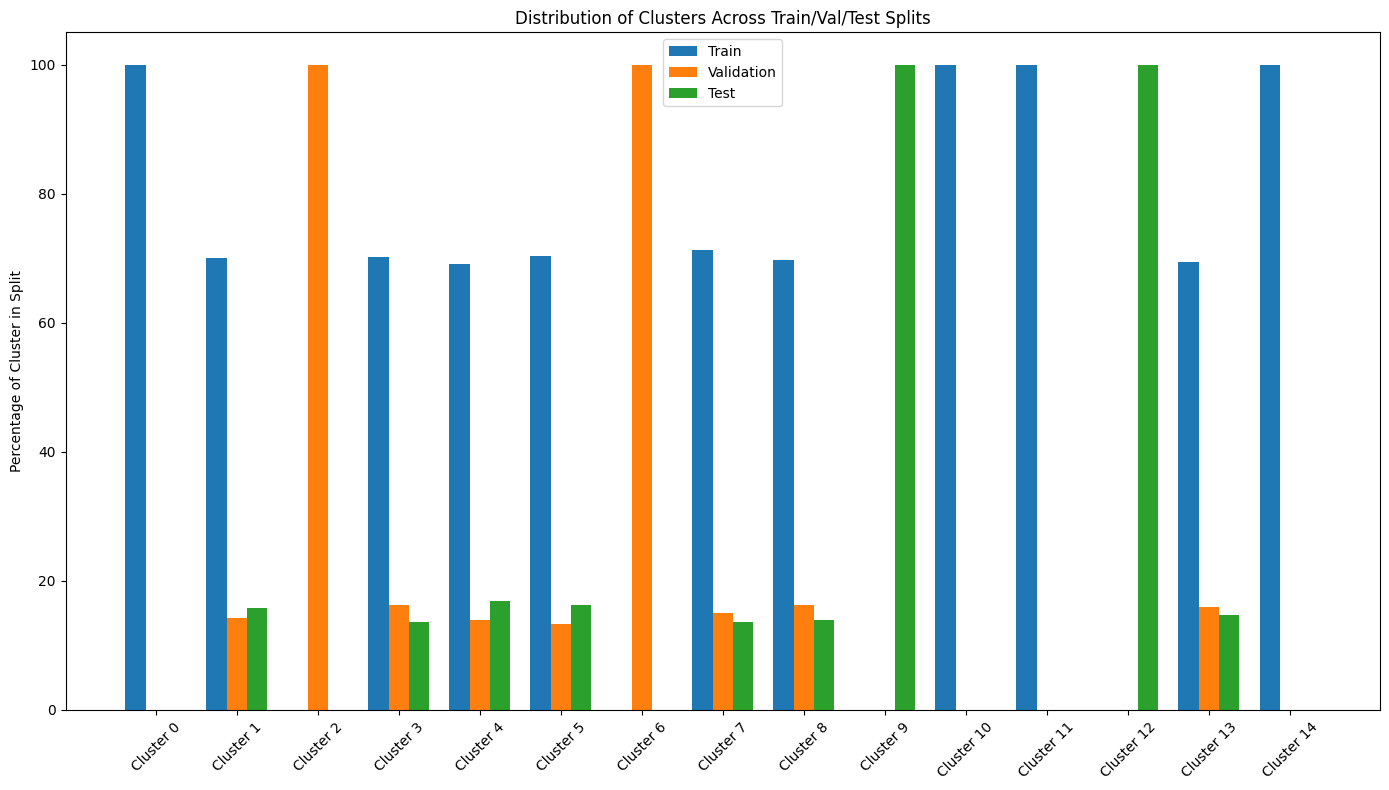

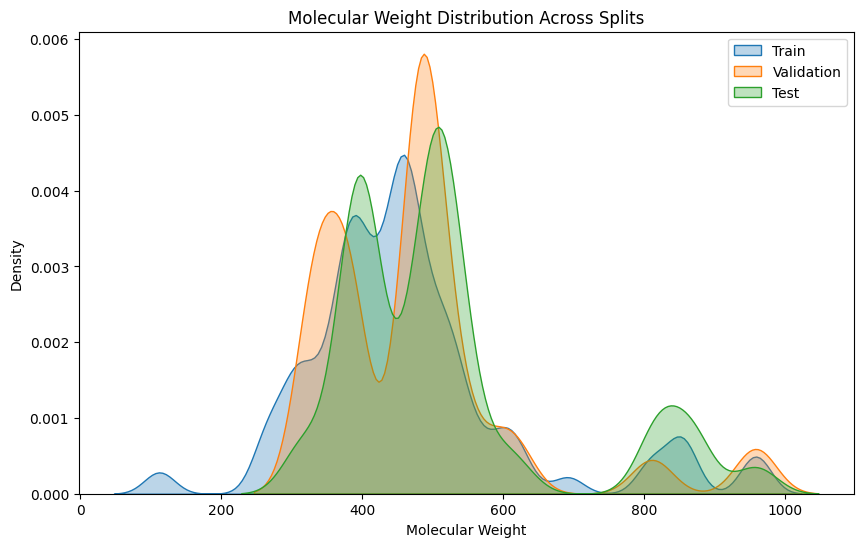

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.cluster import KMeans
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def extract_monomer(smiles):
    parts = smiles.split('.')
    monomer = [p for p in parts if '[*]' not in p]
    return monomer[0] if monomer else smiles

def smiles_to_morgan_fp(smiles, radius=3, nBits=512):
    monomer = extract_monomer(smiles)
    mol = Chem.MolFromSmiles(monomer)
    if mol is None:
        return None
    fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    return fp_gen.GetFingerprint(mol)

def compute_molecular_weight(smiles):
    monomer = extract_monomer(smiles)
    mol = Chem.MolFromSmiles(monomer)
    if mol is None:
        return None
    return Descriptors.MolWt(mol)

def compute_mw_stats(smiles_list):
    weights = [compute_molecular_weight(s) for s in smiles_list]
    weights = [w for w in weights if w is not None]
    return np.mean(weights) if weights else 0, np.std(weights) if weights else 0

def compute_tanimoto_similarity(fps_list, sample_size=1000):
    if not fps_list or len(fps_list) < 2:
        return 0

    if len(fps_list) > sample_size:
        fps_sample = np.random.choice(fps_list, sample_size, replace=False)
    else:
        fps_sample = fps_list

    similarities = []
    for i in range(len(fps_sample)):
        for j in range(i+1, len(fps_sample)):
            sim = Chem.DataStructs.TanimotoSimilarity(fps_sample[i], fps_sample[j])
            similarities.append(sim)

    return np.mean(similarities) if similarities else 0

def improve_dataset_split(data_path, output_dir, n_clusters=15):
    with open(data_path, 'rb') as f:
        all_pairs = pickle.load(f)
    print(f"Total pairs: {len(all_pairs)}")

    valid_indices, fps = [], []
    for i, pair in enumerate(all_pairs):
        smiles = pair.smiles_string if hasattr(pair, 'smiles_string') else None
        if isinstance(smiles, str):
            fp = smiles_to_morgan_fp(smiles)
            if fp is not None:
                fps.append(fp)
                valid_indices.append(i)

    valid_pairs = [all_pairs[i] for i in valid_indices]
    fp_array = np.zeros((len(fps), 512))
    for i, fp in enumerate(fps):
        ConvertToNumpyArray(fp, fp_array[i])

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    all_clusters = kmeans.fit_predict(fp_array)

    cluster_sizes = {}
    for c in all_clusters:
        if c not in cluster_sizes:
            cluster_sizes[c] = 0
        cluster_sizes[c] += 1

    sorted_clusters = sorted([(k, v) for k, v in cluster_sizes.items()], key=lambda x: x[1], reverse=True)
    cluster_size_order = [k for k, v in sorted_clusters]

    big_clusters = cluster_size_order[:4]
    mid_clusters = cluster_size_order[4:8]
    small_clusters = cluster_size_order[8:]

    train_exclusive_clusters = set(big_clusters[:2] + mid_clusters[:2])
    val_exclusive_clusters = set(mid_clusters[2:4])
    test_exclusive_clusters = set(big_clusters[2:4])
    shared_clusters = set(small_clusters)

    print(f"Train exclusive clusters: {train_exclusive_clusters}")
    print(f"Val exclusive clusters: {val_exclusive_clusters}")
    print(f"Test exclusive clusters: {test_exclusive_clusters}")
    print(f"Shared clusters: {shared_clusters}")

    cluster_to_indices = {i: [] for i in range(n_clusters)}
    for i, cluster in enumerate(all_clusters):
        cluster_to_indices[cluster].append(i)  # Store position in valid_pairs list, not original index

    train_indices = set()
    for cluster in train_exclusive_clusters:
        train_indices.update(cluster_to_indices[cluster])

    val_indices = set()
    for cluster in val_exclusive_clusters:
        val_indices.update(cluster_to_indices[cluster])

    test_indices = set()
    for cluster in test_exclusive_clusters:
        test_indices.update(cluster_to_indices[cluster])

    shared_indices = []
    for cluster in shared_clusters:
        shared_indices.extend(cluster_to_indices[cluster])

    np.random.shuffle(shared_indices)
    total_shared = len(shared_indices)
    train_share = int(0.7 * total_shared)
    val_share = int(0.15 * total_shared)
    test_share = total_shared - train_share - val_share

    train_indices.update(shared_indices[:train_share])
    val_indices.update(shared_indices[train_share:train_share + val_share])
    test_indices.update(shared_indices[train_share + val_share:])

    total_valid = len(valid_pairs)
    desired_train_ratio = 0.7
    desired_val_ratio = 0.15
    desired_test_ratio = 0.15

    train_ratio = len(train_indices) / total_valid
    val_ratio = len(val_indices) / total_valid
    test_ratio = len(test_indices) / total_valid

    print(f"Initial split ratios - Train: {train_ratio:.3f}, Val: {val_ratio:.3f}, Test: {test_ratio:.3f}")

    # Make sure we're only using valid indices (within the range of valid_pairs)
    train_indices = {i for i in train_indices if i < len(valid_pairs)}
    val_indices = {i for i in val_indices if i < len(valid_pairs)}
    test_indices = {i for i in test_indices if i < len(valid_pairs)}

    # Recalculate ratios
    train_ratio = len(train_indices) / total_valid
    val_ratio = len(val_indices) / total_valid
    test_ratio = len(test_indices) / total_valid

    if train_ratio < desired_train_ratio:
        remaining = list(set(range(len(valid_pairs))) - train_indices - val_indices - test_indices)
        needed = int(desired_train_ratio * total_valid) - len(train_indices)
        if needed > 0 and remaining:
            train_indices.update(remaining[:needed])

    if val_ratio < desired_val_ratio:
        remaining = list(set(range(len(valid_pairs))) - train_indices - val_indices - test_indices)
        needed = int(desired_val_ratio * total_valid) - len(val_indices)
        if needed > 0 and remaining:
            val_indices.update(remaining[:needed])

    remaining = list(set(range(len(valid_pairs))) - train_indices - val_indices - test_indices)
    if remaining:
        test_indices.update(remaining)

    train_pairs = [(valid_pairs[i], i) for i in train_indices]
    val_pairs = [(valid_pairs[i], i) for i in val_indices]
    test_pairs = [(valid_pairs[i], i) for i in test_indices]

    print(f"Final split: Train {len(train_pairs)}, Val {len(val_pairs)}, Test {len(test_pairs)}")

    with open(f"{output_dir}/train_pairs.pkl", 'wb') as f:
        pickle.dump([p[0] for p in train_pairs], f)
    with open(f"{output_dir}/val_pairs.pkl", 'wb') as f:
        pickle.dump([p[0] for p in val_pairs], f)
    with open(f"{output_dir}/test_pairs.pkl", 'wb') as f:
        pickle.dump([p[0] for p in test_pairs], f)
    with open(f"{output_dir}/all_clusters.pkl", 'wb') as f:
        pickle.dump(all_clusters, f)

    return train_pairs, val_pairs, test_pairs, all_clusters, cluster_sizes

def evaluate_splits(train_pairs, val_pairs, test_pairs, all_clusters, cluster_sizes, n_clusters=15):
    train_smiles = [pair[0].smiles_string for pair in train_pairs if hasattr(pair[0], 'smiles_string')]
    val_smiles = [pair[0].smiles_string for pair in val_pairs if hasattr(pair[0], 'smiles_string')]
    test_smiles = [pair[0].smiles_string for pair in test_pairs if hasattr(pair[0], 'smiles_string')]

    train_fps = [smiles_to_morgan_fp(s) for s in train_smiles if isinstance(s, str)]
    train_fps = [fp for fp in train_fps if fp is not None]

    val_fps = [smiles_to_morgan_fp(s) for s in val_smiles if isinstance(s, str)]
    val_fps = [fp for fp in val_fps if fp is not None]

    test_fps = [smiles_to_morgan_fp(s) for s in test_smiles if isinstance(s, str)]
    test_fps = [fp for fp in test_fps if fp is not None]

    train_clusters = np.array([all_clusters[pair[1]] for pair in train_pairs])
    val_clusters = np.array([all_clusters[pair[1]] for pair in val_pairs])
    test_clusters = np.array([all_clusters[pair[1]] for pair in test_pairs])

    total_train = len(train_clusters) if train_clusters.size else 0
    total_val = len(val_clusters) if val_clusters.size else 0
    total_test = len(test_clusters) if test_clusters.size else 0

    train_cluster_dist = {i: 0 for i in range(n_clusters)}
    val_cluster_dist = {i: 0 for i in range(n_clusters)}
    test_cluster_dist = {i: 0 for i in range(n_clusters)}

    if train_clusters.size:
        for cluster in train_clusters:
            train_cluster_dist[cluster] += 1
    if val_clusters.size:
        for cluster in val_clusters:
            val_cluster_dist[cluster] += 1
    if test_clusters.size:
        for cluster in test_clusters:
            test_cluster_dist[cluster] += 1

    print("\nPer-Cluster Distribution (Count and Percentage of Total Samples in Each Split):")
    print(f"Total Train Samples: {total_train}, Total Val Samples: {total_val}, Total Test Samples: {total_test}")

    train_pcts = []
    val_pcts = []
    test_pcts = []
    cluster_labels = []

    for cluster in range(n_clusters):
        train_count = train_cluster_dist[cluster]
        val_count = val_cluster_dist[cluster]
        test_count = test_cluster_dist[cluster]
        cluster_total = cluster_sizes.get(cluster, 0)

        train_pct = (train_count / cluster_total * 100) if cluster_total > 0 else 0
        val_pct = (val_count / cluster_total * 100) if cluster_total > 0 else 0
        test_pct = (test_count / cluster_total * 100) if cluster_total > 0 else 0

        train_pcts.append(train_pct)
        val_pcts.append(val_pct)
        test_pcts.append(test_pct)
        cluster_labels.append(f"Cluster {cluster}")

        print(f"Cluster {cluster}: Total {cluster_total}, Train {train_count} ({train_pct:.1f}%), "
              f"Val {val_count} ({val_pct:.1f}%), Test {test_count} ({test_pct:.1f}%)")

    train_set = set(train_clusters) if train_clusters.size else set()
    val_set = set(val_clusters) if val_clusters.size else set()
    test_set = set(test_clusters) if test_clusters.size else set()

    train_cluster_count = len(train_set)
    val_cluster_count = len(val_set)
    test_cluster_count = len(test_set)

    union_train_val = len(train_set | val_set) if (train_set or val_set) else 1
    union_train_test = len(train_set | test_set) if (train_set or test_set) else 1
    union_val_test = len(val_set | test_set) if (val_set or test_set) else 1

    overlap_train_val = len(train_set & val_set)
    overlap_train_test = len(train_set & test_set)
    overlap_val_test = len(val_set & test_set)

    print(f"\nTotal clusters: {n_clusters}")
    print(f"Clusters in Train: {train_cluster_count} ({train_cluster_count/n_clusters*100:.1f}%)")
    print(f"Clusters in Val: {val_cluster_count} ({val_cluster_count/n_clusters*100:.1f}%)")
    print(f"Clusters in Test: {test_cluster_count} ({test_cluster_count/n_clusters*100:.1f}%)")
    print(f"Overlapping clusters (Train & Val): {overlap_train_val} ({overlap_train_val/union_train_val*100:.1f}%)")
    print(f"Overlapping clusters (Train & Test): {overlap_train_test} ({overlap_train_test/union_train_test*100:.1f}%)")
    print(f"Overlapping clusters (Val & Test): {overlap_val_test} ({overlap_val_test/union_val_test*100:.1f}%)")

    # Plot cluster distribution
    plt.figure(figsize=(14, 8))
    width = 0.25
    x = np.arange(len(cluster_labels))

    plt.bar(x - width, train_pcts, width, label='Train')
    plt.bar(x, val_pcts, width, label='Validation')
    plt.bar(x + width, test_pcts, width, label='Test')

    plt.xticks(x, cluster_labels, rotation=45)
    plt.ylabel('Percentage of Cluster in Split')
    plt.title('Distribution of Clusters Across Train/Val/Test Splits')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/cluster_distribution.png")

    # Calculate molecular weight distributions
    train_mw = [compute_molecular_weight(s) for s in train_smiles if isinstance(s, str)]
    train_mw = [mw for mw in train_mw if mw is not None]

    val_mw = [compute_molecular_weight(s) for s in val_smiles if isinstance(s, str)]
    val_mw = [mw for mw in val_mw if mw is not None]

    test_mw = [compute_molecular_weight(s) for s in test_smiles if isinstance(s, str)]
    test_mw = [mw for mw in test_mw if mw is not None]

    # Plot molecular weight distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_mw, label='Train', fill=True, alpha=0.3)
    sns.kdeplot(val_mw, label='Validation', fill=True, alpha=0.3)
    sns.kdeplot(test_mw, label='Test', fill=True, alpha=0.3)
    plt.xlabel('Molecular Weight')
    plt.ylabel('Density')
    plt.title('Molecular Weight Distribution Across Splits')
    plt.legend()
    plt.savefig(f"{output_dir}/molecular_weight_distribution.png")

    metrics = {
        "train_size": total_train,
        "val_size": total_val,
        "test_size": total_test,
        "train_mw_mean": np.mean(train_mw) if train_mw else 0,
        "train_mw_std": np.std(train_mw) if train_mw else 0,
        "val_mw_mean": np.mean(val_mw) if val_mw else 0,
        "val_mw_std": np.std(val_mw) if val_mw else 0,
        "test_mw_mean": np.mean(test_mw) if test_mw else 0,
        "test_mw_std": np.std(test_mw) if test_mw else 0,
        "train_tanimoto_sim": compute_tanimoto_similarity(train_fps),
        "val_tanimoto_sim": compute_tanimoto_similarity(val_fps),
        "test_tanimoto_sim": compute_tanimoto_similarity(test_fps),
        "train_val_cluster_overlap": overlap_train_val / union_train_val if union_train_val else 0,
        "train_test_cluster_overlap": overlap_train_test / union_train_test if union_train_test else 0,
        "val_test_cluster_overlap": overlap_val_test / union_val_test if union_val_test else 0
    }

    return metrics

data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/processed_pairs.pkl"
output_dir = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir_fixed_1"

train_pairs, val_pairs, test_pairs, all_clusters, cluster_sizes = improve_dataset_split(data_path, output_dir, n_clusters=15)
metrics = evaluate_splits(train_pairs, val_pairs, test_pairs, all_clusters, cluster_sizes, n_clusters=15)

print("\nMetrics Summary:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

In [ ]:
!ls  "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/processed_pairs.pkl"

ls: cannot access '/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/processed_pairs.pkl': No such file or directory


In [ ]:
import pickle
import random
from rdkit import Chem
from rdkit.Chem import Draw

def extract_example_smiles_from_clusters(data_path, all_clusters_path, n_samples=3):
    # Load the data
    with open(data_path, 'rb') as f:
        all_pairs = pickle.load(f)

    # Load cluster assignments
    with open(all_clusters_path, 'rb') as f:
        all_clusters = pickle.load(f)

    # Get valid indices (same as in your main code)
    valid_indices = []
    for i, pair in enumerate(all_pairs):
        smiles = pair.smiles_string if hasattr(pair, 'smiles_string') else None
        if isinstance(smiles, str):
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    valid_indices.append(i)
            except:
                pass

    # Create a mapping of valid index positions to cluster assignments
    valid_clusters = all_clusters[:len(valid_indices)]

    # Group SMILES by cluster
    cluster_to_smiles = {}
    for i, cluster in enumerate(valid_clusters):
        if cluster not in cluster_to_smiles:
            cluster_to_smiles[cluster] = []

        smiles = all_pairs[valid_indices[i]].smiles_string if hasattr(all_pairs[valid_indices[i]], 'smiles_string') else None
        if smiles:
            cluster_to_smiles[cluster].append(smiles)

    # Extract unique representative SMILES for each cluster
    cluster_representatives = {}
    for cluster, smiles_list in cluster_to_smiles.items():
        # Get a random sample of unique SMILES (up to n_samples)
        unique_smiles = list(set(smiles_list))
        if len(unique_smiles) > n_samples:
            samples = random.sample(unique_smiles, n_samples)
        else:
            samples = unique_smiles

        cluster_representatives[cluster] = samples

    return cluster_representatives

def print_cluster_smiles(cluster_representatives):
    print("Representative SMILES for each cluster:")
    for cluster, smiles_list in sorted(cluster_representatives.items()):
        print(f"\nCluster {cluster}:")
        for i, smiles in enumerate(smiles_list):
            print(f"  Example {i+1}: {smiles}")

# Specify your paths
data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir/processed_pairs.pkl"
all_clusters_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir_fixed_1/all_clusters.pkl"

# Extract and display representative SMILES from each cluster
cluster_representatives = extract_example_smiles_from_clusters(data_path, all_clusters_path, n_samples=2)
print_cluster_smiles(cluster_representatives)

# Optional: visualize molecules from specific clusters
def visualize_cluster_molecules(cluster_num, smiles_list, n_to_show=5):
    if len(smiles_list) > n_to_show:
        samples = random.sample(smiles_list, n_to_show)
    else:
        samples = smiles_list

    mols = [Chem.MolFromSmiles(s) for s in samples]
    valid_mols = [m for m in mols if m is not None]

    if valid_mols:
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=3, subImgSize=(200, 200),
                                  legends=[f"Mol {i+1}" for i in range(len(valid_mols))])
        return img
    return None

# Example usage:
# Uncomment to visualize molecules from a specific cluster
# For cluster 0 (Train exclusive)
# img = visualize_cluster_molecules(0, cluster_representatives[0])
# display(img)

Representative SMILES for each cluster:

Cluster 0:
  Example 1: CC(C)OC1=NC=C(C=C1)C2=NNC3=C2C=C(C=C3)NC(=O)[C@@]4(CCN(C4)CC(=O)N5CCC(=CC5)C6=CC=C(C=C6)C7=NN(C=N7)C)SC
  Example 2: C1CC(C1)(C2=CC=C(C=C2)C3=C(N4C(=N3)C=CC(=N4)C(=O)N)C5=CC=CC=C5)N

Cluster 1:
  Example 1: CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)[C@@]4(CC)O)C2=NC5=C1C=C(C=C5)OC(=O)N6CCC(CC6)N7CCCCC7

Cluster 2:
  Example 1: CN(C)C/C=C/C(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C3)F)Cl)O[C@H]4CCOC4
  Example 2: CC1=C(C=CC(=C1)NC2=NC=NC3=C2C=C(C=C3)NC4=NC(CO4)(C)C)OC5=CC6=NC=NN6C=C5

Cluster 3:
  Example 1: C[C@@H](CNC1=NC=CC(=N1)C2=CN(N=C2C3=C(C(=CC(=C3)Cl)NS(=O)(=O)C)F)C(C)C)NC(=O)OC

Cluster 4:
  Example 1: CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=C3)NS(=O)(=O)C4=C(C=CC=C4F)F)F

Cluster 5:
  Example 1: CCS(=O)(=O)C1=CC=CC(=C1)C2=CC(=C(C3=C2C4=C(N3)N=CC(=C4)C)C)C(=O)NC5CCN(CC5)C
  Example 2: C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl

Cluster 6:
  Example 1: C1COC2=C(O1)C=CC(=C2)N3C(=O)NN=C3SC4=NC=C(S4)[N+](=O)[O-]
  Ex

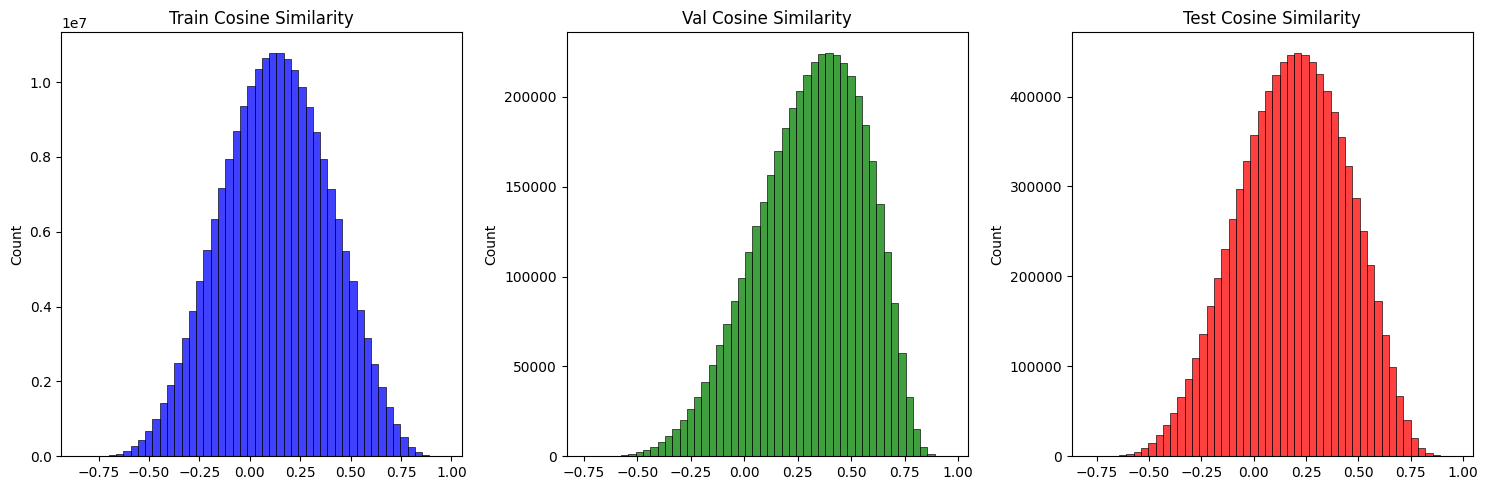

Number of genes with significant differences (p < 0.05):
Train vs Val: 481 (93.9%)
Train vs Test: 432 (84.4%)
Val vs Test: 437 (85.4%)


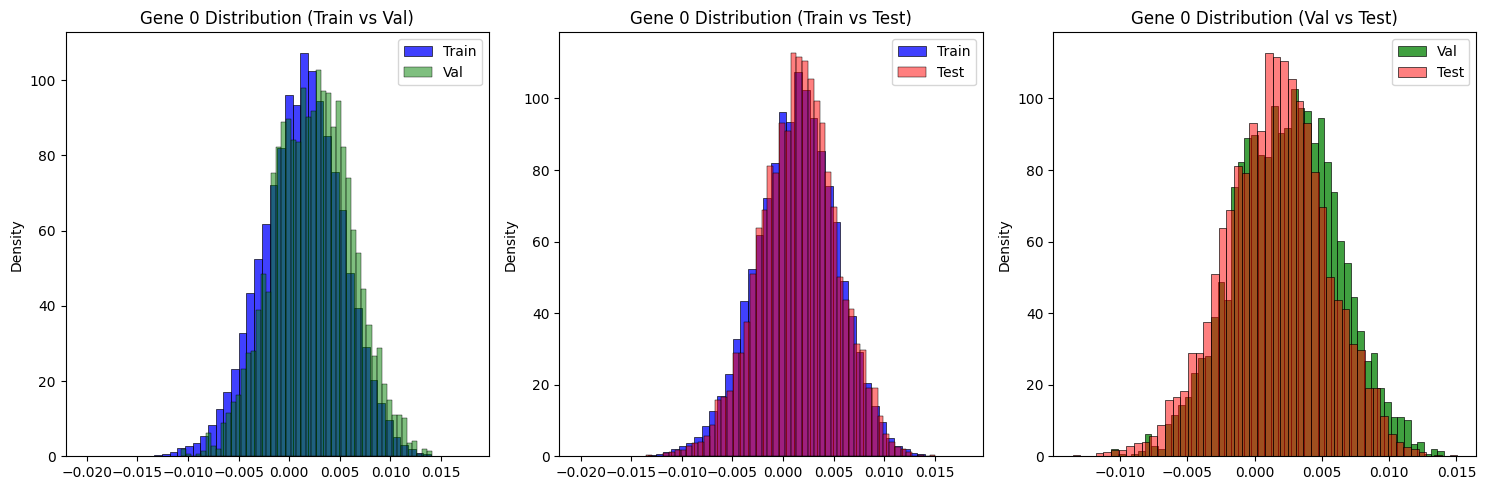

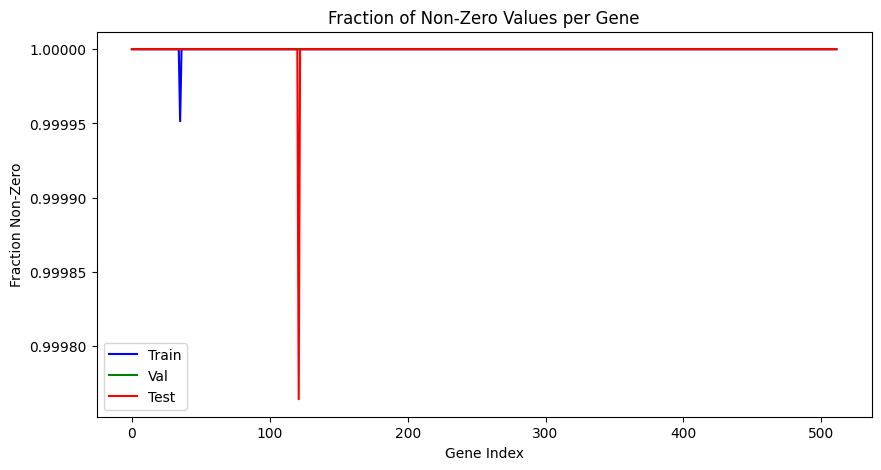

In [ ]:
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

with open("/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir_fixed_1/train_pairs.pkl", 'rb') as f:
    train_pairs = pickle.load(f)
with open("/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir_fixed_1/val_pairs.pkl", 'rb') as f:
    val_pairs = pickle.load(f)
with open("/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir_fixed_1/test_pairs.pkl", 'rb') as f:
    test_pairs = pickle.load(f)

train_embeddings = np.array([pair.cell_embedding for pair in train_pairs if hasattr(pair, 'cell_embedding')])
val_embeddings = np.array([pair.cell_embedding for pair in val_pairs if hasattr(pair, 'cell_embedding')])
test_embeddings = np.array([pair.cell_embedding for pair in test_pairs if hasattr(pair, 'cell_embedding')])

train_cos_sim = cosine_similarity(train_embeddings)
val_cos_sim = cosine_similarity(val_embeddings)
test_cos_sim = cosine_similarity(test_embeddings)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(train_cos_sim[np.triu_indices(len(train_cos_sim), k=1)], bins=50, color='blue', label='Train')
plt.title('Train Cosine Similarity')
plt.subplot(1, 3, 2)
sns.histplot(val_cos_sim[np.triu_indices(len(val_cos_sim), k=1)], bins=50, color='green', label='Val')
plt.title('Val Cosine Similarity')
plt.subplot(1, 3, 3)
sns.histplot(test_cos_sim[np.triu_indices(len(test_cos_sim), k=1)], bins=50, color='red', label='Test')
plt.title('Test Cosine Similarity')
plt.tight_layout()
plt.show()

num_genes = train_embeddings.shape[1]
ks_results = {'train_val': [], 'train_test': [], 'val_test': []}
for gene_idx in range(num_genes):
    train_gene = train_embeddings[:, gene_idx]
    val_gene = val_embeddings[:, gene_idx]
    test_gene = test_embeddings[:, gene_idx]

    ks_stat, p_val = ks_2samp(train_gene, val_gene)
    ks_results['train_val'].append((ks_stat, p_val))

    ks_stat, p_val = ks_2samp(train_gene, test_gene)
    ks_results['train_test'].append((ks_stat, p_val))

    ks_stat, p_val = ks_2samp(val_gene, test_gene)
    ks_results['val_test'].append((ks_stat, p_val))

significant_genes = {
    'train_val': sum(1 for _, p in ks_results['train_val'] if p < 0.05),
    'train_test': sum(1 for _, p in ks_results['train_test'] if p < 0.05),
    'val_test': sum(1 for _, p in ks_results['val_test'] if p < 0.05)
}

print("Number of genes with significant differences (p < 0.05):")
print(f"Train vs Val: {significant_genes['train_val']} ({significant_genes['train_val']/num_genes*100:.1f}%)")
print(f"Train vs Test: {significant_genes['train_test']} ({significant_genes['train_test']/num_genes*100:.1f}%)")
print(f"Val vs Test: {significant_genes['val_test']} ({significant_genes['val_test']/num_genes*100:.1f}%)")

gene_idx = 0
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(train_embeddings[:, gene_idx], bins=50, color='blue', label='Train', stat='density')
sns.histplot(val_embeddings[:, gene_idx], bins=50, color='green', label='Val', stat='density', alpha=0.5)
plt.title(f'Gene {gene_idx} Distribution (Train vs Val)')
plt.legend()
plt.subplot(1, 3, 2)
sns.histplot(train_embeddings[:, gene_idx], bins=50, color='blue', label='Train', stat='density')
sns.histplot(test_embeddings[:, gene_idx], bins=50, color='red', label='Test', stat='density', alpha=0.5)
plt.title(f'Gene {gene_idx} Distribution (Train vs Test)')
plt.legend()
plt.subplot(1, 3, 3)
sns.histplot(val_embeddings[:, gene_idx], bins=50, color='green', label='Val', stat='density')
sns.histplot(test_embeddings[:, gene_idx], bins=50, color='red', label='Test', stat='density', alpha=0.5)
plt.title(f'Gene {gene_idx} Distribution (Val vs Test)')
plt.legend()
plt.tight_layout()
plt.show()

non_zero_train = np.sum(train_embeddings != 0, axis=0) / len(train_embeddings)
non_zero_val = np.sum(val_embeddings != 0, axis=0) / len(val_embeddings)
non_zero_test = np.sum(test_embeddings != 0, axis=0) / len(test_embeddings)

plt.figure(figsize=(10, 5))
plt.plot(non_zero_train, label='Train', color='blue')
plt.plot(non_zero_val, label='Val', color='green')
plt.plot(non_zero_test, label='Test', color='red')
plt.title('Fraction of Non-Zero Values per Gene')
plt.xlabel('Gene Index')
plt.ylabel('Fraction Non-Zero')
plt.legend()
plt.show()

In [ ]:
n_clusters=10

In [ ]:
import numpy as np
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import ConvertToNumpyArray, BulkTanimotoSimilarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import ConvertToNumpyArray, BulkTanimotoSimilarity
from sklearn.cluster import KMeans

def extract_monomer(smiles):
    if smiles.startswith('[*]') and smiles.endswith('[*]'):
        return smiles[3:-3]
    return smiles

def smiles_to_morgan_fp(smiles, radius=2, nBits=1024):
    monomer = extract_monomer(smiles)
    mol = Chem.MolFromSmiles(monomer)
    if mol is None:
        return None
    fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    return fp_gen.GetFingerprint(mol)

def compute_tanimoto_similarity(fps):
    fps = [fp for fp in fps if fp is not None]
    if len(fps) < 2:
        return 0
    tanimoto_sim = []
    for i in range(len(fps)):
        sims = BulkTanimotoSimilarity(fps[i], fps[i+1:])
        tanimoto_sim.extend(sims)
    return np.mean(tanimoto_sim) if tanimoto_sim else 0

def compute_mw_stats(smiles_list):
    mws = [Descriptors.MolWt(Chem.MolFromSmiles(extract_monomer(smiles))) for smiles in smiles_list if Chem.MolFromSmiles(extract_monomer(smiles))]
    return np.mean(mws) if mws else 0, np.std(mws) if mws else 0

def cluster_fingerprints(fps, n_clusters=20):
    valid_fps = [fp for fp in fps if fp is not None]
    if not valid_fps:
        return np.array([]), None
    fps_array = np.zeros((len(valid_fps), 1024))
    for i, fp in enumerate(valid_fps):
        ConvertToNumpyArray(fp, fps_array[i])
    if len(fps_array) < n_clusters:
        n_clusters = len(fps_array)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(fps_array)
    return labels, kmeans.cluster_centers_

def evaluate_splits(train_pairs, val_pairs, test_pairs, n_clusters=10):
    # Compute fingerprints and cluster assignments
    train_smiles = [pair.smiles_string for pair in train_pairs if hasattr(pair, 'smiles_string')]
    val_smiles = [pair.smiles_string for pair in val_pairs if hasattr(pair, 'smiles_string')]
    test_smiles = [pair.smiles_string for pair in test_pairs if hasattr(pair, 'smiles_string')]

    train_fps = [smiles_to_morgan_fp(s) for s in train_smiles if smiles_to_morgan_fp(s) is not None]
    val_fps = [smiles_to_morgan_fp(s) for s in val_smiles if smiles_to_morgan_fp(s) is not None]
    test_fps = [smiles_to_morgan_fp(s) for s in test_smiles if smiles_to_morgan_fp(s) is not None]

    train_clusters, _ = cluster_fingerprints(train_fps, n_clusters)
    val_clusters, _ = cluster_fingerprints(val_fps, n_clusters)
    test_clusters, _ = cluster_fingerprints(test_fps, n_clusters)

    # Total samples in each split
    total_train = len(train_clusters) if train_clusters.size else 0
    total_val = len(val_clusters) if val_clusters.size else 0
    total_test = len(test_clusters) if test_clusters.size else 0

    # Initialize cluster distribution dictionaries
    train_cluster_dist = {i: 0 for i in range(n_clusters)}
    val_cluster_dist = {i: 0 for i in range(n_clusters)}
    test_cluster_dist = {i: 0 for i in range(n_clusters)}

    # Count samples per cluster in each split
    if train_clusters.size:
        for cluster in train_clusters:
            train_cluster_dist[cluster] += 1
    if val_clusters.size:
        for cluster in val_clusters:
            val_cluster_dist[cluster] += 1
    if test_clusters.size:
        for cluster in test_clusters:
            test_cluster_dist[cluster] += 1

    # Print per-cluster distribution
    print("\nPer-Cluster Distribution (Count and Percentage of Total Samples in Each Split):")
    print(f"Total Train Samples: {total_train}, Total Val Samples: {total_val}, Total Test Samples: {total_test}")
    for cluster in range(n_clusters):
        train_count = train_cluster_dist[cluster]
        val_count = val_cluster_dist[cluster]
        test_count = test_cluster_dist[cluster]
        train_pct = (train_count / total_train * 100) if total_train > 0 else 0
        val_pct = (val_count / total_val * 100) if total_val > 0 else 0
        test_pct = (test_count / total_test * 100) if total_test > 0 else 0
        print(f"Cluster {cluster + 1}: Train {train_count} ({train_pct:.1f}%), Val {val_count} ({val_pct:.1f}%), Test {test_count} ({test_pct:.1f}%)")

    # Compute overall overlap metrics
    train_set = set(train_clusters) if train_clusters.size else set()
    val_set = set(val_clusters) if val_clusters.size else set()
    test_set = set(test_clusters) if test_clusters.size else set()

    train_cluster_count = len(train_set)
    val_cluster_count = len(val_set)
    test_cluster_count = len(test_set)

    union_train_val = len(train_set | val_set) if (train_set or val_set) else 1
    union_train_test = len(train_set | test_set) if (train_set or test_set) else 1
    union_val_test = len(val_set | test_set) if (val_set or test_set) else 1

    overlap_train_val = len(train_set & val_set)
    overlap_train_test = len(train_set & test_set)
    overlap_val_test = len(val_set & test_set)

    print(f"\nTotal clusters: {n_clusters}")
    print(f"Clusters in Train: {train_cluster_count} ({train_cluster_count/n_clusters*100:.1f}%)")
    print(f"Clusters in Val: {val_cluster_count} ({val_cluster_count/n_clusters*100:.1f}%)")
    print(f"Clusters in Test: {test_cluster_count} ({test_cluster_count/n_clusters*100:.1f}%)")
    print(f"Overlapping clusters (Train & Val): {overlap_train_val} ({overlap_train_val/union_train_val*100:.1f}%)")
    print(f"Overlapping clusters (Train & Test): {overlap_train_test} ({overlap_train_test/union_train_test*100:.1f}%)")
    print(f"Overlapping clusters (Val & Test): {overlap_val_test} ({overlap_val_test/union_val_test*100:.1f}%)")

    return {
        "train_size": total_train,
        "val_size": total_val,
        "test_size": total_test,
        "train_mw_mean": compute_mw_stats(train_smiles)[0],
        "train_mw_std": compute_mw_stats(train_smiles)[1],
        "val_mw_mean": compute_mw_stats(val_smiles)[0],
        "val_mw_std": compute_mw_stats(val_smiles)[1],
        "test_mw_mean": compute_mw_stats(test_smiles)[0],
        "test_mw_std": compute_mw_stats(test_smiles)[1],
        "train_tanimoto_sim": compute_tanimoto_similarity(train_fps),
        "val_tanimoto_sim": compute_tanimoto_similarity(val_fps),
        "test_tanimoto_sim": compute_tanimoto_similarity(test_fps),
        "train_val_cluster_overlap": overlap_train_val / union_train_val if union_train_val else 0,
        "train_test_cluster_overlap": overlap_train_test / union_train_test if union_train_test else 0,
        "val_test_cluster_overlap": overlap_val_test / union_val_test if union_val_test else 0
    }

def plot_distributions(train_pairs, val_pairs, test_pairs):
    train_smiles = [pair.smiles_string for pair in train_pairs if hasattr(pair, 'smiles_string')]
    val_smiles = [pair.smiles_string for pair in val_pairs if hasattr(pair, 'smiles_string')]
    test_smiles = [pair.smiles_string for pair in test_pairs if hasattr(pair, 'smiles_string')]
    train_mws = [Descriptors.MolWt(Chem.MolFromSmiles(extract_monomer(s))) for s in train_smiles if Chem.MolFromSmiles(extract_monomer(s))]
    val_mws = [Descriptors.MolWt(Chem.MolFromSmiles(extract_monomer(s))) for s in val_smiles if Chem.MolFromSmiles(extract_monomer(s))]
    test_mws = [Descriptors.MolWt(Chem.MolFromSmiles(extract_monomer(s))) for s in test_smiles if Chem.MolFromSmiles(extract_monomer(s))]
    train_fps = [smiles_to_morgan_fp(s) for s in train_smiles if smiles_to_morgan_fp(s) is not None]
    val_fps = [smiles_to_morgan_fp(s) for s in val_smiles if smiles_to_morgan_fp(s) is not None]
    test_fps = [smiles_to_morgan_fp(s) for s in test_smiles if smiles_to_morgan_fp(s) is not None]
    train_clusters, _ = cluster_fingerprints(train_fps)
    val_clusters, _ = cluster_fingerprints(val_fps)
    test_clusters, _ = cluster_fingerprints(test_fps)
    train_cells = np.array([pair.cell_embedding for pair in train_pairs if hasattr(pair, 'cell_embedding')])
    val_cells = np.array([pair.cell_embedding for pair in val_pairs if hasattr(pair, 'cell_embedding')])
    test_cells = np.array([pair.cell_embedding for pair in test_pairs if hasattr(pair, 'cell_embedding')])

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    if train_mws: sns.histplot(train_mws, kde=True, color="blue", label="Train", bins=30)
    if val_mws: sns.histplot(val_mws, kde=True, color="green", label="Val", bins=30)
    if test_mws: sns.histplot(test_mws, kde=True, color="red", label="Test", bins=30)
    plt.xlabel("Molecular Weight")
    plt.ylabel("Count")
    plt.title("Molecular Weight Distribution")
    plt.legend()
    plt.subplot(2, 3, 2)
    if train_clusters.size: sns.histplot(train_clusters, kde=False, color="blue", label="Train", bins=len(set(train_clusters)))
    if val_clusters.size: sns.histplot(val_clusters, kde=False, color="green", label="Val", bins=len(set(val_clusters)))
    if test_clusters.size: sns.histplot(test_clusters, kde=False, color="red", label="Test", bins=len(set(test_clusters)))
    plt.xlabel("Cluster Index")
    plt.ylabel("Count")
    plt.title("Cluster Distribution")
    plt.legend()
    plt.subplot(2, 3, 3)
    train_sim = compute_tanimoto_similarity(train_fps)
    val_sim = compute_tanimoto_similarity(val_fps)
    test_sim = compute_tanimoto_similarity(test_fps)
    sns.barplot(x=["Train", "Val", "Test"], y=[train_sim, val_sim, test_sim], palette=["blue", "green", "red"])
    plt.ylabel("Avg Tanimoto Similarity")
    plt.title("Tanimoto Similarity Across Splits")
    plt.subplot(2, 3, 4)
    if train_cells.size: sns.histplot(train_cells.mean(axis=1), kde=True, color="blue", label="Train")
    if val_cells.size: sns.histplot(val_cells.mean(axis=1), kde=True, color="green", label="Val")
    if test_cells.size: sns.histplot(test_cells.mean(axis=1), kde=True, color="red", label="Test")
    plt.xlabel("Mean Cell Embedding")
    plt.ylabel("Count")
    plt.title("Cell Embedding Distribution")
    plt.legend()
    plt.subplot(2, 3, 5)
    if train_cells.size: sns.histplot(train_cells.std(axis=1), kde=True, color="blue", label="Train")
    if val_cells.size: sns.histplot(val_cells.std(axis=1), kde=True, color="green", label="Val")
    if test_cells.size: sns.histplot(test_cells.std(axis=1), kde=True, color="red", label="Test")
    plt.xlabel("Standard Deviation of Cell Embedding")
    plt.ylabel("Count")
    plt.title("Cell Embedding Variability")
    plt.legend()
    plt.subplot(2, 3, 6)
    train_var = np.var(train_cells, axis=0).sum() if train_cells.size else 0
    val_var = np.var(val_cells, axis=0).sum() if val_cells.size else 0
    test_var = np.var(test_cells, axis=0).sum() if test_cells.size else 0
    sns.barplot(x=["Train", "Val", "Test"], y=[train_var, val_var, test_var], palette=["blue", "green", "red"])
    plt.ylabel("Total Variance")
    plt.title("Variance Captured in Cell Embeddings")
    plt.tight_layout()
    plt.show()

data_path = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_workdir_fixed_1"
with open(f"{data_path}/train_pairs.pkl", 'rb') as f:
    train_pairs = pickle.load(f)
with open(f"{data_path}/val_pairs.pkl", 'rb') as f:
    val_pairs = pickle.load(f)
with open(f"{data_path}/test_pairs.pkl", 'rb') as f:
    test_pairs = pickle.load(f)

metrics = evaluate_splits(train_pairs, val_pairs, test_pairs, n_clusters=10)
for key, value in metrics.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

plot_distributions(train_pairs, val_pairs, test_pairs)

KeyboardInterrupt: 

## sampling arc-dataset plate 3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/esm cell state/")

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/esm cell state/"

 33l_8ep_1024t_1280.torch	 avg_counts_control	    h5ad		    smiles-gpt
 arc_flamingo.ipynb		 avg_counts_filtered	    scgpt_anndata.h5ad	    uce_workdir
'arc virtual cell atlas.ipynb'	 cell			    scGPT_human
 avg_counts			 chemberta_embeddings.pkl   smiles_df.csv
 avg_counts_2			'gb check for data.ipynb'   smiles_embeddings.pkl


In [ ]:
import scanpy as sc

In [ ]:
adata = sc.read_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/scgpt_anndata.h5ad")

In [ ]:
X_scGPT = adata.obsm['X_scGPT']

In [ ]:
print(X_scGPT.shape)

(470494, 512)


In [ ]:
# !rm -rf "/content/drive/MyDrive/Colab Notebooks/esm cell state/difference counts"

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

unique_drugs = adata.obs['drug'].unique()
print(f"Number of unique drugs: {len(unique_drugs)}")
print(unique_drugs)

block_size = 15  # Each block will contain 15 samples
cells_per_drug = {}
for drug in unique_drugs:
    cells_per_drug[drug] = sum(adata.obs['drug'] == drug)
    print(f"Drug {drug}: {cells_per_drug[drug]} cells")

print("Calculating control averages...")
control_data = adata[adata.obs['drug'] == 'DMSO_TF']
# Calculate average for adata.X
control_avg_X = control_data.X.mean(axis=0)
# Calculate average for adata.obsm['X_scGPT']
control_avg_scGPT = control_data.obsm['X_scGPT'].mean(axis=0)

output_dir = "/content/drive/MyDrive/Colab Notebooks/esm cell state/difference counts"
os.makedirs(output_dir, exist_ok=True)

# Calculate how many blocks we'll create
total_blocks = sum([cells_per_drug[drug] // block_size + (1 if cells_per_drug[drug] % block_size > 0 else 0)
                   for drug in unique_drugs if drug != 'DMSO_TF'])
print(f"Total blocks to create: approximately {total_blocks}")

block_counter = 0
for drug in tqdm(unique_drugs, desc="Processing drugs"):
    if drug == 'DMSO_TF':
        continue

    drug_data = adata[adata.obs['drug'] == drug]
    n_cells = drug_data.shape[0]

    # Create blocks of 15 samples each
    n_blocks = n_cells // block_size + (1 if n_cells % block_size > 0 else 0)

    for block_idx in range(n_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, n_cells)

        # Get indices for this block
        block_indices = list(range(start_idx, end_idx))

        block_data = drug_data[block_indices].copy()

        # Calculate difference for adata.X
        block_avg_X = block_data.X.mean(axis=0)
        diff_values_X = block_avg_X - control_avg_X
        block_data.X = diff_values_X.reshape(1, -1).repeat(len(block_indices), axis=0)

        # Calculate difference for adata.obsm['X_scGPT']
        if hasattr(block_data, 'obsm') and 'X_scGPT' in block_data.obsm:
            block_avg_scGPT = block_data.obsm['X_scGPT'].mean(axis=0)
            diff_values_scGPT = block_avg_scGPT - control_avg_scGPT

            # Replace original values with differences
            block_data.obsm['X_scGPT'] = diff_values_scGPT.reshape(1, -1).repeat(len(block_indices), axis=0)

        block_data.write_h5ad(f"{output_dir}/difference_{drug}_block{block_idx+1}.h5ad")

        block_counter += 1
        if block_counter % 10 == 0:
            print(f"Completed {block_counter}/{total_blocks} blocks")

print(f"Processing complete. Created {block_counter} difference files.")

Number of unique drugs: 93
['Infigratinib', 'Erdafitinib ', 'Everolimus', 'Pemigatinib', 'Abemaciclib', ..., 'Oleic acid', 'Minodronic acid', 'Anastrozole', 'Adagrasib', 'DMSO_TF']
Length: 93
Categories (93, object): ['4EGI-1', '9-ING-41', 'APTO-253', 'AT7519', ..., 'olaparib',
                          'palbociclib', 'venetoclax', 'vincristine']
Drug Infigratinib: 5167 cells
Drug Erdafitinib : 5118 cells
Drug Everolimus: 11703 cells
Drug Pemigatinib: 4376 cells
Drug Abemaciclib: 4616 cells
Drug Capivasertib: 3121 cells
Drug Gemcitabine: 7448 cells
Drug Irinotecan: 7988 cells
Drug Oxaliplatin: 4693 cells
Drug Alpelisib: 3652 cells
Drug Lapatinib ditosylate: 7903 cells
Drug palbociclib: 3887 cells
Drug Lonafarnib: 1144 cells
Drug Volasertib: 2556 cells
Drug c-Kit-IN-1: 3283 cells
Drug venetoclax: 3334 cells
Drug Capmatinib: 2998 cells
Drug MK-8353: 3557 cells
Drug Regorafenib: 4533 cells
Drug Tucatinib: 8439 cells
Drug Vemurafenib: 7289 cells
Drug BI-3406: 6913 cells
Drug AZD-8055: 6123

Processing drugs:   0%|          | 0/93 [00:00<?, ?it/s]

Completed 10/30807 blocks
Completed 20/30807 blocks
Completed 30/30807 blocks
Completed 40/30807 blocks
Completed 50/30807 blocks
Completed 60/30807 blocks
Completed 70/30807 blocks
Completed 80/30807 blocks
Completed 90/30807 blocks
Completed 100/30807 blocks
Completed 110/30807 blocks
Completed 120/30807 blocks
Completed 130/30807 blocks
Completed 140/30807 blocks
Completed 150/30807 blocks
Completed 160/30807 blocks
Completed 170/30807 blocks
Completed 180/30807 blocks
Completed 190/30807 blocks
Completed 200/30807 blocks
Completed 210/30807 blocks
Completed 220/30807 blocks
Completed 230/30807 blocks
Completed 240/30807 blocks
Completed 250/30807 blocks
Completed 260/30807 blocks
Completed 270/30807 blocks
Completed 280/30807 blocks
Completed 290/30807 blocks
Completed 300/30807 blocks
Completed 310/30807 blocks
Completed 320/30807 blocks
Completed 330/30807 blocks
Completed 340/30807 blocks


Processing drugs:   1%|          | 1/93 [00:21<32:16, 21.04s/it]

Completed 350/30807 blocks
Completed 360/30807 blocks
Completed 370/30807 blocks
Completed 380/30807 blocks
Completed 390/30807 blocks
Completed 400/30807 blocks
Completed 410/30807 blocks
Completed 420/30807 blocks
Completed 430/30807 blocks
Completed 440/30807 blocks
Completed 450/30807 blocks
Completed 460/30807 blocks
Completed 470/30807 blocks
Completed 480/30807 blocks
Completed 490/30807 blocks
Completed 500/30807 blocks
Completed 510/30807 blocks
Completed 520/30807 blocks
Completed 530/30807 blocks
Completed 540/30807 blocks
Completed 550/30807 blocks
Completed 560/30807 blocks
Completed 570/30807 blocks
Completed 580/30807 blocks
Completed 590/30807 blocks
Completed 600/30807 blocks
Completed 610/30807 blocks
Completed 620/30807 blocks
Completed 630/30807 blocks
Completed 640/30807 blocks
Completed 650/30807 blocks
Completed 660/30807 blocks
Completed 670/30807 blocks
Completed 680/30807 blocks


Processing drugs:   2%|▏         | 2/93 [00:41<31:38, 20.87s/it]

Completed 690/30807 blocks
Completed 700/30807 blocks
Completed 710/30807 blocks
Completed 720/30807 blocks
Completed 730/30807 blocks
Completed 740/30807 blocks
Completed 750/30807 blocks
Completed 760/30807 blocks
Completed 770/30807 blocks
Completed 780/30807 blocks
Completed 790/30807 blocks
Completed 800/30807 blocks
Completed 810/30807 blocks
Completed 820/30807 blocks
Completed 830/30807 blocks
Completed 840/30807 blocks
Completed 850/30807 blocks
Completed 860/30807 blocks
Completed 870/30807 blocks
Completed 880/30807 blocks
Completed 890/30807 blocks
Completed 900/30807 blocks
Completed 910/30807 blocks
Completed 920/30807 blocks
Completed 930/30807 blocks
Completed 940/30807 blocks
Completed 950/30807 blocks
Completed 960/30807 blocks
Completed 970/30807 blocks
Completed 980/30807 blocks
Completed 990/30807 blocks
Completed 1000/30807 blocks
Completed 1010/30807 blocks
Completed 1020/30807 blocks
Completed 1030/30807 blocks
Completed 1040/30807 blocks
Completed 1050/30807 bl

Processing drugs:   3%|▎         | 3/93 [01:30<50:37, 33.75s/it]

Completed 1470/30807 blocks
Completed 1480/30807 blocks
Completed 1490/30807 blocks
Completed 1500/30807 blocks
Completed 1510/30807 blocks
Completed 1520/30807 blocks
Completed 1530/30807 blocks
Completed 1540/30807 blocks
Completed 1550/30807 blocks
Completed 1560/30807 blocks
Completed 1570/30807 blocks
Completed 1580/30807 blocks
Completed 1590/30807 blocks
Completed 1600/30807 blocks
Completed 1610/30807 blocks
Completed 1620/30807 blocks
Completed 1630/30807 blocks
Completed 1640/30807 blocks
Completed 1650/30807 blocks
Completed 1660/30807 blocks
Completed 1670/30807 blocks
Completed 1680/30807 blocks
Completed 1690/30807 blocks
Completed 1700/30807 blocks
Completed 1710/30807 blocks
Completed 1720/30807 blocks
Completed 1730/30807 blocks
Completed 1740/30807 blocks
Completed 1750/30807 blocks


Processing drugs:   4%|▍         | 4/93 [01:48<40:47, 27.50s/it]

Completed 1760/30807 blocks
Completed 1770/30807 blocks
Completed 1780/30807 blocks
Completed 1790/30807 blocks
Completed 1800/30807 blocks
Completed 1810/30807 blocks
Completed 1820/30807 blocks
Completed 1830/30807 blocks
Completed 1840/30807 blocks
Completed 1850/30807 blocks
Completed 1860/30807 blocks
Completed 1870/30807 blocks
Completed 1880/30807 blocks
Completed 1890/30807 blocks
Completed 1900/30807 blocks
Completed 1910/30807 blocks
Completed 1920/30807 blocks
Completed 1930/30807 blocks
Completed 1940/30807 blocks
Completed 1950/30807 blocks
Completed 1960/30807 blocks
Completed 1970/30807 blocks
Completed 1980/30807 blocks
Completed 1990/30807 blocks
Completed 2000/30807 blocks
Completed 2010/30807 blocks
Completed 2020/30807 blocks
Completed 2030/30807 blocks
Completed 2040/30807 blocks
Completed 2050/30807 blocks
Completed 2060/30807 blocks


Processing drugs:   5%|▌         | 5/93 [02:08<35:57, 24.52s/it]

Completed 2070/30807 blocks
Completed 2080/30807 blocks
Completed 2090/30807 blocks
Completed 2100/30807 blocks
Completed 2110/30807 blocks
Completed 2120/30807 blocks
Completed 2130/30807 blocks
Completed 2140/30807 blocks
Completed 2150/30807 blocks
Completed 2160/30807 blocks
Completed 2170/30807 blocks
Completed 2180/30807 blocks
Completed 2190/30807 blocks
Completed 2200/30807 blocks
Completed 2210/30807 blocks
Completed 2220/30807 blocks
Completed 2230/30807 blocks
Completed 2240/30807 blocks
Completed 2250/30807 blocks
Completed 2260/30807 blocks
Completed 2270/30807 blocks


Processing drugs:   6%|▋         | 6/93 [02:21<30:04, 20.74s/it]

Completed 2280/30807 blocks
Completed 2290/30807 blocks
Completed 2300/30807 blocks
Completed 2310/30807 blocks
Completed 2320/30807 blocks
Completed 2330/30807 blocks
Completed 2340/30807 blocks
Completed 2350/30807 blocks
Completed 2360/30807 blocks
Completed 2370/30807 blocks
Completed 2380/30807 blocks
Completed 2390/30807 blocks
Completed 2400/30807 blocks
Completed 2410/30807 blocks
Completed 2420/30807 blocks
Completed 2430/30807 blocks
Completed 2440/30807 blocks
Completed 2450/30807 blocks
Completed 2460/30807 blocks
Completed 2470/30807 blocks
Completed 2480/30807 blocks
Completed 2490/30807 blocks
Completed 2500/30807 blocks
Completed 2510/30807 blocks
Completed 2520/30807 blocks
Completed 2530/30807 blocks
Completed 2540/30807 blocks
Completed 2550/30807 blocks
Completed 2560/30807 blocks
Completed 2570/30807 blocks
Completed 2580/30807 blocks
Completed 2590/30807 blocks
Completed 2600/30807 blocks
Completed 2610/30807 blocks
Completed 2620/30807 blocks
Completed 2630/30807

Processing drugs:   8%|▊         | 7/93 [02:52<34:32, 24.09s/it]

Completed 2780/30807 blocks
Completed 2790/30807 blocks
Completed 2800/30807 blocks
Completed 2810/30807 blocks
Completed 2820/30807 blocks
Completed 2830/30807 blocks
Completed 2840/30807 blocks
Completed 2850/30807 blocks
Completed 2860/30807 blocks
Completed 2870/30807 blocks
Completed 2880/30807 blocks
Completed 2890/30807 blocks
Completed 2900/30807 blocks
Completed 2910/30807 blocks
Completed 2920/30807 blocks
Completed 2930/30807 blocks
Completed 2940/30807 blocks
Completed 2950/30807 blocks
Completed 2960/30807 blocks
Completed 2970/30807 blocks
Completed 2980/30807 blocks
Completed 2990/30807 blocks
Completed 3000/30807 blocks
Completed 3010/30807 blocks
Completed 3020/30807 blocks
Completed 3030/30807 blocks
Completed 3040/30807 blocks
Completed 3050/30807 blocks
Completed 3060/30807 blocks
Completed 3070/30807 blocks
Completed 3080/30807 blocks
Completed 3090/30807 blocks
Completed 3100/30807 blocks
Completed 3110/30807 blocks
Completed 3120/30807 blocks
Completed 3130/30807

Processing drugs:   9%|▊         | 8/93 [03:26<38:26, 27.14s/it]

Completed 3310/30807 blocks
Completed 3320/30807 blocks
Completed 3330/30807 blocks
Completed 3340/30807 blocks
Completed 3350/30807 blocks
Completed 3360/30807 blocks
Completed 3370/30807 blocks
Completed 3380/30807 blocks
Completed 3390/30807 blocks
Completed 3400/30807 blocks
Completed 3410/30807 blocks
Completed 3420/30807 blocks
Completed 3430/30807 blocks
Completed 3440/30807 blocks
Completed 3450/30807 blocks
Completed 3460/30807 blocks
Completed 3470/30807 blocks
Completed 3480/30807 blocks
Completed 3490/30807 blocks
Completed 3500/30807 blocks
Completed 3510/30807 blocks
Completed 3520/30807 blocks
Completed 3530/30807 blocks
Completed 3540/30807 blocks
Completed 3550/30807 blocks
Completed 3560/30807 blocks
Completed 3570/30807 blocks
Completed 3580/30807 blocks
Completed 3590/30807 blocks
Completed 3600/30807 blocks
Completed 3610/30807 blocks


Processing drugs:  10%|▉         | 9/93 [03:45<34:49, 24.87s/it]

Completed 3620/30807 blocks
Completed 3630/30807 blocks
Completed 3640/30807 blocks
Completed 3650/30807 blocks
Completed 3660/30807 blocks
Completed 3670/30807 blocks
Completed 3680/30807 blocks
Completed 3690/30807 blocks
Completed 3700/30807 blocks
Completed 3710/30807 blocks
Completed 3720/30807 blocks
Completed 3730/30807 blocks
Completed 3740/30807 blocks
Completed 3750/30807 blocks
Completed 3760/30807 blocks
Completed 3770/30807 blocks
Completed 3780/30807 blocks
Completed 3790/30807 blocks
Completed 3800/30807 blocks
Completed 3810/30807 blocks
Completed 3820/30807 blocks
Completed 3830/30807 blocks
Completed 3840/30807 blocks
Completed 3850/30807 blocks
Completed 3860/30807 blocks


Processing drugs:  11%|█         | 10/93 [04:01<30:20, 21.93s/it]

Completed 3870/30807 blocks
Completed 3880/30807 blocks
Completed 3890/30807 blocks
Completed 3900/30807 blocks
Completed 3910/30807 blocks
Completed 3920/30807 blocks
Completed 3930/30807 blocks
Completed 3940/30807 blocks
Completed 3950/30807 blocks
Completed 3960/30807 blocks
Completed 3970/30807 blocks
Completed 3980/30807 blocks
Completed 3990/30807 blocks
Completed 4000/30807 blocks
Completed 4010/30807 blocks
Completed 4020/30807 blocks
Completed 4030/30807 blocks
Completed 4040/30807 blocks
Completed 4050/30807 blocks
Completed 4060/30807 blocks
Completed 4070/30807 blocks
Completed 4080/30807 blocks
Completed 4090/30807 blocks
Completed 4100/30807 blocks
Completed 4110/30807 blocks
Completed 4120/30807 blocks
Completed 4130/30807 blocks
Completed 4140/30807 blocks
Completed 4150/30807 blocks
Completed 4160/30807 blocks
Completed 4170/30807 blocks
Completed 4180/30807 blocks
Completed 4190/30807 blocks
Completed 4200/30807 blocks
Completed 4210/30807 blocks
Completed 4220/30807

Processing drugs:  12%|█▏        | 11/93 [04:34<34:31, 25.26s/it]

Completed 4390/30807 blocks
Completed 4400/30807 blocks
Completed 4410/30807 blocks
Completed 4420/30807 blocks
Completed 4430/30807 blocks
Completed 4440/30807 blocks
Completed 4450/30807 blocks
Completed 4460/30807 blocks
Completed 4470/30807 blocks
Completed 4480/30807 blocks
Completed 4490/30807 blocks
Completed 4500/30807 blocks
Completed 4510/30807 blocks
Completed 4520/30807 blocks
Completed 4530/30807 blocks
Completed 4540/30807 blocks
Completed 4550/30807 blocks
Completed 4560/30807 blocks
Completed 4570/30807 blocks
Completed 4580/30807 blocks
Completed 4590/30807 blocks
Completed 4600/30807 blocks
Completed 4610/30807 blocks
Completed 4620/30807 blocks
Completed 4630/30807 blocks
Completed 4640/30807 blocks


Processing drugs:  13%|█▎        | 12/93 [04:50<30:21, 22.48s/it]

Completed 4650/30807 blocks
Completed 4660/30807 blocks
Completed 4670/30807 blocks
Completed 4680/30807 blocks
Completed 4690/30807 blocks
Completed 4700/30807 blocks
Completed 4710/30807 blocks
Completed 4720/30807 blocks


Processing drugs:  14%|█▍        | 13/93 [04:54<22:46, 17.08s/it]

Completed 4730/30807 blocks
Completed 4740/30807 blocks
Completed 4750/30807 blocks
Completed 4760/30807 blocks
Completed 4770/30807 blocks
Completed 4780/30807 blocks
Completed 4790/30807 blocks
Completed 4800/30807 blocks
Completed 4810/30807 blocks
Completed 4820/30807 blocks
Completed 4830/30807 blocks
Completed 4840/30807 blocks
Completed 4850/30807 blocks
Completed 4860/30807 blocks
Completed 4870/30807 blocks
Completed 4880/30807 blocks
Completed 4890/30807 blocks


Processing drugs:  15%|█▌        | 14/93 [05:05<19:53, 15.11s/it]

Completed 4900/30807 blocks
Completed 4910/30807 blocks
Completed 4920/30807 blocks
Completed 4930/30807 blocks
Completed 4940/30807 blocks
Completed 4950/30807 blocks
Completed 4960/30807 blocks
Completed 4970/30807 blocks
Completed 4980/30807 blocks
Completed 4990/30807 blocks
Completed 5000/30807 blocks
Completed 5010/30807 blocks
Completed 5020/30807 blocks
Completed 5030/30807 blocks
Completed 5040/30807 blocks
Completed 5050/30807 blocks
Completed 5060/30807 blocks
Completed 5070/30807 blocks
Completed 5080/30807 blocks
Completed 5090/30807 blocks
Completed 5100/30807 blocks
Completed 5110/30807 blocks


Processing drugs:  16%|█▌        | 15/93 [05:19<19:08, 14.73s/it]

Completed 5120/30807 blocks
Completed 5130/30807 blocks
Completed 5140/30807 blocks
Completed 5150/30807 blocks
Completed 5160/30807 blocks
Completed 5170/30807 blocks
Completed 5180/30807 blocks
Completed 5190/30807 blocks
Completed 5200/30807 blocks
Completed 5210/30807 blocks
Completed 5220/30807 blocks
Completed 5230/30807 blocks
Completed 5240/30807 blocks
Completed 5250/30807 blocks
Completed 5260/30807 blocks
Completed 5270/30807 blocks
Completed 5280/30807 blocks
Completed 5290/30807 blocks
Completed 5300/30807 blocks
Completed 5310/30807 blocks
Completed 5320/30807 blocks
Completed 5330/30807 blocks


Processing drugs:  17%|█▋        | 16/93 [05:33<18:31, 14.44s/it]

Completed 5340/30807 blocks
Completed 5350/30807 blocks
Completed 5360/30807 blocks
Completed 5370/30807 blocks
Completed 5380/30807 blocks
Completed 5390/30807 blocks
Completed 5400/30807 blocks
Completed 5410/30807 blocks
Completed 5420/30807 blocks
Completed 5430/30807 blocks
Completed 5440/30807 blocks
Completed 5450/30807 blocks
Completed 5460/30807 blocks
Completed 5470/30807 blocks
Completed 5480/30807 blocks
Completed 5490/30807 blocks
Completed 5500/30807 blocks
Completed 5510/30807 blocks
Completed 5520/30807 blocks
Completed 5530/30807 blocks


Processing drugs:  18%|█▊        | 17/93 [05:45<17:42, 13.98s/it]

Completed 5540/30807 blocks
Completed 5550/30807 blocks
Completed 5560/30807 blocks
Completed 5570/30807 blocks
Completed 5580/30807 blocks
Completed 5590/30807 blocks
Completed 5600/30807 blocks
Completed 5610/30807 blocks
Completed 5620/30807 blocks
Completed 5630/30807 blocks
Completed 5640/30807 blocks
Completed 5650/30807 blocks
Completed 5660/30807 blocks
Completed 5670/30807 blocks
Completed 5680/30807 blocks
Completed 5690/30807 blocks
Completed 5700/30807 blocks
Completed 5710/30807 blocks
Completed 5720/30807 blocks
Completed 5730/30807 blocks
Completed 5740/30807 blocks
Completed 5750/30807 blocks
Completed 5760/30807 blocks
Completed 5770/30807 blocks


Processing drugs:  19%|█▉        | 18/93 [06:00<17:50, 14.28s/it]

Completed 5780/30807 blocks
Completed 5790/30807 blocks
Completed 5800/30807 blocks
Completed 5810/30807 blocks
Completed 5820/30807 blocks
Completed 5830/30807 blocks
Completed 5840/30807 blocks
Completed 5850/30807 blocks
Completed 5860/30807 blocks
Completed 5870/30807 blocks
Completed 5880/30807 blocks
Completed 5890/30807 blocks
Completed 5900/30807 blocks
Completed 5910/30807 blocks
Completed 5920/30807 blocks
Completed 5930/30807 blocks
Completed 5940/30807 blocks
Completed 5950/30807 blocks
Completed 5960/30807 blocks
Completed 5970/30807 blocks
Completed 5980/30807 blocks
Completed 5990/30807 blocks
Completed 6000/30807 blocks
Completed 6010/30807 blocks
Completed 6020/30807 blocks
Completed 6030/30807 blocks
Completed 6040/30807 blocks
Completed 6050/30807 blocks
Completed 6060/30807 blocks
Completed 6070/30807 blocks


Processing drugs:  20%|██        | 19/93 [06:19<19:12, 15.57s/it]

Completed 6080/30807 blocks
Completed 6090/30807 blocks
Completed 6100/30807 blocks
Completed 6110/30807 blocks
Completed 6120/30807 blocks
Completed 6130/30807 blocks
Completed 6140/30807 blocks
Completed 6150/30807 blocks
Completed 6160/30807 blocks
Completed 6170/30807 blocks
Completed 6180/30807 blocks
Completed 6190/30807 blocks
Completed 6200/30807 blocks
Completed 6210/30807 blocks
Completed 6220/30807 blocks
Completed 6230/30807 blocks
Completed 6240/30807 blocks
Completed 6250/30807 blocks
Completed 6260/30807 blocks
Completed 6270/30807 blocks
Completed 6280/30807 blocks
Completed 6290/30807 blocks
Completed 6300/30807 blocks
Completed 6310/30807 blocks
Completed 6320/30807 blocks
Completed 6330/30807 blocks
Completed 6340/30807 blocks
Completed 6350/30807 blocks
Completed 6360/30807 blocks
Completed 6370/30807 blocks
Completed 6380/30807 blocks
Completed 6390/30807 blocks
Completed 6400/30807 blocks
Completed 6410/30807 blocks
Completed 6420/30807 blocks
Completed 6430/30807

Processing drugs:  22%|██▏       | 20/93 [06:54<26:03, 21.41s/it]

Completed 6650/30807 blocks
Completed 6660/30807 blocks
Completed 6670/30807 blocks
Completed 6680/30807 blocks
Completed 6690/30807 blocks
Completed 6700/30807 blocks
Completed 6710/30807 blocks
Completed 6720/30807 blocks
Completed 6730/30807 blocks
Completed 6740/30807 blocks
Completed 6750/30807 blocks
Completed 6760/30807 blocks
Completed 6770/30807 blocks
Completed 6780/30807 blocks
Completed 6790/30807 blocks
Completed 6800/30807 blocks
Completed 6810/30807 blocks
Completed 6820/30807 blocks
Completed 6830/30807 blocks
Completed 6840/30807 blocks
Completed 6850/30807 blocks
Completed 6860/30807 blocks
Completed 6870/30807 blocks
Completed 6880/30807 blocks
Completed 6890/30807 blocks
Completed 6900/30807 blocks
Completed 6910/30807 blocks
Completed 6920/30807 blocks
Completed 6930/30807 blocks
Completed 6940/30807 blocks
Completed 6950/30807 blocks
Completed 6960/30807 blocks
Completed 6970/30807 blocks
Completed 6980/30807 blocks
Completed 6990/30807 blocks
Completed 7000/30807

Processing drugs:  23%|██▎       | 21/93 [07:24<28:43, 23.94s/it]

Completed 7130/30807 blocks
Completed 7140/30807 blocks
Completed 7150/30807 blocks
Completed 7160/30807 blocks
Completed 7170/30807 blocks
Completed 7180/30807 blocks
Completed 7190/30807 blocks
Completed 7200/30807 blocks
Completed 7210/30807 blocks
Completed 7220/30807 blocks
Completed 7230/30807 blocks
Completed 7240/30807 blocks
Completed 7250/30807 blocks
Completed 7260/30807 blocks
Completed 7270/30807 blocks
Completed 7280/30807 blocks
Completed 7290/30807 blocks
Completed 7300/30807 blocks
Completed 7310/30807 blocks
Completed 7320/30807 blocks
Completed 7330/30807 blocks
Completed 7340/30807 blocks
Completed 7350/30807 blocks
Completed 7360/30807 blocks
Completed 7370/30807 blocks
Completed 7380/30807 blocks
Completed 7390/30807 blocks
Completed 7400/30807 blocks
Completed 7410/30807 blocks
Completed 7420/30807 blocks
Completed 7430/30807 blocks
Completed 7440/30807 blocks
Completed 7450/30807 blocks
Completed 7460/30807 blocks
Completed 7470/30807 blocks
Completed 7480/30807

Processing drugs:  24%|██▎       | 22/93 [07:53<30:04, 25.41s/it]

Completed 7590/30807 blocks
Completed 7600/30807 blocks
Completed 7610/30807 blocks
Completed 7620/30807 blocks
Completed 7630/30807 blocks
Completed 7640/30807 blocks
Completed 7650/30807 blocks
Completed 7660/30807 blocks
Completed 7670/30807 blocks
Completed 7680/30807 blocks
Completed 7690/30807 blocks
Completed 7700/30807 blocks
Completed 7710/30807 blocks
Completed 7720/30807 blocks
Completed 7730/30807 blocks
Completed 7740/30807 blocks
Completed 7750/30807 blocks
Completed 7760/30807 blocks
Completed 7770/30807 blocks
Completed 7780/30807 blocks
Completed 7790/30807 blocks
Completed 7800/30807 blocks
Completed 7810/30807 blocks
Completed 7820/30807 blocks
Completed 7830/30807 blocks
Completed 7840/30807 blocks
Completed 7850/30807 blocks
Completed 7860/30807 blocks
Completed 7870/30807 blocks
Completed 7880/30807 blocks
Completed 7890/30807 blocks
Completed 7900/30807 blocks
Completed 7910/30807 blocks
Completed 7920/30807 blocks
Completed 7930/30807 blocks
Completed 7940/30807

Processing drugs:  25%|██▍       | 23/93 [08:18<29:40, 25.44s/it]

Completed 8000/30807 blocks
Completed 8010/30807 blocks
Completed 8020/30807 blocks
Completed 8030/30807 blocks
Completed 8040/30807 blocks
Completed 8050/30807 blocks
Completed 8060/30807 blocks
Completed 8070/30807 blocks
Completed 8080/30807 blocks
Completed 8090/30807 blocks
Completed 8100/30807 blocks
Completed 8110/30807 blocks
Completed 8120/30807 blocks
Completed 8130/30807 blocks
Completed 8140/30807 blocks
Completed 8150/30807 blocks
Completed 8160/30807 blocks
Completed 8170/30807 blocks
Completed 8180/30807 blocks
Completed 8190/30807 blocks


Processing drugs:  26%|██▌       | 24/93 [08:30<24:40, 21.46s/it]

Completed 8200/30807 blocks
Completed 8210/30807 blocks
Completed 8220/30807 blocks
Completed 8230/30807 blocks
Completed 8240/30807 blocks
Completed 8250/30807 blocks
Completed 8260/30807 blocks
Completed 8270/30807 blocks
Completed 8280/30807 blocks
Completed 8290/30807 blocks
Completed 8300/30807 blocks
Completed 8310/30807 blocks
Completed 8320/30807 blocks
Completed 8330/30807 blocks
Completed 8340/30807 blocks
Completed 8350/30807 blocks
Completed 8360/30807 blocks
Completed 8370/30807 blocks
Completed 8380/30807 blocks
Completed 8390/30807 blocks
Completed 8400/30807 blocks
Completed 8410/30807 blocks
Completed 8420/30807 blocks
Completed 8430/30807 blocks
Completed 8440/30807 blocks
Completed 8450/30807 blocks
Completed 8460/30807 blocks
Completed 8470/30807 blocks
Completed 8480/30807 blocks
Completed 8490/30807 blocks
Completed 8500/30807 blocks
Completed 8510/30807 blocks
Completed 8520/30807 blocks
Completed 8530/30807 blocks
Completed 8540/30807 blocks
Completed 8550/30807

Processing drugs:  27%|██▋       | 25/93 [08:54<25:05, 22.14s/it]

Completed 8580/30807 blocks
Completed 8590/30807 blocks
Completed 8600/30807 blocks
Completed 8610/30807 blocks
Completed 8620/30807 blocks
Completed 8630/30807 blocks
Completed 8640/30807 blocks
Completed 8650/30807 blocks
Completed 8660/30807 blocks
Completed 8670/30807 blocks
Completed 8680/30807 blocks
Completed 8690/30807 blocks
Completed 8700/30807 blocks
Completed 8710/30807 blocks
Completed 8720/30807 blocks
Completed 8730/30807 blocks
Completed 8740/30807 blocks
Completed 8750/30807 blocks
Completed 8760/30807 blocks
Completed 8770/30807 blocks
Completed 8780/30807 blocks
Completed 8790/30807 blocks
Completed 8800/30807 blocks
Completed 8810/30807 blocks
Completed 8820/30807 blocks
Completed 8830/30807 blocks
Completed 8840/30807 blocks
Completed 8850/30807 blocks
Completed 8860/30807 blocks
Completed 8870/30807 blocks
Completed 8880/30807 blocks
Completed 8890/30807 blocks
Completed 8900/30807 blocks
Completed 8910/30807 blocks
Completed 8920/30807 blocks
Completed 8930/30807

Processing drugs:  28%|██▊       | 26/93 [09:19<25:36, 22.94s/it]

Completed 8990/30807 blocks
Completed 9000/30807 blocks
Completed 9010/30807 blocks
Completed 9020/30807 blocks
Completed 9030/30807 blocks
Completed 9040/30807 blocks
Completed 9050/30807 blocks
Completed 9060/30807 blocks
Completed 9070/30807 blocks
Completed 9080/30807 blocks
Completed 9090/30807 blocks
Completed 9100/30807 blocks
Completed 9110/30807 blocks
Completed 9120/30807 blocks
Completed 9130/30807 blocks
Completed 9140/30807 blocks
Completed 9150/30807 blocks
Completed 9160/30807 blocks
Completed 9170/30807 blocks
Completed 9180/30807 blocks
Completed 9190/30807 blocks
Completed 9200/30807 blocks
Completed 9210/30807 blocks
Completed 9220/30807 blocks
Completed 9230/30807 blocks
Completed 9240/30807 blocks
Completed 9250/30807 blocks
Completed 9260/30807 blocks
Completed 9270/30807 blocks
Completed 9280/30807 blocks
Completed 9290/30807 blocks
Completed 9300/30807 blocks
Completed 9310/30807 blocks
Completed 9320/30807 blocks
Completed 9330/30807 blocks
Completed 9340/30807

Processing drugs:  29%|██▉       | 27/93 [09:50<27:56, 25.40s/it]

Completed 9480/30807 blocks
Completed 9490/30807 blocks
Completed 9500/30807 blocks
Completed 9510/30807 blocks
Completed 9520/30807 blocks
Completed 9530/30807 blocks
Completed 9540/30807 blocks
Completed 9550/30807 blocks
Completed 9560/30807 blocks
Completed 9570/30807 blocks
Completed 9580/30807 blocks
Completed 9590/30807 blocks
Completed 9600/30807 blocks
Completed 9610/30807 blocks
Completed 9620/30807 blocks
Completed 9630/30807 blocks
Completed 9640/30807 blocks
Completed 9650/30807 blocks
Completed 9660/30807 blocks
Completed 9670/30807 blocks
Completed 9680/30807 blocks
Completed 9690/30807 blocks
Completed 9700/30807 blocks
Completed 9710/30807 blocks
Completed 9720/30807 blocks
Completed 9730/30807 blocks
Completed 9740/30807 blocks
Completed 9750/30807 blocks
Completed 9760/30807 blocks
Completed 9770/30807 blocks
Completed 9780/30807 blocks
Completed 9790/30807 blocks
Completed 9800/30807 blocks
Completed 9810/30807 blocks
Completed 9820/30807 blocks
Completed 9830/30807

Processing drugs:  30%|███       | 28/93 [10:15<27:11, 25.10s/it]

Completed 9870/30807 blocks
Completed 9880/30807 blocks
Completed 9890/30807 blocks
Completed 9900/30807 blocks
Completed 9910/30807 blocks
Completed 9920/30807 blocks
Completed 9930/30807 blocks
Completed 9940/30807 blocks
Completed 9950/30807 blocks
Completed 9960/30807 blocks
Completed 9970/30807 blocks
Completed 9980/30807 blocks
Completed 9990/30807 blocks
Completed 10000/30807 blocks
Completed 10010/30807 blocks
Completed 10020/30807 blocks
Completed 10030/30807 blocks
Completed 10040/30807 blocks
Completed 10050/30807 blocks
Completed 10060/30807 blocks
Completed 10070/30807 blocks
Completed 10080/30807 blocks
Completed 10090/30807 blocks
Completed 10100/30807 blocks
Completed 10110/30807 blocks
Completed 10120/30807 blocks
Completed 10130/30807 blocks
Completed 10140/30807 blocks
Completed 10150/30807 blocks
Completed 10160/30807 blocks
Completed 10170/30807 blocks
Completed 10180/30807 blocks
Completed 10190/30807 blocks
Completed 10200/30807 blocks
Completed 10210/30807 block

Processing drugs:  31%|███       | 29/93 [10:49<29:39, 27.80s/it]

Completed 10420/30807 blocks
Completed 10430/30807 blocks
Completed 10440/30807 blocks
Completed 10450/30807 blocks
Completed 10460/30807 blocks
Completed 10470/30807 blocks
Completed 10480/30807 blocks
Completed 10490/30807 blocks
Completed 10500/30807 blocks
Completed 10510/30807 blocks
Completed 10520/30807 blocks
Completed 10530/30807 blocks
Completed 10540/30807 blocks
Completed 10550/30807 blocks
Completed 10560/30807 blocks
Completed 10570/30807 blocks
Completed 10580/30807 blocks
Completed 10590/30807 blocks
Completed 10600/30807 blocks
Completed 10610/30807 blocks
Completed 10620/30807 blocks
Completed 10630/30807 blocks
Completed 10640/30807 blocks
Completed 10650/30807 blocks
Completed 10660/30807 blocks
Completed 10670/30807 blocks
Completed 10680/30807 blocks
Completed 10690/30807 blocks
Completed 10700/30807 blocks
Completed 10710/30807 blocks
Completed 10720/30807 blocks
Completed 10730/30807 blocks
Completed 10740/30807 blocks
Completed 10750/30807 blocks
Completed 1076

Processing drugs:  32%|███▏      | 30/93 [11:13<28:07, 26.78s/it]

Completed 10820/30807 blocks
Completed 10830/30807 blocks
Completed 10840/30807 blocks
Completed 10850/30807 blocks
Completed 10860/30807 blocks
Completed 10870/30807 blocks
Completed 10880/30807 blocks
Completed 10890/30807 blocks
Completed 10900/30807 blocks
Completed 10910/30807 blocks
Completed 10920/30807 blocks
Completed 10930/30807 blocks
Completed 10940/30807 blocks
Completed 10950/30807 blocks
Completed 10960/30807 blocks
Completed 10970/30807 blocks
Completed 10980/30807 blocks
Completed 10990/30807 blocks
Completed 11000/30807 blocks
Completed 11010/30807 blocks
Completed 11020/30807 blocks
Completed 11030/30807 blocks
Completed 11040/30807 blocks
Completed 11050/30807 blocks
Completed 11060/30807 blocks
Completed 11070/30807 blocks
Completed 11080/30807 blocks
Completed 11090/30807 blocks
Completed 11100/30807 blocks
Completed 11110/30807 blocks
Completed 11120/30807 blocks
Completed 11130/30807 blocks
Completed 11140/30807 blocks
Completed 11150/30807 blocks
Completed 1116

Processing drugs:  33%|███▎      | 31/93 [12:05<35:23, 34.25s/it]

Completed 11650/30807 blocks
Completed 11660/30807 blocks
Completed 11670/30807 blocks
Completed 11680/30807 blocks
Completed 11690/30807 blocks
Completed 11700/30807 blocks
Completed 11710/30807 blocks
Completed 11720/30807 blocks
Completed 11730/30807 blocks
Completed 11740/30807 blocks
Completed 11750/30807 blocks
Completed 11760/30807 blocks
Completed 11770/30807 blocks
Completed 11780/30807 blocks
Completed 11790/30807 blocks
Completed 11800/30807 blocks
Completed 11810/30807 blocks
Completed 11820/30807 blocks
Completed 11830/30807 blocks
Completed 11840/30807 blocks
Completed 11850/30807 blocks
Completed 11860/30807 blocks
Completed 11870/30807 blocks
Completed 11880/30807 blocks
Completed 11890/30807 blocks
Completed 11900/30807 blocks
Completed 11910/30807 blocks
Completed 11920/30807 blocks
Completed 11930/30807 blocks
Completed 11940/30807 blocks
Completed 11950/30807 blocks
Completed 11960/30807 blocks
Completed 11970/30807 blocks
Completed 11980/30807 blocks
Completed 1199

Processing drugs:  34%|███▍      | 32/93 [12:53<39:02, 38.40s/it]

Completed 12430/30807 blocks
Completed 12440/30807 blocks
Completed 12450/30807 blocks
Completed 12460/30807 blocks
Completed 12470/30807 blocks
Completed 12480/30807 blocks
Completed 12490/30807 blocks
Completed 12500/30807 blocks
Completed 12510/30807 blocks
Completed 12520/30807 blocks
Completed 12530/30807 blocks
Completed 12540/30807 blocks
Completed 12550/30807 blocks
Completed 12560/30807 blocks
Completed 12570/30807 blocks
Completed 12580/30807 blocks
Completed 12590/30807 blocks
Completed 12600/30807 blocks
Completed 12610/30807 blocks
Completed 12620/30807 blocks
Completed 12630/30807 blocks
Completed 12640/30807 blocks
Completed 12650/30807 blocks
Completed 12660/30807 blocks
Completed 12670/30807 blocks
Completed 12680/30807 blocks
Completed 12690/30807 blocks
Completed 12700/30807 blocks
Completed 12710/30807 blocks
Completed 12720/30807 blocks
Completed 12730/30807 blocks
Completed 12740/30807 blocks
Completed 12750/30807 blocks
Completed 12760/30807 blocks
Completed 1277

Processing drugs:  35%|███▌      | 33/93 [13:41<41:22, 41.38s/it]

Completed 13190/30807 blocks
Completed 13200/30807 blocks
Completed 13210/30807 blocks
Completed 13220/30807 blocks
Completed 13230/30807 blocks
Completed 13240/30807 blocks
Completed 13250/30807 blocks
Completed 13260/30807 blocks
Completed 13270/30807 blocks
Completed 13280/30807 blocks
Completed 13290/30807 blocks
Completed 13300/30807 blocks
Completed 13310/30807 blocks
Completed 13320/30807 blocks
Completed 13330/30807 blocks
Completed 13340/30807 blocks
Completed 13350/30807 blocks
Completed 13360/30807 blocks
Completed 13370/30807 blocks
Completed 13380/30807 blocks
Completed 13390/30807 blocks
Completed 13400/30807 blocks
Completed 13410/30807 blocks
Completed 13420/30807 blocks
Completed 13430/30807 blocks
Completed 13440/30807 blocks
Completed 13450/30807 blocks
Completed 13460/30807 blocks
Completed 13470/30807 blocks
Completed 13480/30807 blocks
Completed 13490/30807 blocks
Completed 13500/30807 blocks
Completed 13510/30807 blocks
Completed 13520/30807 blocks
Completed 1353

Processing drugs:  37%|███▋      | 34/93 [14:20<40:04, 40.75s/it]

Completed 13830/30807 blocks
Completed 13840/30807 blocks
Completed 13850/30807 blocks
Completed 13860/30807 blocks
Completed 13870/30807 blocks
Completed 13880/30807 blocks
Completed 13890/30807 blocks
Completed 13900/30807 blocks
Completed 13910/30807 blocks
Completed 13920/30807 blocks
Completed 13930/30807 blocks
Completed 13940/30807 blocks
Completed 13950/30807 blocks
Completed 13960/30807 blocks
Completed 13970/30807 blocks
Completed 13980/30807 blocks
Completed 13990/30807 blocks
Completed 14000/30807 blocks
Completed 14010/30807 blocks
Completed 14020/30807 blocks
Completed 14030/30807 blocks
Completed 14040/30807 blocks
Completed 14050/30807 blocks
Completed 14060/30807 blocks
Completed 14070/30807 blocks
Completed 14080/30807 blocks
Completed 14090/30807 blocks
Completed 14100/30807 blocks
Completed 14110/30807 blocks
Completed 14120/30807 blocks
Completed 14130/30807 blocks
Completed 14140/30807 blocks
Completed 14150/30807 blocks
Completed 14160/30807 blocks
Completed 1417

Processing drugs:  38%|███▊      | 35/93 [14:55<37:37, 38.93s/it]

Completed 14390/30807 blocks
Completed 14400/30807 blocks
Completed 14410/30807 blocks
Completed 14420/30807 blocks
Completed 14430/30807 blocks
Completed 14440/30807 blocks
Completed 14450/30807 blocks
Completed 14460/30807 blocks
Completed 14470/30807 blocks
Completed 14480/30807 blocks
Completed 14490/30807 blocks
Completed 14500/30807 blocks
Completed 14510/30807 blocks
Completed 14520/30807 blocks
Completed 14530/30807 blocks
Completed 14540/30807 blocks
Completed 14550/30807 blocks
Completed 14560/30807 blocks
Completed 14570/30807 blocks
Completed 14580/30807 blocks
Completed 14590/30807 blocks
Completed 14600/30807 blocks
Completed 14610/30807 blocks
Completed 14620/30807 blocks
Completed 14630/30807 blocks
Completed 14640/30807 blocks
Completed 14650/30807 blocks
Completed 14660/30807 blocks
Completed 14670/30807 blocks
Completed 14680/30807 blocks
Completed 14690/30807 blocks
Completed 14700/30807 blocks
Completed 14710/30807 blocks
Completed 14720/30807 blocks
Completed 1473

Processing drugs:  39%|███▊      | 36/93 [15:28<35:17, 37.15s/it]

Completed 14930/30807 blocks
Completed 14940/30807 blocks
Completed 14950/30807 blocks
Completed 14960/30807 blocks
Completed 14970/30807 blocks
Completed 14980/30807 blocks
Completed 14990/30807 blocks
Completed 15000/30807 blocks
Completed 15010/30807 blocks
Completed 15020/30807 blocks
Completed 15030/30807 blocks
Completed 15040/30807 blocks
Completed 15050/30807 blocks
Completed 15060/30807 blocks
Completed 15070/30807 blocks
Completed 15080/30807 blocks
Completed 15090/30807 blocks
Completed 15100/30807 blocks
Completed 15110/30807 blocks
Completed 15120/30807 blocks
Completed 15130/30807 blocks
Completed 15140/30807 blocks
Completed 15150/30807 blocks
Completed 15160/30807 blocks
Completed 15170/30807 blocks
Completed 15180/30807 blocks
Completed 15190/30807 blocks


Processing drugs:  40%|███▉      | 37/93 [15:44<28:45, 30.82s/it]

Completed 15200/30807 blocks
Completed 15210/30807 blocks
Completed 15220/30807 blocks
Completed 15230/30807 blocks
Completed 15240/30807 blocks
Completed 15250/30807 blocks
Completed 15260/30807 blocks
Completed 15270/30807 blocks
Completed 15280/30807 blocks
Completed 15290/30807 blocks
Completed 15300/30807 blocks
Completed 15310/30807 blocks
Completed 15320/30807 blocks
Completed 15330/30807 blocks
Completed 15340/30807 blocks
Completed 15350/30807 blocks
Completed 15360/30807 blocks
Completed 15370/30807 blocks
Completed 15380/30807 blocks
Completed 15390/30807 blocks
Completed 15400/30807 blocks
Completed 15410/30807 blocks
Completed 15420/30807 blocks
Completed 15430/30807 blocks
Completed 15440/30807 blocks
Completed 15450/30807 blocks
Completed 15460/30807 blocks
Completed 15470/30807 blocks
Completed 15480/30807 blocks
Completed 15490/30807 blocks
Completed 15500/30807 blocks
Completed 15510/30807 blocks
Completed 15520/30807 blocks
Completed 15530/30807 blocks


Processing drugs:  41%|████      | 38/93 [16:06<25:47, 28.14s/it]

Completed 15540/30807 blocks
Completed 15550/30807 blocks
Completed 15560/30807 blocks
Completed 15570/30807 blocks
Completed 15580/30807 blocks
Completed 15590/30807 blocks
Completed 15600/30807 blocks
Completed 15610/30807 blocks
Completed 15620/30807 blocks
Completed 15630/30807 blocks
Completed 15640/30807 blocks
Completed 15650/30807 blocks
Completed 15660/30807 blocks
Completed 15670/30807 blocks
Completed 15680/30807 blocks
Completed 15690/30807 blocks
Completed 15700/30807 blocks
Completed 15710/30807 blocks
Completed 15720/30807 blocks
Completed 15730/30807 blocks
Completed 15740/30807 blocks
Completed 15750/30807 blocks
Completed 15760/30807 blocks
Completed 15770/30807 blocks
Completed 15780/30807 blocks
Completed 15790/30807 blocks
Completed 15800/30807 blocks
Completed 15810/30807 blocks
Completed 15820/30807 blocks
Completed 15830/30807 blocks
Completed 15840/30807 blocks
Completed 15850/30807 blocks
Completed 15860/30807 blocks
Completed 15870/30807 blocks
Completed 1588

Processing drugs:  42%|████▏     | 39/93 [16:45<28:09, 31.28s/it]

Completed 16170/30807 blocks
Completed 16180/30807 blocks
Completed 16190/30807 blocks
Completed 16200/30807 blocks
Completed 16210/30807 blocks
Completed 16220/30807 blocks
Completed 16230/30807 blocks
Completed 16240/30807 blocks
Completed 16250/30807 blocks
Completed 16260/30807 blocks
Completed 16270/30807 blocks
Completed 16280/30807 blocks
Completed 16290/30807 blocks
Completed 16300/30807 blocks
Completed 16310/30807 blocks
Completed 16320/30807 blocks
Completed 16330/30807 blocks
Completed 16340/30807 blocks
Completed 16350/30807 blocks
Completed 16360/30807 blocks
Completed 16370/30807 blocks
Completed 16380/30807 blocks
Completed 16390/30807 blocks
Completed 16400/30807 blocks
Completed 16410/30807 blocks
Completed 16420/30807 blocks
Completed 16430/30807 blocks
Completed 16440/30807 blocks
Completed 16450/30807 blocks
Completed 16460/30807 blocks


Processing drugs:  43%|████▎     | 40/93 [17:04<24:22, 27.60s/it]

Completed 16470/30807 blocks
Completed 16480/30807 blocks
Completed 16490/30807 blocks
Completed 16500/30807 blocks
Completed 16510/30807 blocks
Completed 16520/30807 blocks
Completed 16530/30807 blocks
Completed 16540/30807 blocks
Completed 16550/30807 blocks
Completed 16560/30807 blocks
Completed 16570/30807 blocks
Completed 16580/30807 blocks
Completed 16590/30807 blocks
Completed 16600/30807 blocks
Completed 16610/30807 blocks
Completed 16620/30807 blocks
Completed 16630/30807 blocks
Completed 16640/30807 blocks
Completed 16650/30807 blocks
Completed 16660/30807 blocks
Completed 16670/30807 blocks
Completed 16680/30807 blocks
Completed 16690/30807 blocks
Completed 16700/30807 blocks
Completed 16710/30807 blocks
Completed 16720/30807 blocks
Completed 16730/30807 blocks
Completed 16740/30807 blocks
Completed 16750/30807 blocks
Completed 16760/30807 blocks
Completed 16770/30807 blocks
Completed 16780/30807 blocks
Completed 16790/30807 blocks
Completed 16800/30807 blocks
Completed 1681

Processing drugs:  44%|████▍     | 41/93 [17:31<23:53, 27.57s/it]

Completed 16920/30807 blocks
Completed 16930/30807 blocks
Completed 16940/30807 blocks
Completed 16950/30807 blocks
Completed 16960/30807 blocks
Completed 16970/30807 blocks
Completed 16980/30807 blocks
Completed 16990/30807 blocks
Completed 17000/30807 blocks
Completed 17010/30807 blocks
Completed 17020/30807 blocks
Completed 17030/30807 blocks
Completed 17040/30807 blocks
Completed 17050/30807 blocks
Completed 17060/30807 blocks
Completed 17070/30807 blocks
Completed 17080/30807 blocks
Completed 17090/30807 blocks
Completed 17100/30807 blocks
Completed 17110/30807 blocks
Completed 17120/30807 blocks
Completed 17130/30807 blocks
Completed 17140/30807 blocks
Completed 17150/30807 blocks
Completed 17160/30807 blocks
Completed 17170/30807 blocks
Completed 17180/30807 blocks
Completed 17190/30807 blocks
Completed 17200/30807 blocks
Completed 17210/30807 blocks
Completed 17220/30807 blocks
Completed 17230/30807 blocks
Completed 17240/30807 blocks
Completed 17250/30807 blocks
Completed 1726

Processing drugs:  45%|████▌     | 42/93 [18:10<26:24, 31.08s/it]

Completed 17560/30807 blocks
Completed 17570/30807 blocks
Completed 17580/30807 blocks
Completed 17590/30807 blocks
Completed 17600/30807 blocks
Completed 17610/30807 blocks
Completed 17620/30807 blocks
Completed 17630/30807 blocks
Completed 17640/30807 blocks
Completed 17650/30807 blocks
Completed 17660/30807 blocks
Completed 17670/30807 blocks
Completed 17680/30807 blocks
Completed 17690/30807 blocks
Completed 17700/30807 blocks
Completed 17710/30807 blocks
Completed 17720/30807 blocks
Completed 17730/30807 blocks
Completed 17740/30807 blocks
Completed 17750/30807 blocks
Completed 17760/30807 blocks
Completed 17770/30807 blocks
Completed 17780/30807 blocks
Completed 17790/30807 blocks
Completed 17800/30807 blocks
Completed 17810/30807 blocks
Completed 17820/30807 blocks
Completed 17830/30807 blocks
Completed 17840/30807 blocks
Completed 17850/30807 blocks
Completed 17860/30807 blocks
Completed 17870/30807 blocks
Completed 17880/30807 blocks
Completed 17890/30807 blocks
Completed 1790

Processing drugs:  46%|████▌     | 43/93 [18:53<28:41, 34.43s/it]

Completed 18230/30807 blocks
Completed 18240/30807 blocks
Completed 18250/30807 blocks
Completed 18260/30807 blocks
Completed 18270/30807 blocks
Completed 18280/30807 blocks
Completed 18290/30807 blocks
Completed 18300/30807 blocks
Completed 18310/30807 blocks
Completed 18320/30807 blocks
Completed 18330/30807 blocks
Completed 18340/30807 blocks
Completed 18350/30807 blocks
Completed 18360/30807 blocks
Completed 18370/30807 blocks
Completed 18380/30807 blocks
Completed 18390/30807 blocks
Completed 18400/30807 blocks
Completed 18410/30807 blocks
Completed 18420/30807 blocks
Completed 18430/30807 blocks
Completed 18440/30807 blocks
Completed 18450/30807 blocks
Completed 18460/30807 blocks
Completed 18470/30807 blocks
Completed 18480/30807 blocks
Completed 18490/30807 blocks
Completed 18500/30807 blocks
Completed 18510/30807 blocks
Completed 18520/30807 blocks
Completed 18530/30807 blocks
Completed 18540/30807 blocks
Completed 18550/30807 blocks
Completed 18560/30807 blocks
Completed 1857

Processing drugs:  47%|████▋     | 44/93 [19:32<29:26, 36.06s/it]

Completed 18880/30807 blocks
Completed 18890/30807 blocks
Completed 18900/30807 blocks
Completed 18910/30807 blocks
Completed 18920/30807 blocks
Completed 18930/30807 blocks
Completed 18940/30807 blocks
Completed 18950/30807 blocks
Completed 18960/30807 blocks
Completed 18970/30807 blocks
Completed 18980/30807 blocks
Completed 18990/30807 blocks
Completed 19000/30807 blocks
Completed 19010/30807 blocks
Completed 19020/30807 blocks
Completed 19030/30807 blocks
Completed 19040/30807 blocks
Completed 19050/30807 blocks
Completed 19060/30807 blocks
Completed 19070/30807 blocks
Completed 19080/30807 blocks
Completed 19090/30807 blocks
Completed 19100/30807 blocks
Completed 19110/30807 blocks
Completed 19120/30807 blocks
Completed 19130/30807 blocks
Completed 19140/30807 blocks
Completed 19150/30807 blocks
Completed 19160/30807 blocks
Completed 19170/30807 blocks
Completed 19180/30807 blocks
Completed 19190/30807 blocks
Completed 19200/30807 blocks
Completed 19210/30807 blocks
Completed 1922

Processing drugs:  48%|████▊     | 45/93 [20:14<30:10, 37.72s/it]

Completed 19550/30807 blocks
Completed 19560/30807 blocks
Completed 19570/30807 blocks
Completed 19580/30807 blocks
Completed 19590/30807 blocks
Completed 19600/30807 blocks
Completed 19610/30807 blocks
Completed 19620/30807 blocks
Completed 19630/30807 blocks
Completed 19640/30807 blocks
Completed 19650/30807 blocks
Completed 19660/30807 blocks
Completed 19670/30807 blocks
Completed 19680/30807 blocks
Completed 19690/30807 blocks
Completed 19700/30807 blocks
Completed 19710/30807 blocks
Completed 19720/30807 blocks
Completed 19730/30807 blocks
Completed 19740/30807 blocks
Completed 19750/30807 blocks
Completed 19760/30807 blocks
Completed 19770/30807 blocks
Completed 19780/30807 blocks
Completed 19790/30807 blocks
Completed 19800/30807 blocks
Completed 19810/30807 blocks
Completed 19820/30807 blocks
Completed 19830/30807 blocks
Completed 19840/30807 blocks
Completed 19850/30807 blocks
Completed 19860/30807 blocks
Completed 19870/30807 blocks
Completed 19880/30807 blocks
Completed 1989

Processing drugs:  49%|████▉     | 46/93 [20:50<29:02, 37.07s/it]

Completed 20120/30807 blocks
Completed 20130/30807 blocks
Completed 20140/30807 blocks
Completed 20150/30807 blocks
Completed 20160/30807 blocks
Completed 20170/30807 blocks
Completed 20180/30807 blocks
Completed 20190/30807 blocks
Completed 20200/30807 blocks
Completed 20210/30807 blocks
Completed 20220/30807 blocks
Completed 20230/30807 blocks
Completed 20240/30807 blocks
Completed 20250/30807 blocks
Completed 20260/30807 blocks
Completed 20270/30807 blocks
Completed 20280/30807 blocks
Completed 20290/30807 blocks
Completed 20300/30807 blocks
Completed 20310/30807 blocks
Completed 20320/30807 blocks
Completed 20330/30807 blocks
Completed 20340/30807 blocks
Completed 20350/30807 blocks
Completed 20360/30807 blocks
Completed 20370/30807 blocks
Completed 20380/30807 blocks
Completed 20390/30807 blocks
Completed 20400/30807 blocks
Completed 20410/30807 blocks
Completed 20420/30807 blocks
Completed 20430/30807 blocks
Completed 20440/30807 blocks
Completed 20450/30807 blocks
Completed 2046

Processing drugs:  51%|█████     | 47/93 [21:30<29:16, 38.19s/it]

Completed 20780/30807 blocks
Completed 20790/30807 blocks
Completed 20800/30807 blocks
Completed 20810/30807 blocks
Completed 20820/30807 blocks
Completed 20830/30807 blocks
Completed 20840/30807 blocks
Completed 20850/30807 blocks
Completed 20860/30807 blocks
Completed 20870/30807 blocks
Completed 20880/30807 blocks
Completed 20890/30807 blocks
Completed 20900/30807 blocks
Completed 20910/30807 blocks
Completed 20920/30807 blocks
Completed 20930/30807 blocks
Completed 20940/30807 blocks
Completed 20950/30807 blocks
Completed 20960/30807 blocks
Completed 20970/30807 blocks
Completed 20980/30807 blocks
Completed 20990/30807 blocks
Completed 21000/30807 blocks
Completed 21010/30807 blocks
Completed 21020/30807 blocks
Completed 21030/30807 blocks
Completed 21040/30807 blocks
Completed 21050/30807 blocks
Completed 21060/30807 blocks
Completed 21070/30807 blocks
Completed 21080/30807 blocks
Completed 21090/30807 blocks
Completed 21100/30807 blocks
Completed 21110/30807 blocks
Completed 2112

Processing drugs:  52%|█████▏    | 48/93 [22:04<27:40, 36.91s/it]

Completed 21330/30807 blocks
Completed 21340/30807 blocks
Completed 21350/30807 blocks
Completed 21360/30807 blocks
Completed 21370/30807 blocks
Completed 21380/30807 blocks
Completed 21390/30807 blocks
Completed 21400/30807 blocks
Completed 21410/30807 blocks
Completed 21420/30807 blocks
Completed 21430/30807 blocks
Completed 21440/30807 blocks
Completed 21450/30807 blocks


Processing drugs:  53%|█████▎    | 49/93 [22:12<20:38, 28.15s/it]

Completed 21460/30807 blocks
Completed 21470/30807 blocks
Completed 21480/30807 blocks
Completed 21490/30807 blocks
Completed 21500/30807 blocks
Completed 21510/30807 blocks
Completed 21520/30807 blocks
Completed 21530/30807 blocks
Completed 21540/30807 blocks
Completed 21550/30807 blocks
Completed 21560/30807 blocks
Completed 21570/30807 blocks
Completed 21580/30807 blocks
Completed 21590/30807 blocks
Completed 21600/30807 blocks
Completed 21610/30807 blocks


Processing drugs:  54%|█████▍    | 50/93 [22:22<16:12, 22.63s/it]

Completed 21620/30807 blocks
Completed 21630/30807 blocks
Completed 21640/30807 blocks
Completed 21650/30807 blocks
Completed 21660/30807 blocks
Completed 21670/30807 blocks
Completed 21680/30807 blocks
Completed 21690/30807 blocks
Completed 21700/30807 blocks
Completed 21710/30807 blocks
Completed 21720/30807 blocks
Completed 21730/30807 blocks
Completed 21740/30807 blocks
Completed 21750/30807 blocks
Completed 21760/30807 blocks
Completed 21770/30807 blocks


Processing drugs:  55%|█████▍    | 51/93 [22:32<13:11, 18.84s/it]

Completed 21780/30807 blocks
Completed 21790/30807 blocks
Completed 21800/30807 blocks
Completed 21810/30807 blocks
Completed 21820/30807 blocks
Completed 21830/30807 blocks
Completed 21840/30807 blocks
Completed 21850/30807 blocks
Completed 21860/30807 blocks
Completed 21870/30807 blocks
Completed 21880/30807 blocks
Completed 21890/30807 blocks
Completed 21900/30807 blocks
Completed 21910/30807 blocks
Completed 21920/30807 blocks
Completed 21930/30807 blocks
Completed 21940/30807 blocks
Completed 21950/30807 blocks
Completed 21960/30807 blocks
Completed 21970/30807 blocks
Completed 21980/30807 blocks
Completed 21990/30807 blocks


Processing drugs:  56%|█████▌    | 52/93 [22:46<11:50, 17.33s/it]

Completed 22000/30807 blocks
Completed 22010/30807 blocks
Completed 22020/30807 blocks
Completed 22030/30807 blocks
Completed 22040/30807 blocks
Completed 22050/30807 blocks
Completed 22060/30807 blocks
Completed 22070/30807 blocks
Completed 22080/30807 blocks
Completed 22090/30807 blocks


Processing drugs:  57%|█████▋    | 53/93 [22:52<09:17, 13.95s/it]

Completed 22100/30807 blocks
Completed 22110/30807 blocks
Completed 22120/30807 blocks
Completed 22130/30807 blocks
Completed 22140/30807 blocks
Completed 22150/30807 blocks
Completed 22160/30807 blocks
Completed 22170/30807 blocks
Completed 22180/30807 blocks
Completed 22190/30807 blocks
Completed 22200/30807 blocks
Completed 22210/30807 blocks
Completed 22220/30807 blocks
Completed 22230/30807 blocks
Completed 22240/30807 blocks


Processing drugs:  58%|█████▊    | 54/93 [23:01<08:12, 12.63s/it]

Completed 22250/30807 blocks
Completed 22260/30807 blocks
Completed 22270/30807 blocks
Completed 22280/30807 blocks
Completed 22290/30807 blocks
Completed 22300/30807 blocks
Completed 22310/30807 blocks
Completed 22320/30807 blocks
Completed 22330/30807 blocks
Completed 22340/30807 blocks
Completed 22350/30807 blocks
Completed 22360/30807 blocks
Completed 22370/30807 blocks
Completed 22380/30807 blocks
Completed 22390/30807 blocks
Completed 22400/30807 blocks
Completed 22410/30807 blocks
Completed 22420/30807 blocks
Completed 22430/30807 blocks
Completed 22440/30807 blocks
Completed 22450/30807 blocks
Completed 22460/30807 blocks
Completed 22470/30807 blocks
Completed 22480/30807 blocks
Completed 22490/30807 blocks
Completed 22500/30807 blocks


Processing drugs:  59%|█████▉    | 55/93 [23:17<08:40, 13.71s/it]

Completed 22510/30807 blocks
Completed 22520/30807 blocks
Completed 22530/30807 blocks
Completed 22540/30807 blocks
Completed 22550/30807 blocks
Completed 22560/30807 blocks
Completed 22570/30807 blocks
Completed 22580/30807 blocks
Completed 22590/30807 blocks
Completed 22600/30807 blocks
Completed 22610/30807 blocks
Completed 22620/30807 blocks
Completed 22630/30807 blocks
Completed 22640/30807 blocks
Completed 22650/30807 blocks
Completed 22660/30807 blocks
Completed 22670/30807 blocks
Completed 22680/30807 blocks
Completed 22690/30807 blocks
Completed 22700/30807 blocks
Completed 22710/30807 blocks
Completed 22720/30807 blocks
Completed 22730/30807 blocks


Processing drugs:  60%|██████    | 56/93 [23:32<08:34, 13.92s/it]

Completed 22740/30807 blocks
Completed 22750/30807 blocks
Completed 22760/30807 blocks
Completed 22770/30807 blocks
Completed 22780/30807 blocks
Completed 22790/30807 blocks
Completed 22800/30807 blocks
Completed 22810/30807 blocks
Completed 22820/30807 blocks
Completed 22830/30807 blocks
Completed 22840/30807 blocks
Completed 22850/30807 blocks
Completed 22860/30807 blocks
Completed 22870/30807 blocks
Completed 22880/30807 blocks
Completed 22890/30807 blocks
Completed 22900/30807 blocks
Completed 22910/30807 blocks
Completed 22920/30807 blocks


Processing drugs:  61%|██████▏   | 57/93 [23:44<08:02, 13.41s/it]

Completed 22930/30807 blocks
Completed 22940/30807 blocks
Completed 22950/30807 blocks
Completed 22960/30807 blocks
Completed 22970/30807 blocks
Completed 22980/30807 blocks
Completed 22990/30807 blocks
Completed 23000/30807 blocks
Completed 23010/30807 blocks
Completed 23020/30807 blocks
Completed 23030/30807 blocks
Completed 23040/30807 blocks
Completed 23050/30807 blocks
Completed 23060/30807 blocks
Completed 23070/30807 blocks
Completed 23080/30807 blocks
Completed 23090/30807 blocks
Completed 23100/30807 blocks
Completed 23110/30807 blocks
Completed 23120/30807 blocks


Processing drugs:  62%|██████▏   | 58/93 [23:56<07:32, 12.93s/it]

Completed 23130/30807 blocks
Completed 23140/30807 blocks
Completed 23150/30807 blocks
Completed 23160/30807 blocks
Completed 23170/30807 blocks
Completed 23180/30807 blocks
Completed 23190/30807 blocks
Completed 23200/30807 blocks
Completed 23210/30807 blocks
Completed 23220/30807 blocks
Completed 23230/30807 blocks
Completed 23240/30807 blocks
Completed 23250/30807 blocks
Completed 23260/30807 blocks
Completed 23270/30807 blocks
Completed 23280/30807 blocks
Completed 23290/30807 blocks
Completed 23300/30807 blocks
Completed 23310/30807 blocks
Completed 23320/30807 blocks


Processing drugs:  63%|██████▎   | 59/93 [24:09<07:18, 12.89s/it]

Completed 23330/30807 blocks
Completed 23340/30807 blocks
Completed 23350/30807 blocks
Completed 23360/30807 blocks
Completed 23370/30807 blocks
Completed 23380/30807 blocks
Completed 23390/30807 blocks
Completed 23400/30807 blocks
Completed 23410/30807 blocks
Completed 23420/30807 blocks
Completed 23430/30807 blocks


Processing drugs:  65%|██████▍   | 60/93 [24:15<05:59, 10.90s/it]

Completed 23440/30807 blocks
Completed 23450/30807 blocks
Completed 23460/30807 blocks
Completed 23470/30807 blocks
Completed 23480/30807 blocks
Completed 23490/30807 blocks
Completed 23500/30807 blocks
Completed 23510/30807 blocks
Completed 23520/30807 blocks
Completed 23530/30807 blocks
Completed 23540/30807 blocks
Completed 23550/30807 blocks
Completed 23560/30807 blocks
Completed 23570/30807 blocks
Completed 23580/30807 blocks
Completed 23590/30807 blocks


Processing drugs:  66%|██████▌   | 61/93 [24:25<05:39, 10.61s/it]

Completed 23600/30807 blocks
Completed 23610/30807 blocks
Completed 23620/30807 blocks
Completed 23630/30807 blocks
Completed 23640/30807 blocks
Completed 23650/30807 blocks
Completed 23660/30807 blocks
Completed 23670/30807 blocks
Completed 23680/30807 blocks
Completed 23690/30807 blocks
Completed 23700/30807 blocks
Completed 23710/30807 blocks
Completed 23720/30807 blocks
Completed 23730/30807 blocks
Completed 23740/30807 blocks
Completed 23750/30807 blocks
Completed 23760/30807 blocks
Completed 23770/30807 blocks
Completed 23780/30807 blocks
Completed 23790/30807 blocks
Completed 23800/30807 blocks
Completed 23810/30807 blocks


Processing drugs:  67%|██████▋   | 62/93 [24:39<05:59, 11.61s/it]

Completed 23820/30807 blocks
Completed 23830/30807 blocks
Completed 23840/30807 blocks
Completed 23850/30807 blocks
Completed 23860/30807 blocks
Completed 23870/30807 blocks
Completed 23880/30807 blocks
Completed 23890/30807 blocks
Completed 23900/30807 blocks
Completed 23910/30807 blocks
Completed 23920/30807 blocks
Completed 23930/30807 blocks
Completed 23940/30807 blocks
Completed 23950/30807 blocks
Completed 23960/30807 blocks
Completed 23970/30807 blocks
Completed 23980/30807 blocks
Completed 23990/30807 blocks
Completed 24000/30807 blocks


Processing drugs:  68%|██████▊   | 63/93 [24:51<05:49, 11.66s/it]

Completed 24010/30807 blocks
Completed 24020/30807 blocks
Completed 24030/30807 blocks
Completed 24040/30807 blocks
Completed 24050/30807 blocks
Completed 24060/30807 blocks
Completed 24070/30807 blocks
Completed 24080/30807 blocks
Completed 24090/30807 blocks
Completed 24100/30807 blocks
Completed 24110/30807 blocks
Completed 24120/30807 blocks
Completed 24130/30807 blocks
Completed 24140/30807 blocks
Completed 24150/30807 blocks
Completed 24160/30807 blocks
Completed 24170/30807 blocks
Completed 24180/30807 blocks


Processing drugs:  69%|██████▉   | 64/93 [25:02<05:34, 11.55s/it]

Completed 24190/30807 blocks
Completed 24200/30807 blocks
Completed 24210/30807 blocks
Completed 24220/30807 blocks
Completed 24230/30807 blocks
Completed 24240/30807 blocks
Completed 24250/30807 blocks
Completed 24260/30807 blocks
Completed 24270/30807 blocks
Completed 24280/30807 blocks
Completed 24290/30807 blocks
Completed 24300/30807 blocks
Completed 24310/30807 blocks
Completed 24320/30807 blocks
Completed 24330/30807 blocks
Completed 24340/30807 blocks
Completed 24350/30807 blocks


Processing drugs:  70%|██████▉   | 65/93 [25:12<05:11, 11.11s/it]

Completed 24360/30807 blocks
Completed 24370/30807 blocks
Completed 24380/30807 blocks
Completed 24390/30807 blocks
Completed 24400/30807 blocks
Completed 24410/30807 blocks
Completed 24420/30807 blocks
Completed 24430/30807 blocks
Completed 24440/30807 blocks
Completed 24450/30807 blocks
Completed 24460/30807 blocks
Completed 24470/30807 blocks
Completed 24480/30807 blocks
Completed 24490/30807 blocks
Completed 24500/30807 blocks
Completed 24510/30807 blocks
Completed 24520/30807 blocks
Completed 24530/30807 blocks
Completed 24540/30807 blocks
Completed 24550/30807 blocks
Completed 24560/30807 blocks
Completed 24570/30807 blocks
Completed 24580/30807 blocks
Completed 24590/30807 blocks
Completed 24600/30807 blocks
Completed 24610/30807 blocks


Processing drugs:  71%|███████   | 66/93 [25:28<05:41, 12.66s/it]

Completed 24620/30807 blocks
Completed 24630/30807 blocks
Completed 24640/30807 blocks
Completed 24650/30807 blocks
Completed 24660/30807 blocks
Completed 24670/30807 blocks
Completed 24680/30807 blocks
Completed 24690/30807 blocks
Completed 24700/30807 blocks
Completed 24710/30807 blocks
Completed 24720/30807 blocks
Completed 24730/30807 blocks
Completed 24740/30807 blocks
Completed 24750/30807 blocks


Processing drugs:  72%|███████▏  | 67/93 [25:37<04:58, 11.48s/it]

Completed 24760/30807 blocks
Completed 24770/30807 blocks
Completed 24780/30807 blocks
Completed 24790/30807 blocks
Completed 24800/30807 blocks
Completed 24810/30807 blocks
Completed 24820/30807 blocks
Completed 24830/30807 blocks
Completed 24840/30807 blocks
Completed 24850/30807 blocks
Completed 24860/30807 blocks
Completed 24870/30807 blocks
Completed 24880/30807 blocks
Completed 24890/30807 blocks
Completed 24900/30807 blocks
Completed 24910/30807 blocks
Completed 24920/30807 blocks
Completed 24930/30807 blocks
Completed 24940/30807 blocks
Completed 24950/30807 blocks
Completed 24960/30807 blocks
Completed 24970/30807 blocks
Completed 24980/30807 blocks
Completed 24990/30807 blocks
Completed 25000/30807 blocks
Completed 25010/30807 blocks
Completed 25020/30807 blocks


Processing drugs:  73%|███████▎  | 68/93 [25:54<05:28, 13.12s/it]

Completed 25030/30807 blocks
Completed 25040/30807 blocks
Completed 25050/30807 blocks
Completed 25060/30807 blocks
Completed 25070/30807 blocks
Completed 25080/30807 blocks
Completed 25090/30807 blocks
Completed 25100/30807 blocks
Completed 25110/30807 blocks
Completed 25120/30807 blocks
Completed 25130/30807 blocks
Completed 25140/30807 blocks
Completed 25150/30807 blocks
Completed 25160/30807 blocks
Completed 25170/30807 blocks
Completed 25180/30807 blocks
Completed 25190/30807 blocks
Completed 25200/30807 blocks
Completed 25210/30807 blocks
Completed 25220/30807 blocks
Completed 25230/30807 blocks


Processing drugs:  74%|███████▍  | 69/93 [26:07<05:14, 13.10s/it]

Completed 25240/30807 blocks
Completed 25250/30807 blocks
Completed 25260/30807 blocks
Completed 25270/30807 blocks
Completed 25280/30807 blocks
Completed 25290/30807 blocks
Completed 25300/30807 blocks
Completed 25310/30807 blocks
Completed 25320/30807 blocks
Completed 25330/30807 blocks
Completed 25340/30807 blocks
Completed 25350/30807 blocks
Completed 25360/30807 blocks


Processing drugs:  75%|███████▌  | 70/93 [26:15<04:26, 11.57s/it]

Completed 25370/30807 blocks
Completed 25380/30807 blocks
Completed 25390/30807 blocks
Completed 25400/30807 blocks
Completed 25410/30807 blocks
Completed 25420/30807 blocks
Completed 25430/30807 blocks
Completed 25440/30807 blocks
Completed 25450/30807 blocks
Completed 25460/30807 blocks
Completed 25470/30807 blocks
Completed 25480/30807 blocks
Completed 25490/30807 blocks
Completed 25500/30807 blocks
Completed 25510/30807 blocks
Completed 25520/30807 blocks
Completed 25530/30807 blocks
Completed 25540/30807 blocks
Completed 25550/30807 blocks
Completed 25560/30807 blocks
Completed 25570/30807 blocks


Processing drugs:  76%|███████▋  | 71/93 [26:28<04:23, 11.99s/it]

Completed 25580/30807 blocks
Completed 25590/30807 blocks
Completed 25600/30807 blocks
Completed 25610/30807 blocks
Completed 25620/30807 blocks
Completed 25630/30807 blocks
Completed 25640/30807 blocks
Completed 25650/30807 blocks
Completed 25660/30807 blocks
Completed 25670/30807 blocks
Completed 25680/30807 blocks
Completed 25690/30807 blocks
Completed 25700/30807 blocks
Completed 25710/30807 blocks
Completed 25720/30807 blocks
Completed 25730/30807 blocks
Completed 25740/30807 blocks


Processing drugs:  77%|███████▋  | 72/93 [26:39<04:04, 11.63s/it]

Completed 25750/30807 blocks
Completed 25760/30807 blocks
Completed 25770/30807 blocks
Completed 25780/30807 blocks
Completed 25790/30807 blocks
Completed 25800/30807 blocks
Completed 25810/30807 blocks
Completed 25820/30807 blocks
Completed 25830/30807 blocks
Completed 25840/30807 blocks
Completed 25850/30807 blocks
Completed 25860/30807 blocks
Completed 25870/30807 blocks
Completed 25880/30807 blocks
Completed 25890/30807 blocks
Completed 25900/30807 blocks
Completed 25910/30807 blocks
Completed 25920/30807 blocks
Completed 25930/30807 blocks
Completed 25940/30807 blocks
Completed 25950/30807 blocks
Completed 25960/30807 blocks
Completed 25970/30807 blocks
Completed 25980/30807 blocks


Processing drugs:  78%|███████▊  | 73/93 [26:54<04:11, 12.58s/it]

Completed 25990/30807 blocks
Completed 26000/30807 blocks
Completed 26010/30807 blocks
Completed 26020/30807 blocks
Completed 26030/30807 blocks
Completed 26040/30807 blocks
Completed 26050/30807 blocks
Completed 26060/30807 blocks
Completed 26070/30807 blocks
Completed 26080/30807 blocks
Completed 26090/30807 blocks
Completed 26100/30807 blocks
Completed 26110/30807 blocks
Completed 26120/30807 blocks
Completed 26130/30807 blocks
Completed 26140/30807 blocks
Completed 26150/30807 blocks
Completed 26160/30807 blocks
Completed 26170/30807 blocks
Completed 26180/30807 blocks


Processing drugs:  80%|███████▉  | 74/93 [27:06<03:55, 12.40s/it]

Completed 26190/30807 blocks
Completed 26200/30807 blocks
Completed 26210/30807 blocks
Completed 26220/30807 blocks
Completed 26230/30807 blocks
Completed 26240/30807 blocks
Completed 26250/30807 blocks
Completed 26260/30807 blocks
Completed 26270/30807 blocks
Completed 26280/30807 blocks
Completed 26290/30807 blocks
Completed 26300/30807 blocks
Completed 26310/30807 blocks
Completed 26320/30807 blocks
Completed 26330/30807 blocks
Completed 26340/30807 blocks
Completed 26350/30807 blocks
Completed 26360/30807 blocks
Completed 26370/30807 blocks
Completed 26380/30807 blocks
Completed 26390/30807 blocks
Completed 26400/30807 blocks
Completed 26410/30807 blocks


Processing drugs:  81%|████████  | 75/93 [27:20<03:55, 13.10s/it]

Completed 26420/30807 blocks
Completed 26430/30807 blocks
Completed 26440/30807 blocks
Completed 26450/30807 blocks
Completed 26460/30807 blocks
Completed 26470/30807 blocks
Completed 26480/30807 blocks
Completed 26490/30807 blocks
Completed 26500/30807 blocks
Completed 26510/30807 blocks
Completed 26520/30807 blocks
Completed 26530/30807 blocks
Completed 26540/30807 blocks
Completed 26550/30807 blocks
Completed 26560/30807 blocks
Completed 26570/30807 blocks
Completed 26580/30807 blocks


Processing drugs:  82%|████████▏ | 76/93 [27:31<03:28, 12.29s/it]

Completed 26590/30807 blocks
Completed 26600/30807 blocks
Completed 26610/30807 blocks
Completed 26620/30807 blocks
Completed 26630/30807 blocks
Completed 26640/30807 blocks
Completed 26650/30807 blocks
Completed 26660/30807 blocks
Completed 26670/30807 blocks
Completed 26680/30807 blocks
Completed 26690/30807 blocks
Completed 26700/30807 blocks
Completed 26710/30807 blocks
Completed 26720/30807 blocks
Completed 26730/30807 blocks
Completed 26740/30807 blocks
Completed 26750/30807 blocks
Completed 26760/30807 blocks
Completed 26770/30807 blocks
Completed 26780/30807 blocks
Completed 26790/30807 blocks
Completed 26800/30807 blocks
Completed 26810/30807 blocks
Completed 26820/30807 blocks
Completed 26830/30807 blocks
Completed 26840/30807 blocks


Processing drugs:  83%|████████▎ | 77/93 [27:47<03:35, 13.49s/it]

Completed 26850/30807 blocks
Completed 26860/30807 blocks
Completed 26870/30807 blocks
Completed 26880/30807 blocks
Completed 26890/30807 blocks
Completed 26900/30807 blocks
Completed 26910/30807 blocks
Completed 26920/30807 blocks
Completed 26930/30807 blocks
Completed 26940/30807 blocks
Completed 26950/30807 blocks
Completed 26960/30807 blocks
Completed 26970/30807 blocks
Completed 26980/30807 blocks
Completed 26990/30807 blocks
Completed 27000/30807 blocks
Completed 27010/30807 blocks
Completed 27020/30807 blocks
Completed 27030/30807 blocks
Completed 27040/30807 blocks


Processing drugs:  84%|████████▍ | 78/93 [27:59<03:16, 13.10s/it]

Completed 27050/30807 blocks
Completed 27060/30807 blocks
Completed 27070/30807 blocks
Completed 27080/30807 blocks
Completed 27090/30807 blocks
Completed 27100/30807 blocks
Completed 27110/30807 blocks
Completed 27120/30807 blocks
Completed 27130/30807 blocks
Completed 27140/30807 blocks
Completed 27150/30807 blocks
Completed 27160/30807 blocks
Completed 27170/30807 blocks
Completed 27180/30807 blocks
Completed 27190/30807 blocks
Completed 27200/30807 blocks
Completed 27210/30807 blocks
Completed 27220/30807 blocks
Completed 27230/30807 blocks
Completed 27240/30807 blocks


Processing drugs:  85%|████████▍ | 79/93 [28:11<03:00, 12.86s/it]

Completed 27250/30807 blocks
Completed 27260/30807 blocks
Completed 27270/30807 blocks
Completed 27280/30807 blocks
Completed 27290/30807 blocks
Completed 27300/30807 blocks
Completed 27310/30807 blocks
Completed 27320/30807 blocks
Completed 27330/30807 blocks
Completed 27340/30807 blocks
Completed 27350/30807 blocks
Completed 27360/30807 blocks
Completed 27370/30807 blocks
Completed 27380/30807 blocks
Completed 27390/30807 blocks
Completed 27400/30807 blocks
Completed 27410/30807 blocks
Completed 27420/30807 blocks
Completed 27430/30807 blocks
Completed 27440/30807 blocks
Completed 27450/30807 blocks
Completed 27460/30807 blocks


Processing drugs:  86%|████████▌ | 80/93 [28:25<02:50, 13.14s/it]

Completed 27470/30807 blocks
Completed 27480/30807 blocks
Completed 27490/30807 blocks
Completed 27500/30807 blocks
Completed 27510/30807 blocks
Completed 27520/30807 blocks
Completed 27530/30807 blocks
Completed 27540/30807 blocks
Completed 27550/30807 blocks
Completed 27560/30807 blocks
Completed 27570/30807 blocks
Completed 27580/30807 blocks
Completed 27590/30807 blocks
Completed 27600/30807 blocks
Completed 27610/30807 blocks
Completed 27620/30807 blocks
Completed 27630/30807 blocks
Completed 27640/30807 blocks
Completed 27650/30807 blocks
Completed 27660/30807 blocks
Completed 27670/30807 blocks
Completed 27680/30807 blocks
Completed 27690/30807 blocks
Completed 27700/30807 blocks
Completed 27710/30807 blocks
Completed 27720/30807 blocks
Completed 27730/30807 blocks


Processing drugs:  87%|████████▋ | 81/93 [28:42<02:50, 14.22s/it]

Completed 27740/30807 blocks
Completed 27750/30807 blocks
Completed 27760/30807 blocks
Completed 27770/30807 blocks
Completed 27780/30807 blocks
Completed 27790/30807 blocks
Completed 27800/30807 blocks
Completed 27810/30807 blocks
Completed 27820/30807 blocks
Completed 27830/30807 blocks
Completed 27840/30807 blocks
Completed 27850/30807 blocks
Completed 27860/30807 blocks
Completed 27870/30807 blocks
Completed 27880/30807 blocks
Completed 27890/30807 blocks
Completed 27900/30807 blocks
Completed 27910/30807 blocks
Completed 27920/30807 blocks
Completed 27930/30807 blocks


Processing drugs:  88%|████████▊ | 82/93 [28:54<02:30, 13.66s/it]

Completed 27940/30807 blocks
Completed 27950/30807 blocks
Completed 27960/30807 blocks
Completed 27970/30807 blocks
Completed 27980/30807 blocks
Completed 27990/30807 blocks
Completed 28000/30807 blocks
Completed 28010/30807 blocks
Completed 28020/30807 blocks
Completed 28030/30807 blocks
Completed 28040/30807 blocks
Completed 28050/30807 blocks
Completed 28060/30807 blocks
Completed 28070/30807 blocks
Completed 28080/30807 blocks
Completed 28090/30807 blocks
Completed 28100/30807 blocks
Completed 28110/30807 blocks
Completed 28120/30807 blocks
Completed 28130/30807 blocks


Processing drugs:  89%|████████▉ | 83/93 [29:06<02:11, 13.13s/it]

Completed 28140/30807 blocks
Completed 28150/30807 blocks
Completed 28160/30807 blocks
Completed 28170/30807 blocks
Completed 28180/30807 blocks
Completed 28190/30807 blocks
Completed 28200/30807 blocks
Completed 28210/30807 blocks
Completed 28220/30807 blocks
Completed 28230/30807 blocks
Completed 28240/30807 blocks
Completed 28250/30807 blocks
Completed 28260/30807 blocks
Completed 28270/30807 blocks
Completed 28280/30807 blocks
Completed 28290/30807 blocks
Completed 28300/30807 blocks
Completed 28310/30807 blocks
Completed 28320/30807 blocks
Completed 28330/30807 blocks
Completed 28340/30807 blocks
Completed 28350/30807 blocks
Completed 28360/30807 blocks
Completed 28370/30807 blocks
Completed 28380/30807 blocks
Completed 28390/30807 blocks
Completed 28400/30807 blocks
Completed 28410/30807 blocks
Completed 28420/30807 blocks
Completed 28430/30807 blocks
Completed 28440/30807 blocks


Processing drugs:  90%|█████████ | 84/93 [29:26<02:14, 14.99s/it]

Completed 28450/30807 blocks
Completed 28460/30807 blocks
Completed 28470/30807 blocks
Completed 28480/30807 blocks
Completed 28490/30807 blocks
Completed 28500/30807 blocks
Completed 28510/30807 blocks
Completed 28520/30807 blocks
Completed 28530/30807 blocks
Completed 28540/30807 blocks
Completed 28550/30807 blocks
Completed 28560/30807 blocks
Completed 28570/30807 blocks
Completed 28580/30807 blocks
Completed 28590/30807 blocks
Completed 28600/30807 blocks
Completed 28610/30807 blocks
Completed 28620/30807 blocks
Completed 28630/30807 blocks
Completed 28640/30807 blocks
Completed 28650/30807 blocks
Completed 28660/30807 blocks
Completed 28670/30807 blocks
Completed 28680/30807 blocks
Completed 28690/30807 blocks
Completed 28700/30807 blocks
Completed 28710/30807 blocks
Completed 28720/30807 blocks


Processing drugs:  91%|█████████▏| 85/93 [29:43<02:05, 15.71s/it]

Completed 28730/30807 blocks
Completed 28740/30807 blocks
Completed 28750/30807 blocks
Completed 28760/30807 blocks
Completed 28770/30807 blocks
Completed 28780/30807 blocks
Completed 28790/30807 blocks
Completed 28800/30807 blocks
Completed 28810/30807 blocks
Completed 28820/30807 blocks
Completed 28830/30807 blocks
Completed 28840/30807 blocks
Completed 28850/30807 blocks
Completed 28860/30807 blocks
Completed 28870/30807 blocks
Completed 28880/30807 blocks
Completed 28890/30807 blocks
Completed 28900/30807 blocks
Completed 28910/30807 blocks
Completed 28920/30807 blocks
Completed 28930/30807 blocks
Completed 28940/30807 blocks
Completed 28950/30807 blocks
Completed 28960/30807 blocks
Completed 28970/30807 blocks
Completed 28980/30807 blocks
Completed 28990/30807 blocks
Completed 29000/30807 blocks
Completed 29010/30807 blocks
Completed 29020/30807 blocks
Completed 29030/30807 blocks
Completed 29040/30807 blocks
Completed 29050/30807 blocks
Completed 29060/30807 blocks
Completed 2907

Processing drugs:  92%|█████████▏| 86/93 [30:05<02:04, 17.73s/it]

Completed 29100/30807 blocks
Completed 29110/30807 blocks
Completed 29120/30807 blocks
Completed 29130/30807 blocks
Completed 29140/30807 blocks
Completed 29150/30807 blocks
Completed 29160/30807 blocks
Completed 29170/30807 blocks
Completed 29180/30807 blocks
Completed 29190/30807 blocks
Completed 29200/30807 blocks
Completed 29210/30807 blocks
Completed 29220/30807 blocks
Completed 29230/30807 blocks
Completed 29240/30807 blocks
Completed 29250/30807 blocks
Completed 29260/30807 blocks
Completed 29270/30807 blocks
Completed 29280/30807 blocks
Completed 29290/30807 blocks
Completed 29300/30807 blocks
Completed 29310/30807 blocks
Completed 29320/30807 blocks
Completed 29330/30807 blocks
Completed 29340/30807 blocks
Completed 29350/30807 blocks
Completed 29360/30807 blocks
Completed 29370/30807 blocks
Completed 29380/30807 blocks
Completed 29390/30807 blocks


Processing drugs:  94%|█████████▎| 87/93 [30:24<01:48, 18.05s/it]

Completed 29400/30807 blocks
Completed 29410/30807 blocks
Completed 29420/30807 blocks
Completed 29430/30807 blocks
Completed 29440/30807 blocks
Completed 29450/30807 blocks
Completed 29460/30807 blocks
Completed 29470/30807 blocks
Completed 29480/30807 blocks
Completed 29490/30807 blocks
Completed 29500/30807 blocks
Completed 29510/30807 blocks
Completed 29520/30807 blocks
Completed 29530/30807 blocks
Completed 29540/30807 blocks
Completed 29550/30807 blocks
Completed 29560/30807 blocks
Completed 29570/30807 blocks
Completed 29580/30807 blocks
Completed 29590/30807 blocks
Completed 29600/30807 blocks
Completed 29610/30807 blocks
Completed 29620/30807 blocks
Completed 29630/30807 blocks
Completed 29640/30807 blocks
Completed 29650/30807 blocks
Completed 29660/30807 blocks
Completed 29670/30807 blocks
Completed 29680/30807 blocks
Completed 29690/30807 blocks
Completed 29700/30807 blocks
Completed 29710/30807 blocks
Completed 29720/30807 blocks
Completed 29730/30807 blocks
Completed 2974

Processing drugs:  95%|█████████▍| 88/93 [30:47<01:37, 19.54s/it]

Completed 29770/30807 blocks
Completed 29780/30807 blocks
Completed 29790/30807 blocks
Completed 29800/30807 blocks
Completed 29810/30807 blocks
Completed 29820/30807 blocks
Completed 29830/30807 blocks
Completed 29840/30807 blocks
Completed 29850/30807 blocks
Completed 29860/30807 blocks
Completed 29870/30807 blocks
Completed 29880/30807 blocks
Completed 29890/30807 blocks
Completed 29900/30807 blocks
Completed 29910/30807 blocks
Completed 29920/30807 blocks
Completed 29930/30807 blocks
Completed 29940/30807 blocks
Completed 29950/30807 blocks
Completed 29960/30807 blocks
Completed 29970/30807 blocks
Completed 29980/30807 blocks
Completed 29990/30807 blocks


Processing drugs:  96%|█████████▌| 89/93 [31:02<01:12, 18.11s/it]

Completed 30000/30807 blocks
Completed 30010/30807 blocks
Completed 30020/30807 blocks
Completed 30030/30807 blocks
Completed 30040/30807 blocks
Completed 30050/30807 blocks
Completed 30060/30807 blocks
Completed 30070/30807 blocks
Completed 30080/30807 blocks
Completed 30090/30807 blocks
Completed 30100/30807 blocks
Completed 30110/30807 blocks
Completed 30120/30807 blocks
Completed 30130/30807 blocks
Completed 30140/30807 blocks
Completed 30150/30807 blocks
Completed 30160/30807 blocks
Completed 30170/30807 blocks
Completed 30180/30807 blocks
Completed 30190/30807 blocks
Completed 30200/30807 blocks
Completed 30210/30807 blocks
Completed 30220/30807 blocks
Completed 30230/30807 blocks
Completed 30240/30807 blocks
Completed 30250/30807 blocks
Completed 30260/30807 blocks
Completed 30270/30807 blocks
Completed 30280/30807 blocks


Processing drugs:  97%|█████████▋| 90/93 [31:20<00:54, 18.15s/it]

Completed 30290/30807 blocks
Completed 30300/30807 blocks
Completed 30310/30807 blocks
Completed 30320/30807 blocks
Completed 30330/30807 blocks
Completed 30340/30807 blocks
Completed 30350/30807 blocks
Completed 30360/30807 blocks
Completed 30370/30807 blocks
Completed 30380/30807 blocks
Completed 30390/30807 blocks
Completed 30400/30807 blocks
Completed 30410/30807 blocks
Completed 30420/30807 blocks
Completed 30430/30807 blocks
Completed 30440/30807 blocks
Completed 30450/30807 blocks
Completed 30460/30807 blocks
Completed 30470/30807 blocks
Completed 30480/30807 blocks
Completed 30490/30807 blocks
Completed 30500/30807 blocks
Completed 30510/30807 blocks
Completed 30520/30807 blocks
Completed 30530/30807 blocks
Completed 30540/30807 blocks
Completed 30550/30807 blocks
Completed 30560/30807 blocks
Completed 30570/30807 blocks
Completed 30580/30807 blocks
Completed 30590/30807 blocks
Completed 30600/30807 blocks


Processing drugs:  98%|█████████▊| 91/93 [31:40<00:37, 18.62s/it]

Completed 30610/30807 blocks
Completed 30620/30807 blocks
Completed 30630/30807 blocks
Completed 30640/30807 blocks
Completed 30650/30807 blocks
Completed 30660/30807 blocks
Completed 30670/30807 blocks
Completed 30680/30807 blocks
Completed 30690/30807 blocks
Completed 30700/30807 blocks
Completed 30710/30807 blocks
Completed 30720/30807 blocks
Completed 30730/30807 blocks
Completed 30740/30807 blocks
Completed 30750/30807 blocks
Completed 30760/30807 blocks
Completed 30770/30807 blocks
Completed 30780/30807 blocks
Completed 30790/30807 blocks
Completed 30800/30807 blocks


Processing drugs: 100%|██████████| 93/93 [31:52<00:00, 20.57s/it]

Processing complete. Created 30807 difference files.


In [ ]:
import os

output_dir = "/content/drive/MyDrive/Colab Notebooks/esm cell state/difference counts"
files = os.listdir(output_dir)
print(f"Total number of files in output directory: {len(files)}")

# Optional: count files per drug
drug_counts = {}
for file in files:
    if file.startswith("difference_"):
        drug_name = file.split("_")[1]
        if "block" in drug_name:
            # Handle case where drug name might contain underscore
            parts = file.split("_")
            block_part = [p for p in parts if "block" in p][0]
            drug_name = "_".join(parts[1:parts.index(block_part)])
        else:
            # Handle case where block is separated by underscore
            drug_name = "_".join(file.split("_")[1:-1])

        drug_counts[drug_name] = drug_counts.get(drug_name, 0) + 1

print("\nFiles per drug:")
for drug, count in sorted(drug_counts.items()):
    print(f"{drug}: {count} files")

Total number of files in output directory: 30807

Files per drug:
4EGI-1: 210 files
9-ING-41: 675 files
APTO-253: 311 files
AT7519: 363 files
AZD-7648: 198 files
AZD-8055: 409 files
AZD1390: 275 files
AZD2858: 126 files
Abemaciclib: 308 files
Adagrasib: 201 files
Afatinib: 540 files
Alpelisib: 244 files
Anastrozole: 320 files
BAY1125976: 645 files
BI-3406: 461 files
BI-78D3: 496 files
Belumosudil (mesylate): 220 files
Belzutifan: 188 files
Bentamapimod: 399 files
Bimiralisib: 661 files
Binimetinib: 194 files
Bortezomib: 105 files
Brivudine: 551 files
CP21R7: 206 files
Capivasertib: 209 files
Capmatinib: 200 files
Celecoxib: 270 files
DT-061: 198 files
DTP3: 233 files
Dabrafenib: 828 files
ERK5-IN-2: 629 files
ETC-206: 303 files
EX229: 253 files
Elimusertib hydrochloride: 138 files
Encorafenib: 782 files
Erdafitinib : 342 files
Everolimus: 781 files
Futibatinib: 184 files
GSK1059615: 552 files
Gemcitabine: 497 files
HI-TOPK-032: 197 files
Hydroxyfasudil: 163 files
IQ 1: 194 files
Infigr

# drug embeddings

## mol-gpt

In [45]:
%%writefile molgpt_loader.py
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

def load_mol_gpt_model():
    """
    Load the molGPT model from Hugging Face.
    """
    model_name = "msb-roshan/molgpt"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Make sure we have a padding token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id

    return model, tokenizer

if __name__ == "__main__":
    # Test the model loading
    print("Loading molGPT model...")
    model, tokenizer = load_mol_gpt_model()

    # Print model and tokenizer info
    print(f"Model type: {type(model)}")
    print(f"Model config: {model.config}")
    print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
    print(f"Special tokens: {tokenizer.all_special_tokens}")

    # Test generating a molecule
    print("\nGenerating a molecule...")
    input_text = "C"  # Start with carbon atom
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids

    # Generate
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=50,
            num_return_sequences=1,
            do_sample=True,
            top_p=0.95,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode and print
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(f"Generated SMILES: {generated_text}")

    # Try to import RDKit for validation
    try:
        from rdkit import Chem
        mol = Chem.MolFromSmiles(generated_text)
        if mol:
            print("Generated a valid molecule!")
        else:
            print("Generated string is not a valid SMILES.")
    except ImportError:
        print("RDKit not available for validation.")

Overwriting molgpt_loader.py


# cell embeddings

## uce torch model load test

In [ ]:
import torch
model = torch.load("/content/drive/MyDrive/Colab Notebooks/esm cell state/33l_8ep_1024t_1280.torch", map_location="cpu")
print(model)


<ipython-input-69-0361e4380a6b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/Colab Notebooks/esm cell state/33l_8ep_1024t_1280

OrderedDict([('pos_encoder.pe', tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00]],

        [[ 8.4147e-01,  5.4030e-01,  8.3367e-01,  ...,  1.0000e+00,
           1.0145e-04,  1.0000e+00]],

        [[ 9.0930e-01, -4.1615e-01,  9.2082e-01,  ...,  1.0000e+00,
           2.0290e-04,  1.0000e+00]],

        ...,

        [[-9.7062e-02,  9.9528e-01,  9.7527e-03,  ...,  9.8758e-01,
           1.5490e-01,  9.8793e-01]],

        [[ 7.8506e-01,  6.1943e-01, -8.2824e-01,  ...,  9.8756e-01,
           1.5500e-01,  9.8792e-01]],

        [[ 9.4540e-01, -3.2592e-01, -9.2457e-01,  ...,  9.8755e-01,
           1.5510e-01,  9.8790e-01]]])), ('encoder.0.weight', tensor([[-0.0027, -0.0104,  0.0077,  ..., -0.0128, -0.0048,  0.0116],
        [-0.0114,  0.0136, -0.0028,  ..., -0.0074, -0.0332,  0.0067],
        [-0.0174, -0.0208, -0.0382,  ...,  0.0023, -0.0410,  0.0140],
        ...,
        [-0.0089,  0.0364,  0.0464,  ...,  0.0295, -0.0050, -0.036

In [ ]:
import scanpy as sc
adata = sc.read_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/avg_counts/RMC-6236_block9051.h5ad")


In [ ]:
adata

AnnData object with n_obs × n_vars = 1 × 62710
    obs: 'drug', 'block_id'

## uce embeddings

In [ ]:
rm -rf /content/UCE

In [ ]:
%cd /content

/content


In [ ]:
# First, clone the repository
!git clone https://github.com/snap-stanford/UCE.git
%cd UCE



Cloning into 'UCE'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 227 (delta 62), reused 52 (delta 44), pack-reused 140 (from 1)
Receiving objects: 100% (227/227), 328.67 KiB | 14.29 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/UCE


In [ ]:
import scanpy as sc

adata = sc.read_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/avg_counts_control/control.h5ad")
print(adata.var.index[:10])  # Print first 10 gene names


Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA'],
      dtype='object', name='gene_name')


In [ ]:
!pip install mygene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
import scanpy as sc
import pandas as pd
import mygene

adata = sc.read_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/avg_counts_control/control.h5ad")

mg = mygene.MyGeneInfo()
ensg_ids = [gene for gene in adata.var_names if gene.startswith("ENSG")]
query_result = mg.querymany(ensg_ids, scopes="ensembl.gene", fields="symbol", species="human")

ensg_to_symbol = {entry["query"]: entry.get("symbol", entry["query"]) for entry in query_result}
adata.var["gene_symbols"] = adata.var_names.map(lambda x: ensg_to_symbol.get(x, x))

# adata.write_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/avg_counts_control/control_updated.h5ad")


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-20930 ...
INFO:biothings.client:Finished.
INF

In [ ]:
adata.write_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/avg_counts_control/control_updated.h5ad")

In [ ]:
control_adata = sc.read_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/avg_counts_control/control_updated.h5ad")

ensg_mask = control_adata.var["gene_symbols"].str.startswith("ENSG")
ensg_indexes = control_adata.var.index[ensg_mask]

control_adata = control_adata[:, ~ensg_mask]



In [ ]:
import os

In [ ]:
import torch

human_embeddings_path = "model_files/protein_embeddings/Homo_sapiens.GRCh38.gene_symbol_to_embedding_ESM2.pt"
human_embeddings = torch.load(human_embeddings_path)

# Print a sample of stored gene keys
print("Example gene keys in embedding file:", list(human_embeddings.keys())[:10])


<ipython-input-36-457643d69bfe>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  human_embeddings = torch.load(human_embeddings_path)


Example gene keys in embedding file: ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC']


In [ ]:
control_adata.var_names = control_adata.var["gene_symbols"]


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:845: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [ ]:
control_adata.var_names

CategoricalIndex(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH',
                  'FUCA2', 'GCLC', 'NFYA',
                  ...
                  'SMG1P7-1', 'SMG1P5-1', 'ANKRD20A11P-1', 'COL6A4P1-1',
                  'PRSS30P-1', 'LNX2BP', 'POLGARF', 'LY6S', 'TMEM276-ZFTRAF1',
                  'TMEM276'],
                 categories=['5S_rRNA', '5S_rRNA-1', '5S_rRNA-2', '5S_rRNA-3', ..., 'hsa-mir-423', 'hsa-mir-1253', 'hsa-mir-8069-1', 'snoZ196'], ordered=False, dtype='category', name='gene_symbols', length=45584)

In [ ]:
# Convert to lowercase to match embedding format
adata_gene_names = set(adata.var_names.str.lower())
embedding_gene_names = set(map(str.lower, human_embeddings.keys()))

# Find overlap
overlapping_genes = adata_gene_names.intersection(embedding_gene_names)
print(f"Number of overlapping genes: {len(overlapping_genes)}")


Number of overlapping genes: 19648


In [ ]:
print(f"Total genes in adata: {len(control_adata.var_names)}")
print(f"Number of overlapping genes: {len(overlapping_genes)}")


Total genes in adata: 45584
Number of overlapping genes: 19648


In [ ]:
control_adata.write_h5ad("/content/filtered_control.h5ad")


In [ ]:
control_adata.var_names

CategoricalIndex(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH',
                  'FUCA2', 'GCLC', 'NFYA',
                  ...
                  'SMG1P7-1', 'SMG1P5-1', 'ANKRD20A11P-1', 'COL6A4P1-1',
                  'PRSS30P-1', 'LNX2BP', 'POLGARF', 'LY6S', 'TMEM276-ZFTRAF1',
                  'TMEM276'],
                 categories=['5S_rRNA', '5S_rRNA-1', '5S_rRNA-2', '5S_rRNA-3', ..., 'hsa-mir-423', 'hsa-mir-1253', 'hsa-mir-8069-1', 'snoZ196'], ordered=False, dtype='category', name='gene_symbols', length=45584)

In [ ]:
# Run evaluation on control dataset
!python eval_single_anndata.py --adata_path "/content/filtered_control.h5ad" --dir "./control_output" --model_loc "minwoosun/uce-100m" --species "human"


ANNDATA PROCESSOR DONE...
Proccessing filtered_control
species human
adata shape before load gene embedding adata function (0, 0)
genes with embeddings 19790
Total genes with embeddings: 19790
First few genes in adata.var_names: []
Overlap between adata genes and embedding genes: 0
genes to use 0
Overlap between adata genes and embedding genes: 0
Genes actually kept in adata: 0
Traceback (most recent call last):
  File "/content/UCE/eval_single_anndata.py", line 158, in <module>
    main(args, accelerator)
  File "/content/UCE/eval_single_anndata.py", line 84, in main
    processor.preprocess_anndata()
  File "/content/UCE/evaluate.py", line 94, in preprocess_anndata
    process_raw_anndata(self.row,
  File "/content/UCE/data_proc/data_utils.py", line 214, in process_raw_anndata
    dataset, adata = anndata_to_sc_dataset(ad, species=species, labels=labels, covar_col=covar_col, hv_genes=None)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
# Process first 5 drug files
for drug_file in drug_files[:5]:
    drug_path = os.path.join(drug_dir, f"filtered_{drug_file}")
    drug_name = drug_file.split('_')[0]
    output_dir = f"./drug_output/{drug_name}"
    os.system(f'python eval_single_anndata.py --adata_path "{drug_path}" --dir "{output_dir}" --model_loc "minwoosun/uce-100m"')

## scgpt embeddings

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/esm cell state/h5ad"

plate3_10percent.h5ad  plate3_filt_Vevo_Tahoe100M_WServicesFrom_ParseGigalab.h5ad


In [ ]:
import scanpy as sc

In [ ]:
adata = sc.read_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/h5ad/plate3_10percent.h5ad")
adata

AnnData object with n_obs × n_vars = 470494 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'

In [ ]:
adata.obs

,sample,gene_count,tscp_count,mread_count,drugname_drugconc,drug,cell_line,sublibrary,BARCODE,pcnt_mito,S_score,G2M_score,phase,pass_filter,cell_name,plate
BARCODE_SUB_LIB_ID,,,,,,,,,,,,,,,,
01_094_002-lib_1072,smp_1687,774,924,1137,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,CVCL_1547,lib_1072,01_094_002,0.008658,-0.023810,0.077473,G2M,full,NCI-H23,plate3
01_154_050-lib_1033,smp_1687,1864,2492,2972,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,CVCL_0293,lib_1033,01_154_050,0.026886,0.054286,-0.103297,S,full,HEC-1-A,plate3
01_059_130-lib_1074,smp_1687,516,684,827,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,CVCL_1478,lib_1074,01_059_130,0.002924,-0.027778,-0.023810,G1,minimal,NCI-H1573,plate3
01_030_092-lib_1027,smp_1687,2016,3044,3645,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,CVCL_1517,lib_1027,01_030_092,0.017740,-0.107143,-0.158654,G1,full,NCI-H2030,plate3
01_027_080-lib_1096,smp_1687,1677,2372,2830,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,CVCL_0131,lib_1096,01_027_080,0.026560,-0.040125,0.102747,G2M,full,A-172,plate3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96_163_049-lib_1077,smp_1782,580,697,851,"[('DMSO_TF', 0.0, 'uM')]",DMSO_TF,CVCL_0480,lib_1077,96_163_049,0.060258,-0.000381,0.038830,G2M,minimal,PANC-1,plate3
95_124_186-lib_1089,smp_1781,1279,1823,2119,"[('DMSO_TF', 0.0, 'uM')]",DMSO_TF,CVCL_0397,lib_1089,95_124_186,0.042238,-0.032571,-0.157143,G1,full,LS 180,plate3
95_098_128-lib_1064,smp_1781,486,577,672,"[('DMSO_TF', 0.0, 'uM')]",DMSO_TF,CVCL_0399,lib_1064,95_098_128,0.032929,-0.043825,-0.004579,G1,minimal,LoVo,plate3


In [ ]:
adata.obs['batch_id'] = adata.obs['plate']


In [ ]:
!git clone https://github.com/bowang-lab/scGPT-spatial
%cd scGPT-spatial/

Cloning into 'scGPT-spatial'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 78 (delta 29), reused 40 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 1.70 MiB | 40.43 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/scGPT-spatial


In [ ]:
# Specifically for Google Colab, install dependencies and download data

import os
import sys

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")
    !pip install -U scgpt
    # the optional dependency of flash-attion is skipped on colab
    !pip install wandb louvain

    # # NOTE: May need to restart runtime after the installation

    print("Downloading data and model ckpt...")
    !pip install -q -U gdown
    import gdown

    data_dir = "../../data"
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    if not os.path.exists(os.path.join(data_dir, "Kim2020_Lung.h5ad")):
        !gdown https://drive.google.com/uc?id=1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL -O $data_dir/
    if not os.path.exists(os.path.join(data_dir, "covid_subsampled.h5ad")):
        !gdown https://drive.google.com/uc?id=1eD9LbxNJ35YUde3VtdVcjkwm-f4iyJ6x -O $data_dir/
    if not os.path.exists(os.path.join(data_dir, "ms")):
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v",
            output=os.path.join(data_dir, "ms"),
        )

    print("Downloading model ckpt...")
    model_dir = "../../save/scGPT_human"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",
            output=model_dir,
        )

Running on Google Colab
Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scgpt to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install scgpt==0.1.3 and scgpt==0.1.5 because these package versions have conflicting dependencies.

The conflict is caused by:
    scgpt 0.1.5 depends on llvmlite<0.39.0 and >=0.38.0
    scgpt 0.1.3 depends on llvmlite<0.39.0 and >=0.38.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
  

Retrieving folder contents


Processing file 1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl .DS_Store
Processing file 1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi c_data.h5ad
Processing file 1casFhq4InuBNhJLMnGebzkRXM2UTTeQG filtered_ms_adata.h5ad


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl
To: /data/ms/.DS_Store
100%|██████████| 6.15k/6.15k [00:00<00:00, 9.96MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi
To: /data/ms/c_data.h5ad
100%|██████████| 20.6M/20.6M [00:00<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1casFhq4InuBNhJLMnGebzkRXM2UTTeQG
To: /data/ms/filtered_ms_adata.h5ad
100%|██████████| 47.1M/47.1M [00:01<00:00, 42.4MB/s]


Download completed
Retrieving folder contents


Processing file 1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1 args.json
Processing file 14AebJfGOUF047Eg40hk57HCtrb0fyDTm best_model.pt
Processing file 1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC vocab.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1
To: /save/scGPT_human/args.json
100%|██████████| 1.30k/1.30k [00:00<00:00, 4.96MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm
From (redirected): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm&confirm=t&uuid=19afc246-9d6f-4434-8e88-a18cc3d255fe
To: /save/scGPT_human/best_model.pt
100%|██████████| 205M/205M [00:03<00:00, 59.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC
To: /save/scGPT_human/vocab.json
100%|██████████| 1.32M/1.32M [00:00<00:00, 182MB/s]
Download completed


In [ ]:
!pip install numpy

In [ ]:
!pip install --no-cache-dir "flash-attn<1.0.5"
!pip install pandas==1.3.5 scanpy==1.9.1 scikit-misc==0.1.4
!pip install llvmlite<0.39.0 numba<0.56.0 leidenalg<0.9.0 scvi-tools<0.17.0 datasets<3.0.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached pandas-1.3.5.tar.gz (4.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scanpy-1.9.1-py3-none-any.whl.metadata (5.5 kB)
  Using cached scikit-misc-0.1.4.tar.gz (852 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
 

In [ ]:
!pip install scgpt


In [ ]:
import scgpt
print("scGPT successfully installed!")


ModuleNotFoundError: No module named 'scgpt'

In [ ]:
from pathlib import Path
import warnings

import scanpy as sc
import scib
import numpy as np
import sys

sys.path.insert(0, "../")

import scgpt as scg
import matplotlib.pyplot as plt
import anndata

plt.style.context('default')
warnings.simplefilter("ignore", ResourceWarning)

model_dir = Path("../../save/scGPT_human")

/usr/local/lib/python3.11/dist-packages/scgpt/model/model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


ModuleNotFoundError: No module named 'torchtext'

In [ ]:
from flash_attn.modules.mha import FlashMHA


In [ ]:
!pip show flash-attn


Name: flash_attn
Version: 2.7.4.post1
Summary: Flash Attention: Fast and Memory-Efficient Exact Attention
Home-page: https://github.com/Dao-AILab/flash-attention
Author: Tri Dao
Author-email: tri@tridao.me
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: einops, torch
Required-by: 


In [ ]:
from flash_attn.flash_attention import FlashMHA

ModuleNotFoundError: No module named 'flash_attn.flash_attention'

In [ ]:
from scgpt_spatial.tasks.cell_emb import embed_data

model_dir = "/content/drive/MyDrive/Colab Notebooks/esm cell state/scGPT_spatial_v1"
gene_col = "feature_name"
cell_type_col = "celltype"
batch_id_col = "batch_id"

ref_embed_adata = embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_col,
    batch_size=64,
    return_new_adata=True,
)

ref_embed_adata.obsm["X"] = ref_embed_adata.X.copy()
ref_embed_adata.obs["batch_id"] = adata.obs["batch_id"]


ModuleNotFoundError: No module named 'flash_attn.flash_attention'

## scAce embeddings

In [ ]:
import scanpy as sc

In [ ]:
adata = sc.read_h5ad("/content/drive/MyDrive/Colab Notebooks/esm cell state/h5ad/plate3_10percent.h5ad")

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
adata.raw = adata.copy()

sc.pp.normalize_per_cell(adata)
adata.obs['scale_factor'] = adata.obs.n_counts / adata.obs.n_counts.mean()

sc.pp.log1p(adata)

<ipython-input-3-ade24781ed1f>:5: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:588: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


In [ ]:
# !python -m venv /content/scace_env

Error: Command '['/content/scace_env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.


In [ ]:
!pip install --no-cache-dir --upgrade --force-reinstall scikit-learn
!pip install --no-cache-dir --upgrade --force-reinstall scace


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 183.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 303.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 171.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 235.5 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.5.0
    Uninstalling threadpoolctl-3.5.0:
      Successfully uninstalled threadpoolctl-3.5.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
  Attempting uninstall: scipy
    

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 251.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 237.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import h5py
import numpy as np
import scanpy as sc
import torch
import random
from scace import run_scace

seed = 666
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

adata = run_scace(adata, return_all=True)
